# An Exploratory Data Analysis Driven Approach To Applying Machine Learning On The Ames Housing Dataset

1. [Introduction](#section1)
2. [Imports and function creation](#section2)
    - [response_variable_distribution](#section3)
    - [percent_missing_data](#section4)
    - [variable_imputation_check](#section5)
    - [variable_group_check](#section6)
    - [variable_correlation_check](#section7)
    - [outlier_detection](#section8)
    - [ordered_label_encoder](#section9)  
3. [Exploratory Data Analysis](#section10)
    - [Importing the train and test data](#section11)
    - [Check the distribution of the Response Variable (SalePrice)](#section12)
    - [Concatenate train and test data into one dataframe](#section13)
    - [Find categories that contain missing values and calculate the percentage](#section14)
    - [Imputation of any missing values as well as decisions for variable relavance](#section15)
    - [Remaining missing value check](#section16) 
    - [Check the remaining features for variable relavance](#section17)
    - [EDA Conclusions](#section18)
4. [Data Preprocessing and Final preparation for modeling](#section19)
    - [Label encode relevant features](#section20)
    - [Create heatmap of all variables correlations to SalePrice](#section21)
    - [Detect the presence of outliers and prepare the dataframe for modeling](#section22)   
5. [Modelling](#section23)
    - [Importing the necessary librairies for modeling and scoring](#section24)
    - [Creating a cross-validation log loss scoring function](#section25)
    - [Initial Lasso Modeling (Feature removal)](#section26)
    - [Second Lasso Modeling (Prediction)](#section27)
    - [Elastic Net Modeling](#section28)
    - [Bayesian Ridge Modeling](#section29)
    - [Gradient Boosting Regressor Modeling](#section30)
    - [XGBoost Regressor Modeling](#section31)
    - [LGBoost Regressor Modeling](#section32)
    - [Average score of all base models](#section33)
    - [Stacking average of base models with results from XGB Regressor Modeling](#section34)
    - [Create final ensemble model based on best scoring results](#section35)
7. [Final model fitting and submission creation](#section36)
8. [Conclusion and final thoughts](#section37)

## 1. Introduction

## 2. Imports and function creation

#### Importing the necessary librairies for EDA

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm
from scipy import stats
from scipy.stats import norm, skew
import warnings
warnings.filterwarnings('ignore')
import missingno as msno
%matplotlib inline

#### Some functions we created to aid in the EDA proccess

Several functions were created for the EDA analsis. These functions were designed in such a way that they can easily be reporposed to work with an entirly different dataframe and variable set

1. The *response_variable_distribution* function gets the distribution, mean and standard deviation of the selected response variable. It also provides a probability plot of sample data as well as providing a best-fit line for this variable.

In [2]:
def response_variable_distribution(response_variable, train_df):
    '''
    Gets the distribution, mean and standard deviation of the response variable. Also provides a probability plot of sample data against the quantiles of a 
    specified theoretical distribution as well as providing a best-fit line for the data.
    
    Parameters
    ----------
    
    response_variable: str
        str object containing the response variable in the analysis.
    
    train_df: dataframe
        dataframe object containing the original values of the response variable
    
    Returns
    -------
    
    distplot: plot
        distplot of y variable as well as its mu and sigma values.
    
    probplot: plot
        probplot of y variable as well quantiles and least squares fit.
    '''
    
    # set up the axes figure layout and total size for the plot
    fig, ax = plt.subplots(nrows=1,ncols=2)
    fig.set_size_inches(12, 12)

    # plot the distribution and fitted parameters on the first subplot
    plt.subplot(1,2,1)
    sns.distplot(train_df[response_variable] , fit=norm);
    (mu, sigma) = norm.fit(df_train[response_variable])
    plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
                loc='best')
    plt.ylabel('Frequency')
    plt.title(response_variable + ' distribution')

    # plot the the QQ-plot with quantiles and least squares fit on the second subplot
    plt.subplot(1,2,2)
    res = stats.probplot(train_df[response_variable], plot=plt)
    plt.show()

2. The *percent_missing_data* function gets the percentage of data missing (where data missing is greater than 0) for every column in a given dataframe and provides this information in a barplot.

In [3]:
def percent_missing_data(df):
    '''
    Gets the percentage of data missing (where data missing is greater than 0) for every column in the dataframe and provides this information in a barplot 
    
    Parameters
    ----------
    
    df: dataframe
        dataframe object containing the dataframe to be cheacked for missing values.
    
    Returns
    -------
    
    barplot: plot
        barplot of percent of all missing values that are greater than 0.
    '''
    # calculate total isnull values then work out their percentage of total values then concat these into a dataframe
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    
    # create a mask to remove any columns from dataframe that dont have missing values
    mask = missing_data['Percent'] > 0
    missing_data = missing_data[mask]
    
    
    # plot the the barplot with missing value percentage, and x labels rotated by 90 degrees, on the created axis
    f, ax = plt.subplots(figsize=(15, 12))
    plt.xticks(rotation='90')
    sns.barplot(x=missing_data.index, y=missing_data.Percent)
    plt.xlabel('Features', fontsize=15)
    plt.ylabel('Percent of missing values', fontsize=15)
    plt.title('Percent missing data by feature', fontsize=15)

3. The *variable_imputation_check* function gets the counts of the categories present, within selected columns containing the given string. If the column contains more than 20 unique values a regplot is drawn(i.e if the data is numerical). Otherwise a standard countplot is drawn. For cases where multiple plots need to be made the number of columns, to use in the subplot, can be specified as well as the figure size in inches.

In [4]:
def variable_imputation_check(string,df,train_df,response_value,subplots='N',ncols=1,add_rows=1,fig_size=(12,12)):
    '''
    Gets the counts of the categories present, within the various columns, containing the given string. For each of these a countplot or regplot is then displayed.
    
    Parameters
    ----------
    
    string: str
        str object containing the string to select columns from the dataframe.
        
    df: dataframe
        dataframe object containing the datapoints that need to be counted.
        
    train_df: dataframe
        dataframe object containing the original values of the variable that needs to be predicted datapoints that need to be counted.
        
    response_value: str
        str object containing the response varaible from the tainset as a string.
        
    subplots: str (default='N')
        str object containing 'Y' or 'N'. Used if multiple countplots need to be drawn
        
    ncols: int (default=1)
        int value specifiying the amount of columns to create within the sub plot
        
    add_rows: int (default=1)
        int value specifiying the amount of rows to add to the subplot, should they be needed
        
    fig_size: array (default=(12,12))
        array-like object containing the lenght and width of the figure to be drawn in inches
    
    Returns
    -------
    
    countplots: plot
        countplots of column values specified within string.
        
    regplots: plot
        regplots of column values, that have 20 > unique values, against the response variable.
    '''
    
    #create the base dataframe to work with
    String_cols = list([col for col in df.columns if string in col])
    df_string = df[String_cols]

    # if there are going to be subplots
    if subplots == 'Y':
        
        # define number of rows(based on number of items in String_cols), create plot axis and their size
        nrows = int(round((len(String_cols)/ncols),0)+add_rows)
        fig, ax = plt.subplots(nrows=nrows,ncols=ncols)
        fig.set_size_inches(fig_size)
        
        # instantiate count parameter(used in subplot positioning)
        count = 1
        
        # loop through the elements of String_cols
        for x in String_cols:
            
            # if number of categories of x > 20 create a regplot of this category on a given subplot and increase count by 1 
            if len(df[x].unique()) > 16:
                df_string[response_value] = train_df[response_value]
                plt.subplot(nrows,ncols,count)
                sns.regplot(y=df_string[response_value], x=df_string[x])
                count += 1
                
            # if number of categories of x < 20 create a countplot of this category on a given subplot and increase count by 1 
            else:
                plt.subplot(nrows,ncols,count)
                sns.countplot(df_string[x])
                count += 1
                
    # if there are not going to be subplots create a countplot
    else:
        sns.countplot(df[string])  

4. The *variable_group_check* function generates a subsetted dataframe containing only columns that match the given string as well as the description of that dataframe. This is usefull in determining the measurement scales used later on in the *variable_correlation_check* function

In [5]:
def variable_group_check(string,df):
    '''
    Generates a subsetted dataframe containing only columns that match the given string as well as the description of that dataframe.
    
    Parameters
    ----------
        
    string: str
        str object containing the string to select columns from the dataframe.
        
    df: dataframe
        dataframe object to be subsetted by string.
    
    Returns
    -------
    
    df_string_description: dataframe
        dataframe containing the description of all elements present within the dataframe(categorical and numerical)
    
    df_string: dataframe
        dataframe containing the datapoints of the subsetted orginal dataframe.
    '''
    
    # create a dataframe containing only columns that match the string parameter
    String_cols = list([col for col in df.columns if string in col])
    df_string = df[String_cols]
    
    # return both the dataframe as well as the description of its contents
    return df_string.describe(include='all'), df_string

5. The *variable_correlation_check* function gets the correlation, between all columns containing the given string and the response variable, and displays this as a heatmap. It also labels ordinal variables based on a user provided measurement scale and value scale. Furthermore it performs  dummy encoding for all categorical variables present within the dataframe. The measurement scales to be used can be obtained by using the *variable_group_check* function shown previously. These changes do not affect the vaules contained in the base dataframe

In [6]:
def variable_correlation_check(string,df,train_df,response_variable,ordinal_variables=[],categorical_variables=[],color='PiYG',
                               fig_size=(12,12)):
    '''
    Gets the correlation between all columns containing the string and the response variable and displays this as a heatmap. 
    It also labels ordinal variables based on the measurement scale and value scale provided as well as dummy encoding all categorical variables.
    
    Parameters
    ----------
    
    string: str
        str object containing the string to select columns from the dataframe.
    
    df: dataframe
        dataframe object to be subsetted by string.
        
    train_df: dataframe
        dataframe object containing the original values of the response variable.
        
    response_variable: str
        str object containing the response variable.
        
    ordinal_variables: list (default=[])
        list-like object containing the ordinal variables to encode.
        
    categorical_variables: list
        list-like object containing the categorical variables to dummy encode.
        
    color: str (default='PiYG')
        str object containing the cmap for the heatmap color scheme.
        
    fig_size: array (default=(12,12))
        array-like object containing the lenght and width of the figure to be drawn in inches
    
    Returns
    -------
    
    sns.heatmap: plot
        annotated heatmap of all variables.
    '''
    
    #create the base dataframe to work with
    String_cols = list([col for col in df.columns if string in col])
    df_string = df[String_cols]
    
    # if there are no categorical variables
    if categorical_variables == []:
        
        # loop through list of ordinal variables and replace values with user defined input
        for x in ordinal_variables: 
            
            # strip unnessecary characters
            x = str(x)    
            x = x.replace('"' , '')
            x = x.replace('[' , '')
            x = x.replace("'" , '')
            x = x.replace(']' , '')
            
            # ask for user input for the measurement scale and value scale and replace their values
            measurement_scale = input('Input the measurement scale to be used for ' + x + ':')
            measurement_scale = measurement_scale.split()
            value_scale = input('Input the value scale to be used for ' + x + ':')
            value_scale = value_scale.split()
            df_string[x] = df_string[x].replace(to_replace=measurement_scale, value=value_scale)
            
            # convert replaced values into int type within dataframe
            df_string[x] = df_string[x].astype(int)

        # get response variable from train data and plot heatmap
        df_string[response_variable] = train_df[response_variable]
        corrmat = df_string.corr()
        f, ax = plt.subplots(figsize=fig_size)
        sns.heatmap(corrmat, vmax=.8, square=True, cmap=color, annot=True)
    
    # if there are no ordinal variables
    elif ordinal_variables == []:
        
        # loop through and dummy encode all categorical variable values    
        for x in categorical_variables:
            dummies = pd.get_dummies(df_string[str(x)], prefix=str(x))
            df_string = pd.concat([df_string, dummies], axis=1)
            
        # get response variable from train data and plot heatmap
        df_string[response_variable] = train_df[response_variable]
        corrmat = df_string.corr()
        f, ax = plt.subplots(figsize=fig_size)
        sns.heatmap(corrmat, vmax=.8, square=True, cmap=color, annot=True)
    
    # if there are both ordinal and categorical variables
    else:
        
        #loop through list of ordinal variables and replace values with user defined input
        for x in ordinal_variables:
            
            # strip unnessecary characters
            x = str(x)    
            x = x.replace('"' , '')
            x = x.replace('[' , '')
            x = x.replace("'" , '')
            x = x.replace(']' , '')
            
            # ask for user input for the measurement scale and value scale and replace their values
            measurement_scale = input('Input the measurement scale to be used for ' + x + ':')
            measurement_scale = measurement_scale.split()
            value_scale = input('Input the value scale to be used for ' + x + ':')
            value_scale = value_scale.split()
            df_string[x] = df_string[x].replace(to_replace=measurement_scale, value=value_scale)
            
            # convert replaced values into int type within dataframe
            df_string[x] = df_string[x].astype(int)
            
        # loop through and dummy encode all categorical variable values  
        for x in categorical_variables:
            dummies = pd.get_dummies(df_string[str(x)], prefix=str(x))
            df_string = pd.concat([df_string, dummies], axis=1)
            
        # get response variable from train data and plot heatmap
        df_string[response_variable] = train_df[response_variable]
        corrmat = df_string.corr()
        f, ax = plt.subplots(figsize=fig_size)
        sns.heatmap(corrmat, vmax=.8, square=True, cmap=color, annot=True)

6. The *outlier_detection* function generates regplots of the top correlated variables to the specified correlator. These can then be used to visually detect any outliers present in the data that may later affect the quality of the model. These changes do not affect the vaules contained in the base dataframe.

In [7]:
def outlier_detection(corrmat,correlator,corr_score,df,train_df,ncols):
    '''
    Gets the regplots of the top correlated variables to the specified correlator
    
    Parameters
    ----------
    
    corrmat: dataframe
        dataframe object containing the correlation matrix to be subsetted. 
    
    correlator: str
        str object containing the variable to check for correlations with in the analysis.
        
    corr_score: int
        int value specifiying the cutoff correlation value for varaibles to make the plot
        
    df: dataframe
        dataframe object containing the dataframe to be subsetted.
        
    train_df: dataframe
        dataframe object containing the original values of the variable that needs to be predicted datapoints that need to be counted.
        
    ncols: int 
        int value specifiying the amount of coloumns to create within the sub plot
        
    Returns
    -------
        
    regplots: plot
        regplots of variables meeting the corr_score requirements.
    '''
    
    # create a mask that selects, based on corr_score, columns from the orginal corrmat
    mask = corrmat[correlator] >= corr_score
    corrmat = corrmat[mask]
    corrmat_cols = list(corrmat[correlator].index)
    
    # define number of rows(based on number of items in corrmat_cols)
    nrows = int(round(len(corrmat_cols)/3,0))+1
    
    # create plot axis and their size and subset to contain only train data
    fig, ax = plt.subplots(nrows=nrows,ncols=ncols)
    fig.set_size_inches(32, 40)
    variable = df[:ntrain]
    variable[correlator] = train_df[correlator]
    
    # instantiate count
    count = 0
    
    # loop through columns in corrmat_cols and create regplots for each who's index is based on count
    for col in corrmat_cols:
        count+=1
        plt.subplot(nrows,ncols,count)
        sns.regplot(y=variable[correlator], x=variable[col])
        #plt.title('Exterior1st Countplot', fontsize=15)

7. The *ordered_label_encoder* function replaces, for the selected columns, the values of data given in the to_replace list with the values present in the replace_values list. These changes are done to the base dataframe permanently changing the vaules for all subsequent analyses.
    

In [8]:
def ordered_label_encoder(df, col_names, to_replace, replace_values):
    '''
    Replaces the values of data, for the columns in col_list, in the to_replace list with the values present in the replace_values list. These changes are done to the base dataframe.
    
    Parameters
    ----------
    
    df: dataframe
        dataframe object containing the dataframe to be subsetted.
    
    col_names: list
        list_like object containing the list of columns that the replacement must be applied to
        
    to_replace: list
        list_like object containing the measurement scale of the ordinal variable
        
    replace_values: list
        list_like object containing the value scale of the replacement elements
    
    Returns
    -------
    
    df: dataframe
        altered original dataframe.
    '''
    # loop through columns present in col_names
    for col in col_names:
        
        # replace to_replace values with replace_values
        df[col] = df[col].replace(to_replace=to_replace, value=replace_values)

## 3. Exploratory Data Analysis

#### Importing the train and test data

In [9]:
# import from kaggle dataset
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

#Save the 'Id' column for later use in model predictions
df_train_Id = df_train['Id']
df_test_Id = df_test['Id']

#Now drop the  'Id' column from the base dataframe as it interferes with the missing number calculations
df_train.drop("Id", axis = 1, inplace = True)
df_test.drop("Id", axis = 1, inplace = True)

#### Check the distribution of the Response Variable (SalePrice)

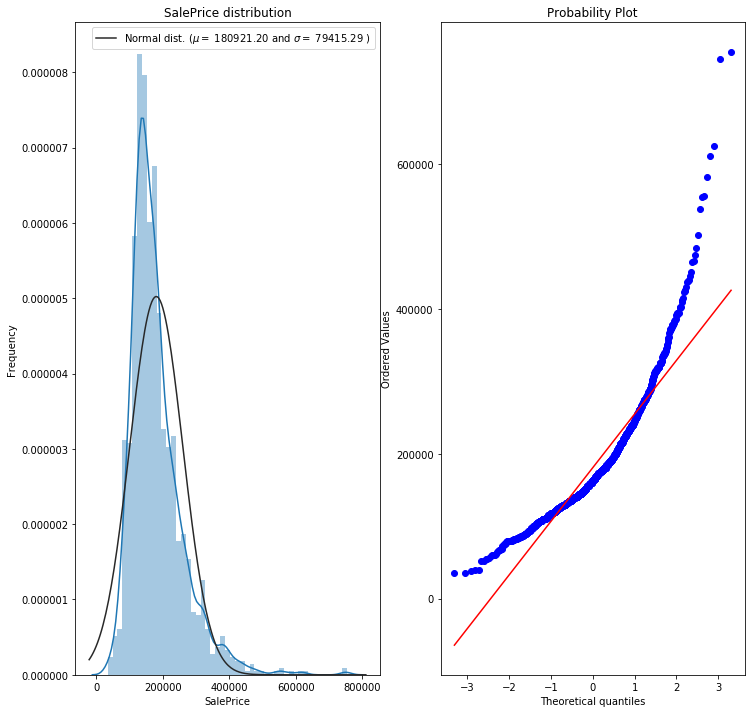

In [10]:
response_variable_distribution('SalePrice',df_train)

In [11]:
# Use log transformation (log(1+x)) via the the numpy fuction log1p to SalePrice
df_train["SalePrice"] = np.log1p(df_train["SalePrice"])

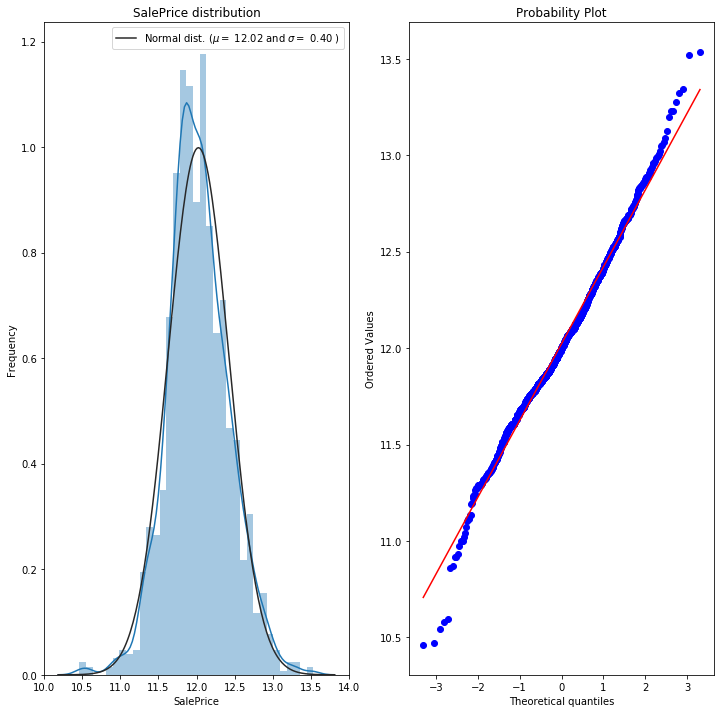

In [12]:
response_variable_distribution('SalePrice',df_train)

#### Concatenate train and test data into one dataframe

This is done in order to simplfy the process of missing variable replacement as well as to make visulising the distributions of the various variables easier

In [13]:
# split off sales price from train data into y_train for later use in the modelling section
y_train = df_train.SalePrice.values

# create mask varaibles for test and train subsetting later on
ntrain = df_train.shape[0]
ntest = df_test.shape[0]

# concatenate train and test dataframes, drop SalePrice column and print the shape of the new all_data dataframe
all_data = pd.concat((df_train, df_test)).reset_index(drop=True)
all_data.drop(['SalePrice'], axis=1, inplace=True)
print("all_data size is : {}".format(all_data.shape))

all_data size is : (2919, 79)


#### Find categories that contain missing values and calculate the percentage.

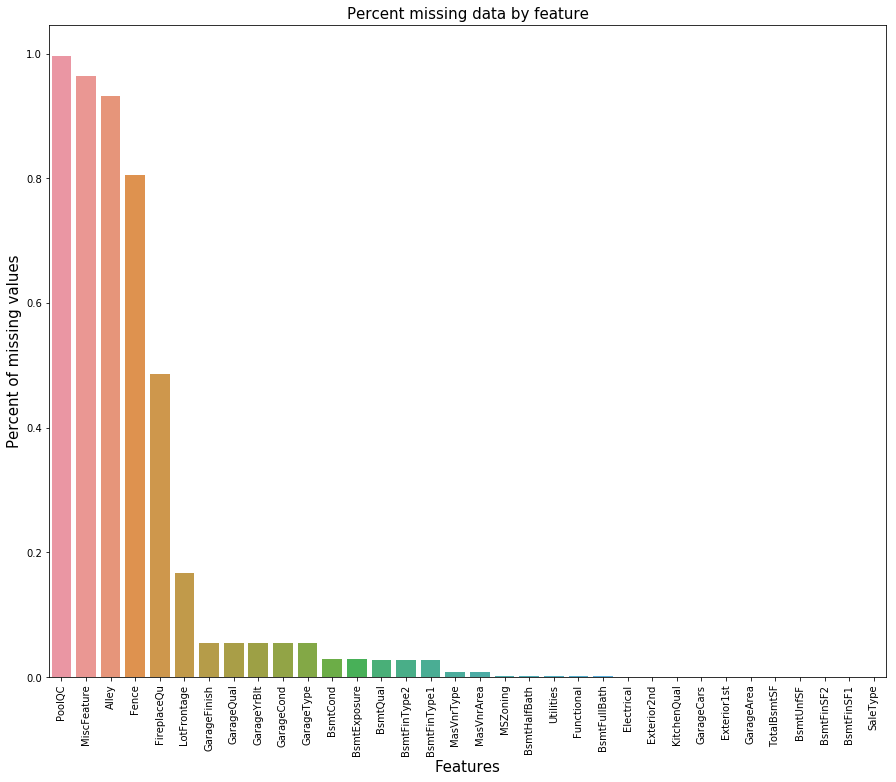

In [14]:
percent_missing_data(all_data)

#### Imputation of any missing values as well as decisions for variable relavance.

We performed this by proceeding sequentially through features with missing values. For each of the features we performed a general distribution check (which informed us on what to replace missing values with), replaced missing values, plotted new distribution with missing values replaced and in the case of the feature being part of a larger feature set we constructed a heatmap showing the correlations between the feature set, containing our feature, and the response variable (in this case SalePrice)

- Feature Set = Pool

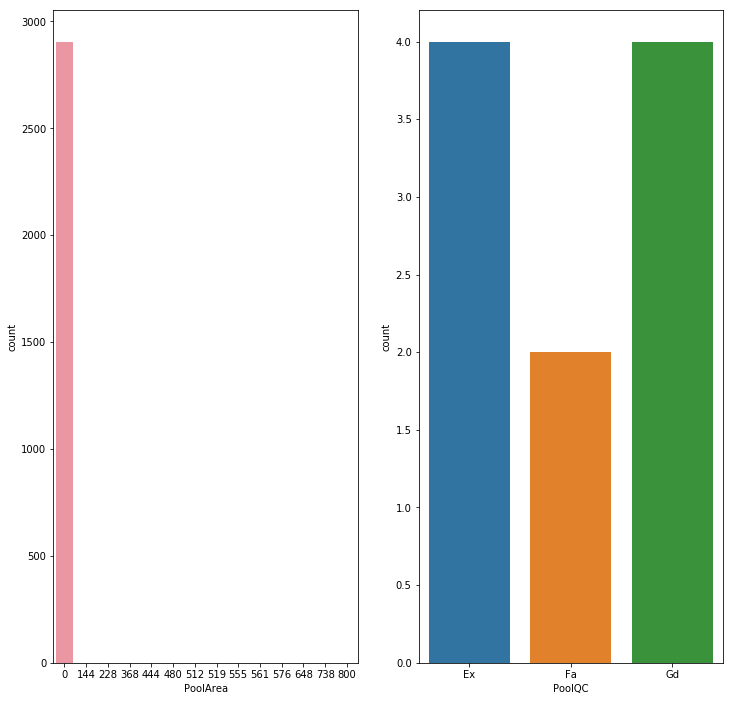

In [15]:
variable_imputation_check('Pool',all_data,df_train,'SalePrice',subplots='Y',ncols=2,add_rows=0)

>Data description says NA means "No Pool".

In [16]:
all_data['PoolQC'] = all_data['PoolQC'].fillna('None')

- Feature = MiscFeature

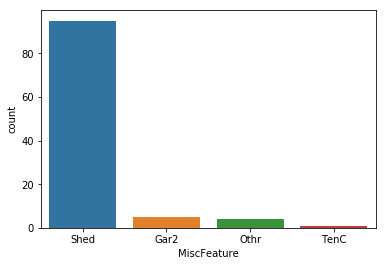

In [17]:
variable_imputation_check('MiscFeature',all_data,df_train,'SalePrice')

>Data description says says NA means "no misc feature"

In [18]:
all_data['MiscFeature'] = all_data['MiscFeature'].fillna('None')

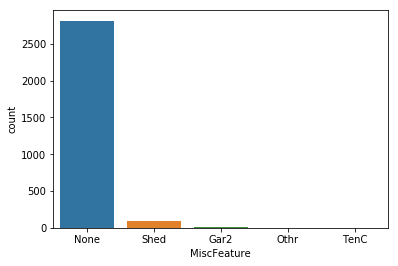

In [19]:
variable_imputation_check('MiscFeature',all_data,df_train,'SalePrice')

In [20]:
# was initially dropped
#all_data = all_data.drop(['MiscFeature'], axis=1)

- Feature = Alley

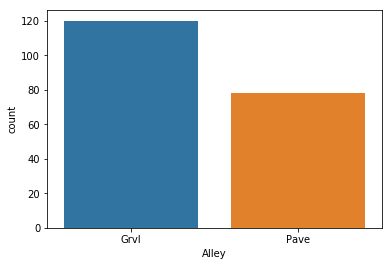

In [21]:
variable_imputation_check('Alley',all_data,df_train,'SalePrice')

>Data description says says NA means "no alley access"

In [22]:
all_data['Alley'] = all_data['Alley'].fillna('None')

- Feature = Fence

Fence : data description says NA means "no fence"

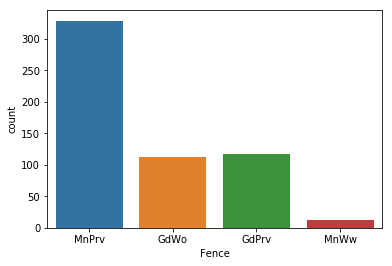

In [23]:
variable_imputation_check('Fence',all_data,df_train,'SalePrice')

>Data description says says NA means "no fence"

In [24]:
all_data['Fence'] = all_data['Fence'].fillna('None')

- Feature Set = Fireplace

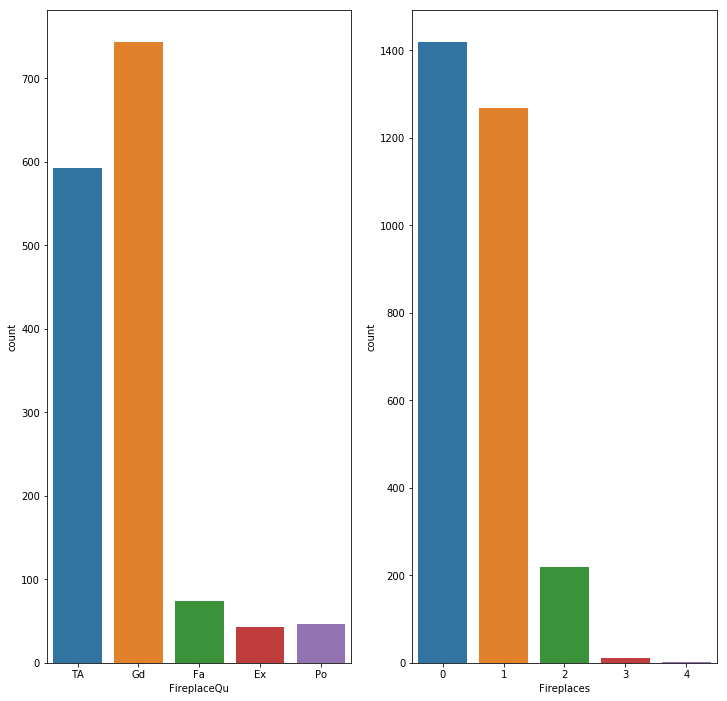

In [25]:
variable_imputation_check('Fireplace',all_data,df_train,'SalePrice',subplots='Y', ncols=2, add_rows=0, fig_size=(12, 12))

>Data description says says NA means "no fireplace"

In [26]:
all_data['FireplaceQu'] = all_data['FireplaceQu'].fillna('None')

- The measurement scale used for FireplaceQu: **None Po Fa TA Gd Ex**
- The value scale to be used: FireplaceQu: **0 1 2 3 4 5**

Input the measurement scale to be used for FireplaceQu: None Po Fa TA Gd Ex
Input the value scale to be used for FireplaceQu: 0 1 2 3 4 5


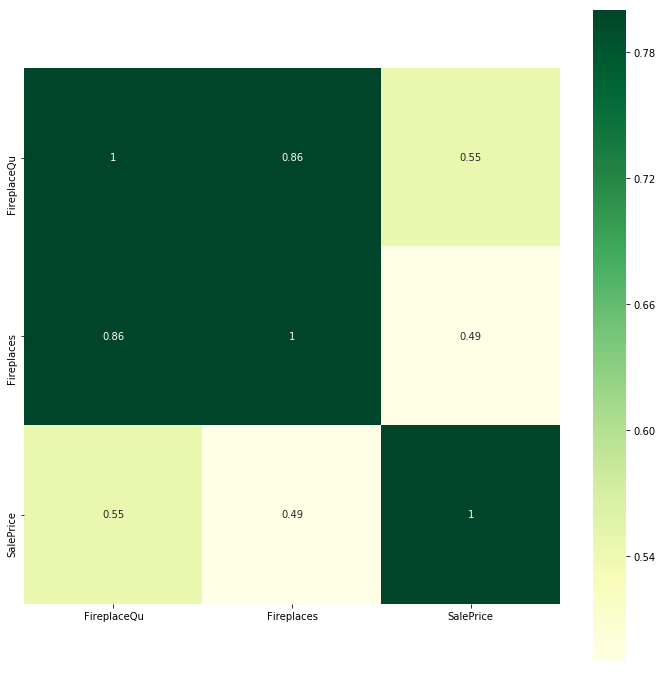

In [27]:
variable_correlation_check(string='Fireplace',df=all_data,train_df=df_train,response_variable='SalePrice',ordinal_variables=['FireplaceQu'],color='YlGn')

- Feature Set = Lot

>The approach was slightly differnt for this particular variable. We first needed to decide how were were going to fill the missing Lot Frontage vaules before we could procede with the rest of the EDA.

In [28]:
# subset orginal dataframe by train (to prevent missing SalePrice values from affecting the plots) and then concatenate SalePrice to this new dataframe
lot_frontage = all_data[:ntrain]

#concatenate SalePrice to this new dataframe and then subset it to contain only SalePrice and LotFrontage
lot_frontage = pd.concat([lot_frontage, df_train[['SalePrice']]], axis=1)
lot_frontage = lot_frontage[['SalePrice','LotFrontage']]

# subset orginal dataframe by train (to prevent missing SalePrice values from affecting the plots) and then concatenate SalePrice to this new dataframe
lot_frontage_0fill = all_data[:ntrain]

#concatenate SalePrice to this new dataframe, fill NA values with 0 and then subset it to contain only SalePrice and LotFrontage
lot_frontage_0fill = pd.concat([lot_frontage_0fill, df_train[['SalePrice']]], axis=1).fillna(value=0)
lot_frontage_0fill = lot_frontage_0fill[['SalePrice','LotFrontage']]

# subset orginal dataframe by train (to prevent missing SalePrice values from affecting the plots) and then concatenate SalePrice to this new dataframe
lot_frontage_grouped_medianfill = all_data[:ntrain]

#concatenate SalePrice to this new dataframe, fill NA values wiht the median by grouped neighborhood and then subset it to contain only SalePrice and LotFrontage
lot_frontage_grouped_medianfill = pd.concat([lot_frontage_grouped_medianfill, df_train[['SalePrice']]], axis=1)
lot_frontage_grouped_medianfill = df_train.groupby("Neighborhood")['LotFrontage', 'SalePrice'].transform(
    lambda x: x.fillna(x.median()))

Text(0.5, 1.0, 'Lot Frontage With Grouped Median Fill')

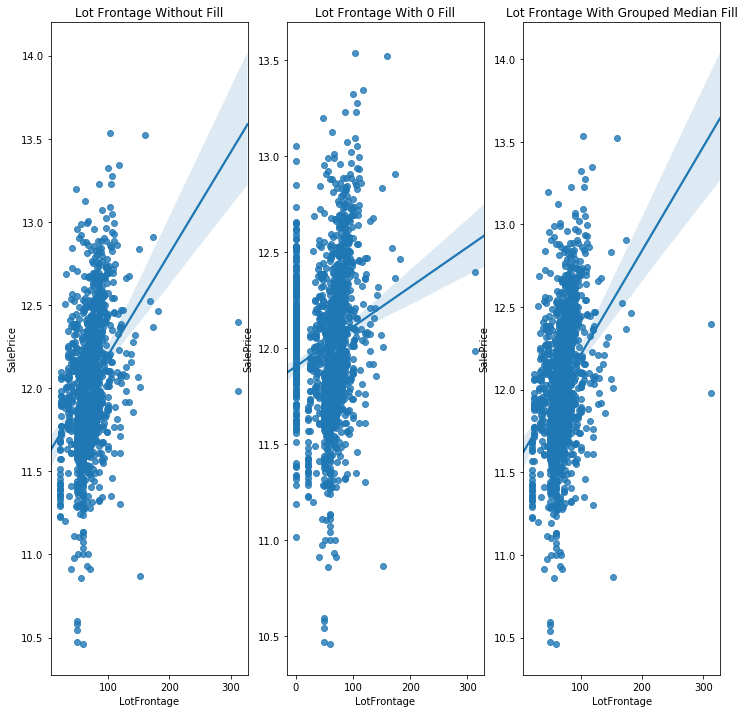

In [29]:
# set up the axes, figure layout and total size for the plot
fig, ax = plt.subplots(nrows=1,ncols=3)
fig.set_size_inches(12, 12)

# plot the first subplot (Lot Frontage Without Fill)
plt.subplot(1,3,1)
sns.regplot(y=lot_frontage['SalePrice'], x=lot_frontage['LotFrontage'])
plt.title('Lot Frontage Without Fill', fontsize=12)

# plot the second subplot (Lot Frontage With 0 Fill)
plt.subplot(1,3,2)
sns.regplot(y=lot_frontage_0fill['SalePrice'], x=lot_frontage_0fill['LotFrontage'])
plt.title('Lot Frontage With 0 Fill', fontsize=12)

# plot the third subplot (Lot Frontage Grouped Median Fill)
plt.subplot(1,3,3)
sns.regplot(y=lot_frontage_grouped_medianfill['SalePrice'], x=lot_frontage_grouped_medianfill['LotFrontage'])
plt.title('Lot Frontage With Grouped Median Fill', fontsize=12)

>Filling the missing with 0's not a good option as it skewes the correlation to SalesPrice. Most houses in areas have similar Lot Frontage values therefore we can fill in missing values by the median LotFrontage of the neighborhood the house resides in.

In [30]:
all_data["LotFrontage"] = all_data.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))

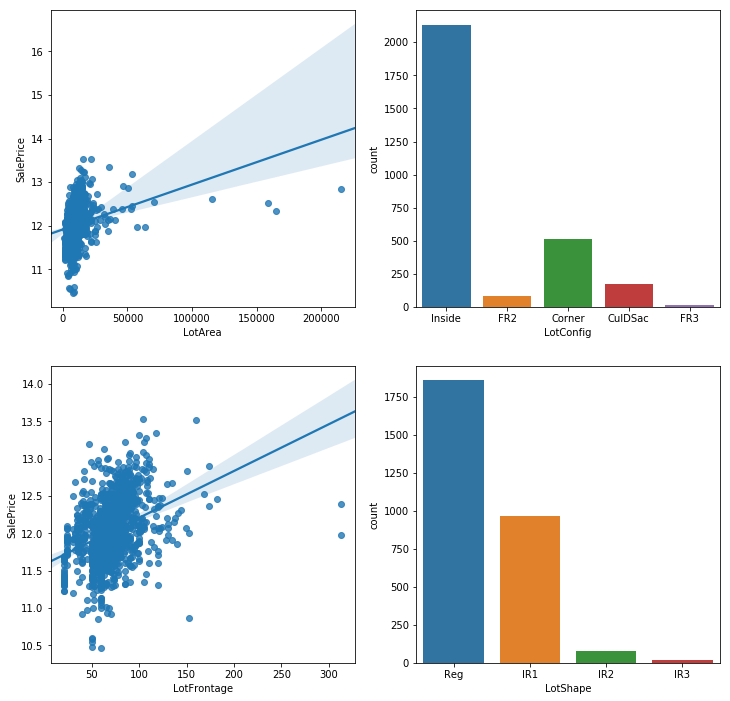

In [31]:
variable_imputation_check('Lot',all_data,df_train,'SalePrice',subplots='Y', ncols=2, add_rows=0, fig_size=(12,12))

- The measurement scale used for LotShape: **IR3 IR2 IR1 Reg**
- The value scale to be used: LotShape: **0 1 2 3**

Input the measurement scale to be used for LotShape: IR3 IR2 IR1 Reg
Input the value scale to be used for LotShape: 0 1 2 3


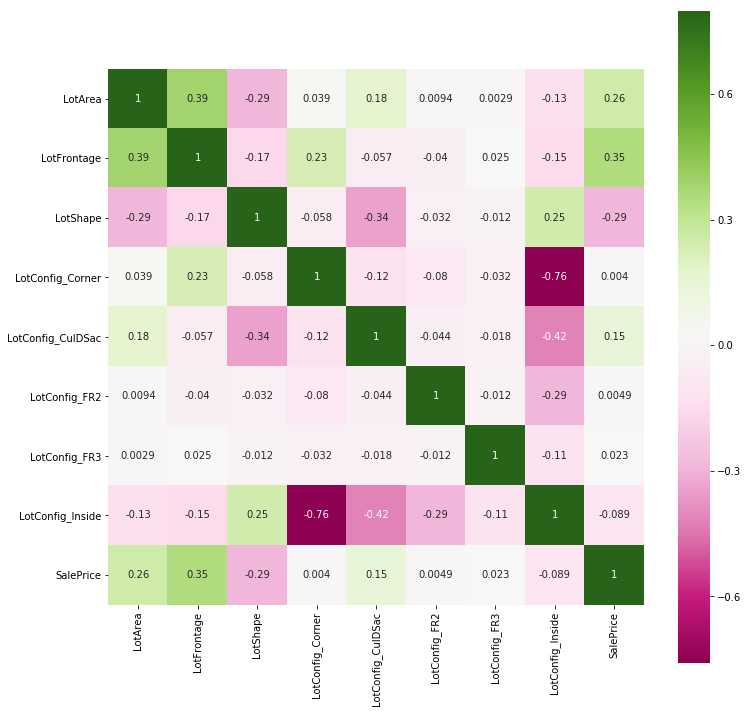

In [32]:
variable_correlation_check(string='Lot',df=all_data,train_df=df_train,response_variable='SalePrice',ordinal_variables=['LotShape'],categorical_variables=['LotConfig'])

- Feature Set = Garage

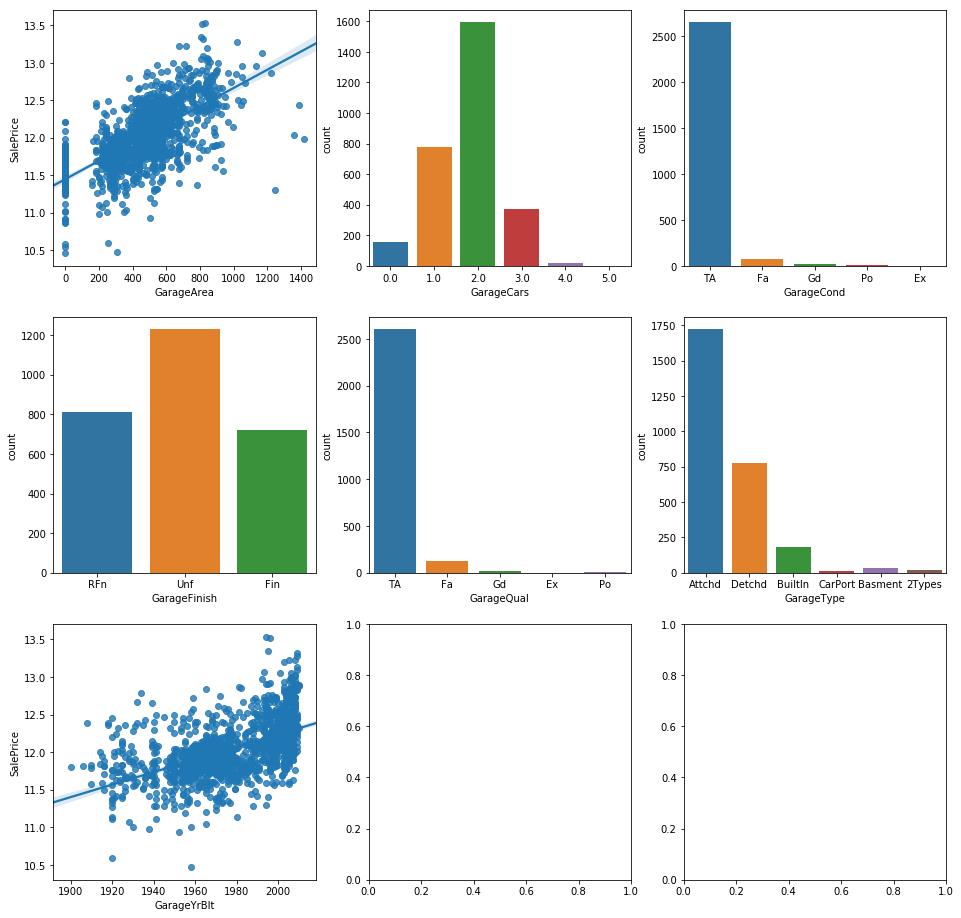

In [33]:
variable_imputation_check('Garage',all_data,df_train,response_value='SalePrice',subplots='Y', ncols=3, fig_size=(16, 16))

>Replacing missing data with None as most of the missing values indicate that there is no garage present for that house

In [34]:
all_data[['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']] = all_data[['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']].fillna('None')

In [35]:
all_data[['GarageYrBlt', 'GarageArea', 'GarageCars']] = all_data[['GarageYrBlt', 'GarageArea', 'GarageCars']].fillna(0)

- The measurement scale used for GarageQual and GarageCond: **None Po Fa TA Gd Ex**
- The value scale to be used for GarageQual and GarageCond: **0 1 2 3 4 5**
- The measurement scale used for GarageFinish: **None Unf RFn Fin**
- The value scale to be used for GarageFinish: **0 1 2 3**

Input the measurement scale to be used for GarageQual: None Po Fa TA Gd Ex
Input the value scale to be used for GarageQual: 0 1 2 3 4 5
Input the measurement scale to be used for GarageCond: None Po Fa TA Gd Ex
Input the value scale to be used for GarageCond: 0 1 2 3 4 5
Input the measurement scale to be used for GarageFinish: None Unf RFn Fin
Input the value scale to be used for GarageFinish: 0 1 2 3


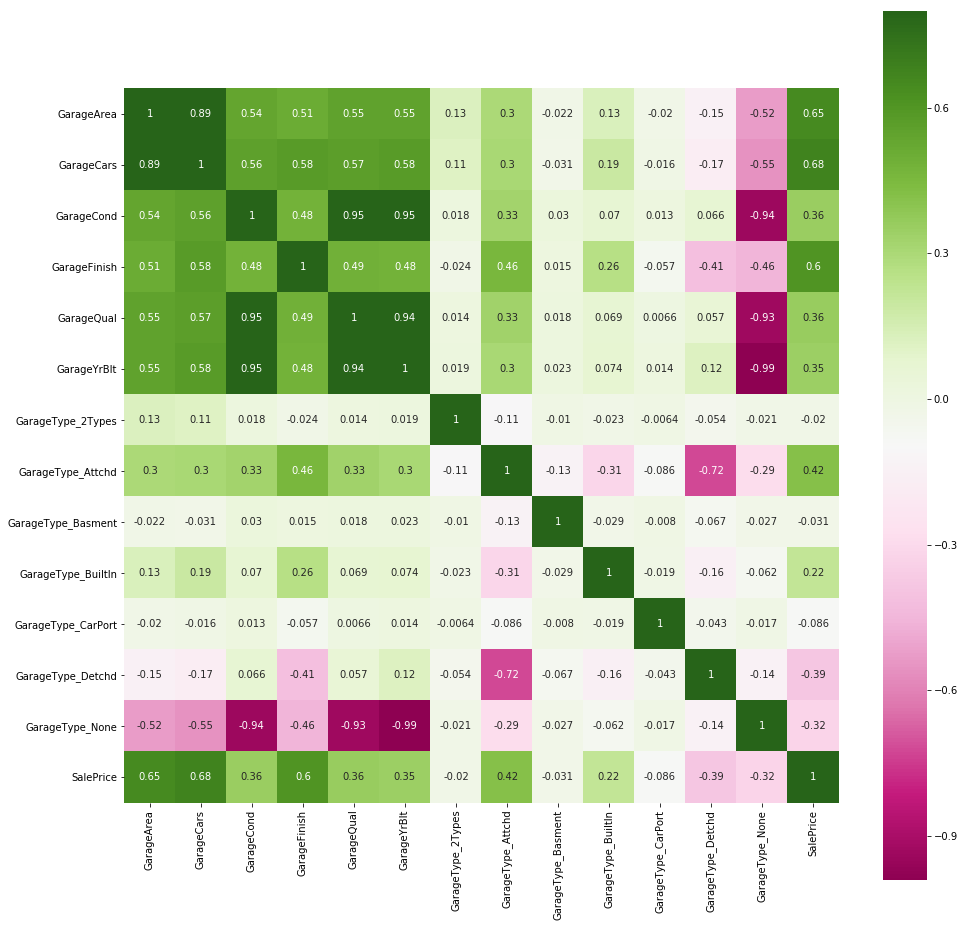

In [36]:
variable_correlation_check(string='Garage',df=all_data,train_df=df_train,response_variable='SalePrice',ordinal_variables=['GarageQual','GarageCond','GarageFinish'],categorical_variables=['GarageType'],fig_size=(16,16))

- Feature Set = Basement

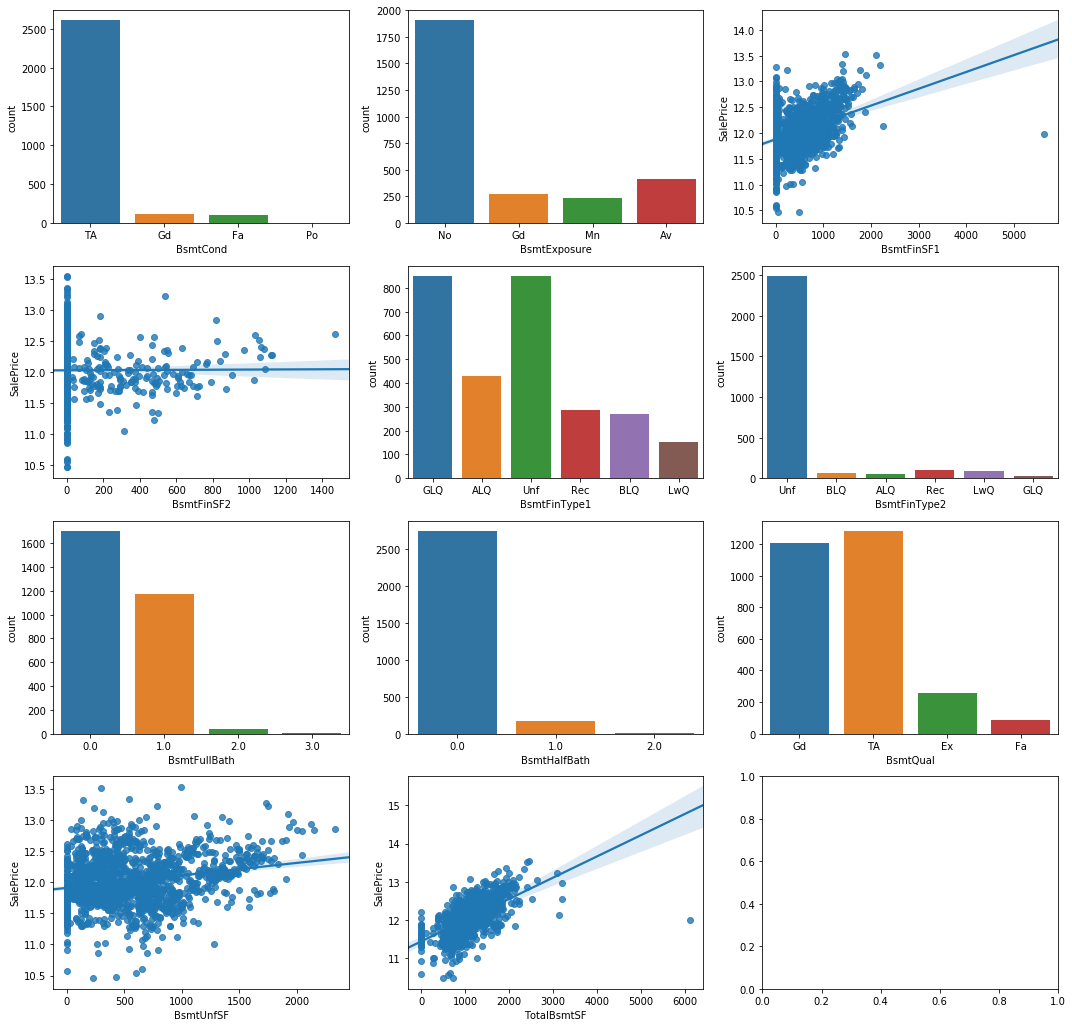

In [37]:
variable_imputation_check('Bsmt',all_data,df_train,response_value='SalePrice',subplots='Y', ncols=3, add_rows=0, fig_size=(18, 18))

>Replacing missing categorical data with None and missing numerical data with 0 as most of the missing values indicate that there is no basement present for that house

In [38]:
all_data[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']] = all_data[['BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF','TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath']].fillna(0)

In [39]:
all_data[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']] = all_data[['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']].fillna('None')

- The measurement scale used for BsmtQual and BsmtCond: **None Po Fa TA Gd Ex**
- The value scale to be used for BsmtQual and BsmtCond: **0 1 2 3 4 5**
- The measurement scale used for BsmtExposure: **None No Mn Av Gd**
- The value scale to be used for BsmtExposure: **0 1 2 3 4**

Input the measurement scale to be used for BsmtQual: None Po Fa TA Gd Ex
Input the value scale to be used for BsmtQual: 0 1 2 3 4 5
Input the measurement scale to be used for BsmtCond: None Po Fa TA Gd Ex
Input the value scale to be used for BsmtCond: 0 1 2 3 4 5
Input the measurement scale to be used for BsmtExposure: None No Mn Av Gd
Input the value scale to be used for BsmtExposure: 0 1 2 3 4


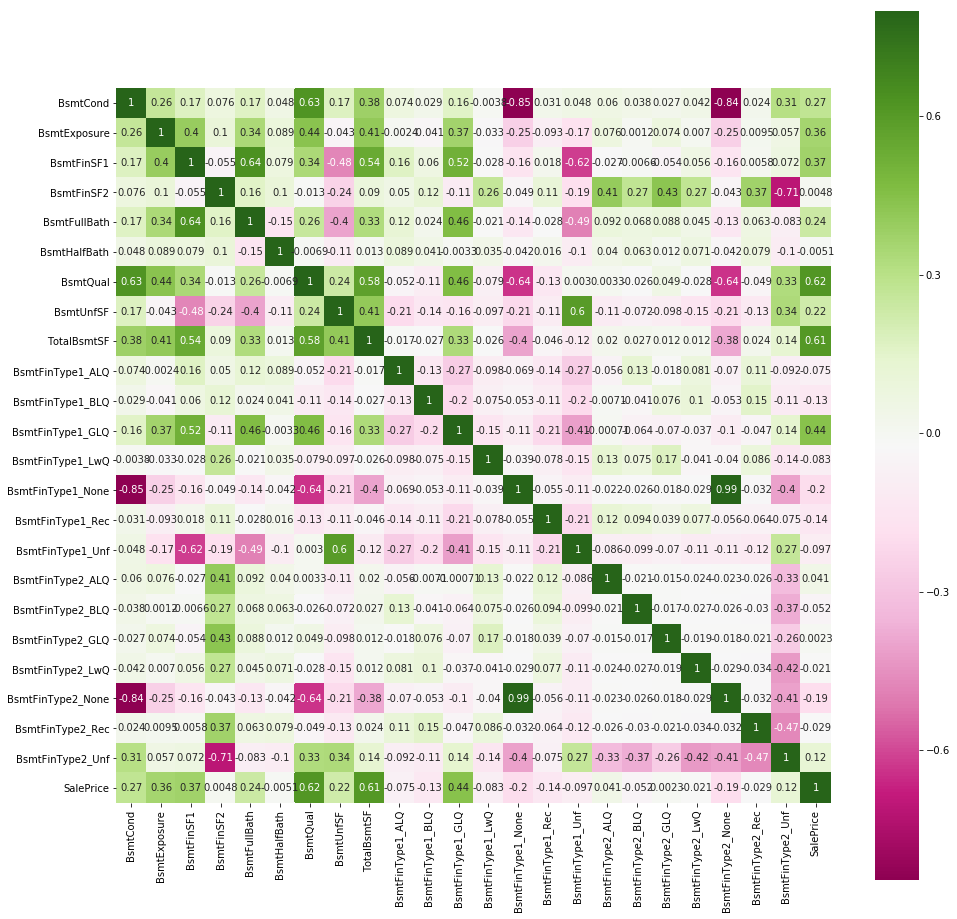

In [40]:
variable_correlation_check(string='Bsmt',df=all_data,train_df=df_train,response_variable='SalePrice',ordinal_variables=['BsmtQual','BsmtCond','BsmtExposure'],categorical_variables=['BsmtFinType1','BsmtFinType2'],fig_size=(16,16))

- Feature Set = Masonary

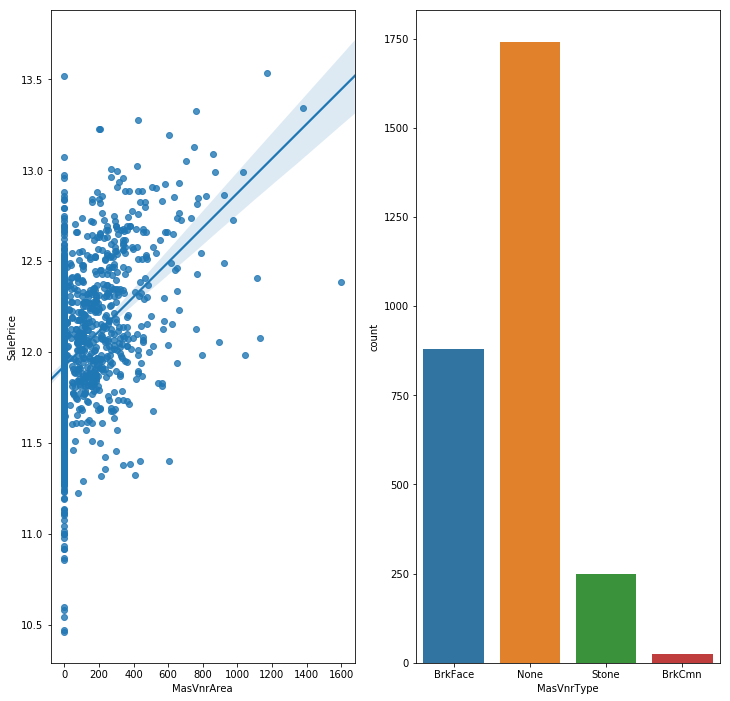

In [41]:
variable_imputation_check('Mas',all_data,df_train,response_value='SalePrice',subplots='Y', ncols=2, add_rows=0, fig_size=(12, 12))

>Replace missing MasVnrType values with None as NA probably refers to the house having no masonary present. 
> Replace missing MasVnrArea values with 0 as NA most likely means no masonary.

In [42]:
all_data[['MasVnrType']] = all_data[['MasVnrType']].fillna('None')

In [43]:
all_data[['MasVnrArea']] = all_data[['MasVnrArea']].fillna(0)

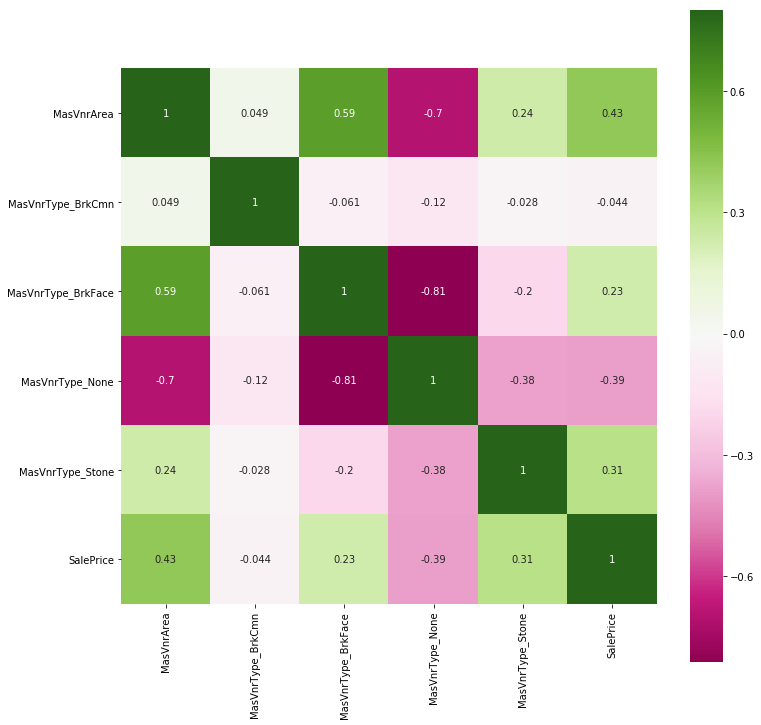

In [44]:
variable_correlation_check(string='Mas',df=all_data,train_df=df_train,response_variable='SalePrice',categorical_variables=['MasVnrType'])

- Feature Set = MS

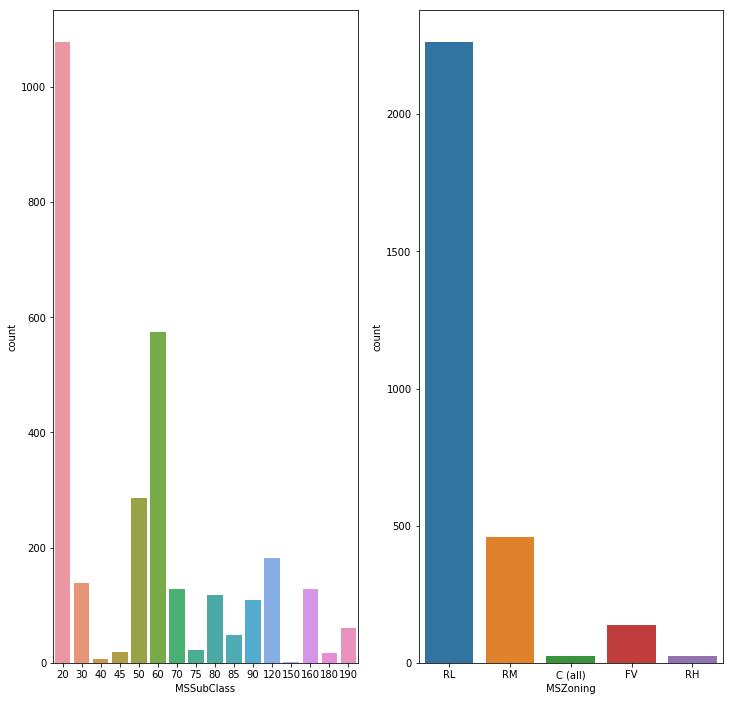

In [45]:
variable_imputation_check('MS',all_data,df_train,response_value='SalePrice',subplots='Y', ncols=2, add_rows=0, fig_size=(12, 12))

>Replace missing MSZoning values with 'RL' as it is the most common value. 
> Replace missing MSSubClass values with none as NA most likely means No building class.

In [46]:
all_data['MSZoning'] = all_data['MSZoning'].fillna(all_data['MSZoning'].mode()[0])

In [47]:
all_data['MSSubClass'] = all_data['MSSubClass'].fillna("None")

In [48]:
# convert MSSubclass to string as it is currently represented as an integer
all_data['MSSubClass'] = all_data['MSSubClass'].apply(str)

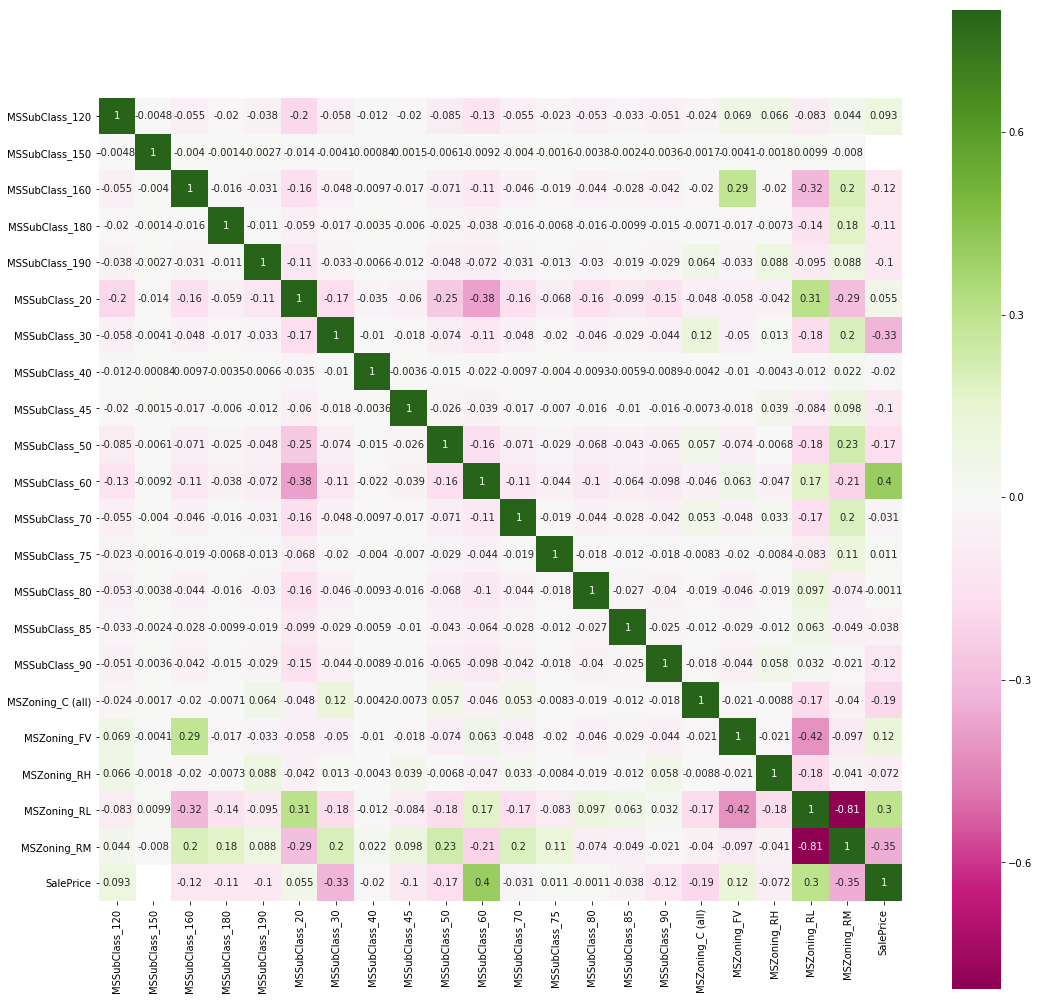

In [49]:
variable_correlation_check(string='MS',df=all_data,train_df=df_train,response_variable='SalePrice',categorical_variables=['MSSubClass','MSZoning'],fig_size=(18,18))

- Feature = Utilities

Utilities : For this categorical feature all records are "AllPub", except for one "NoSeWa" and 2 NA . Since the house with 'NoSewa' is in the training set, this feature won't help in predictive modelling. We can then safely remove it.

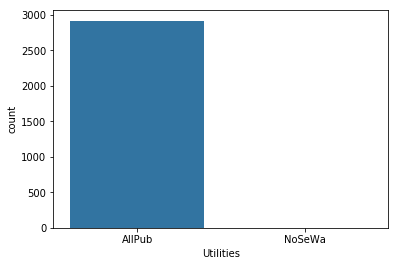

In [50]:
variable_imputation_check('Utilities',all_data,df_train,response_value='SalePrice')

>Replacing missing values with None as it probably means no utilities are present

In [51]:
all_data['Utilities'] = all_data['Utilities'].fillna("None")

- Feature = Functional

Functional : data description says NA means typical

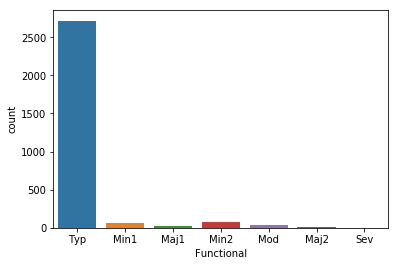

In [52]:
variable_imputation_check('Functional',all_data,df_train,'SalePrice')

>Replacing missing values with Typ as it is the most common value found in the dataset.

In [53]:
all_data['Functional'] = all_data['Functional'].fillna('Typ')

- Feature = Electrical

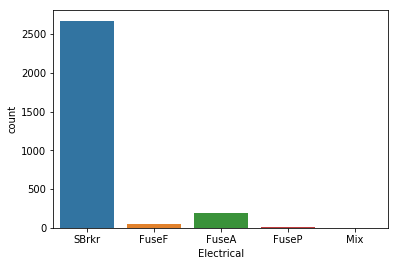

In [54]:
variable_imputation_check('Electrical',all_data,df_train,response_value='SalePrice')

>Replacing missing values with SBrkr as it is the most common value found in the dataset.

In [55]:
all_data['Electrical'] = all_data['Electrical'].fillna('SBrkr')

- Feature Set = Kitchen

KitchenQual: Only one NA value, and same as Electrical, we set 'TA' (which is the most frequent) for the missing value in KitchenQual.

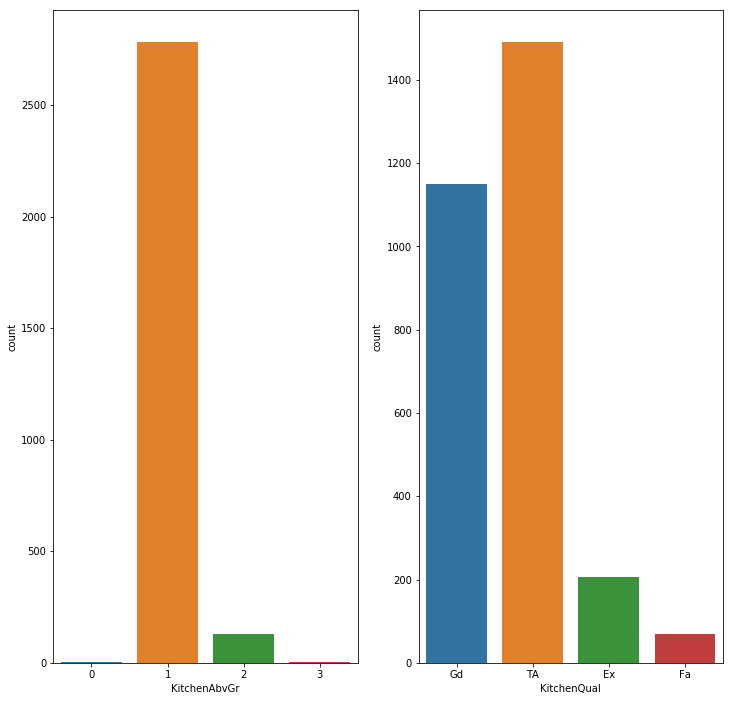

In [56]:
variable_imputation_check('Kitchen',all_data,df_train,response_value='SalePrice',subplots='Y', ncols=2, add_rows=0, fig_size=(12, 12))

>Replace missing KitchenQual values with 'TA' as it is the most common value. 

In [57]:
all_data['KitchenQual'] = all_data['KitchenQual'].fillna('TA')

- The measurement scale used for KitchenQual: **None Po Fa TA Gd Ex**
- The value scale to be used for KitchenQual: **0 1 2 3 4 5**

Input the measurement scale to be used for KitchenQual: None Po Fa TA Gd Ex
Input the value scale to be used for KitchenQual: 0 1 2 3 4 5


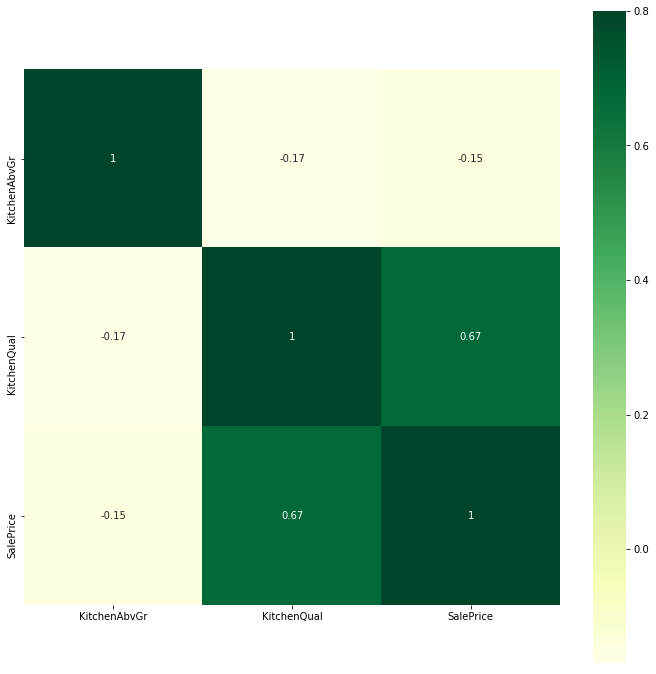

In [58]:
variable_correlation_check(string='Kitchen',df=all_data,train_df=df_train,response_variable='SalePrice',ordinal_variables=['KitchenQual'], color='YlGn')

Exterior1st and Exterior2nd : Again Both Exterior 1 & 2 have only one missing value. We will just substitute in the most common string

In [59]:
all_data['Exterior1st'] = all_data['Exterior1st'].fillna(all_data['Exterior1st'].mode()[0])
all_data['Exterior2nd'] = all_data['Exterior2nd'].fillna(all_data['Exterior2nd'].mode()[0])

- Feature = SaleType

SaleType : Fill in again with most frequent which is "WD"

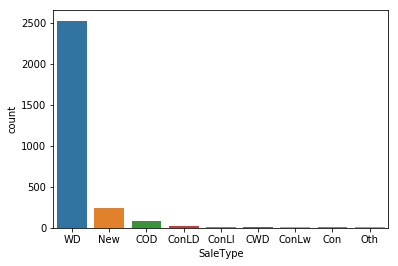

In [60]:
variable_imputation_check('SaleType',all_data,df_train,response_value='SalePrice')

>Replace missing values with 'WD' as it is the most common value. 

In [61]:
all_data['SaleType'] = all_data['SaleType'].fillna('WD')

#### Remaining missing value check

In [62]:
# create total and percent measures of missing data and then concatenate these into a dataframe
total = all_data.isnull().sum().sort_values(ascending=False)
percent = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)*100
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(1)

Total  Percent
YrSold      0      0.0

#### Check the remaining features for variable relavance

We performed this by proceeding sequentially through the features that remained. For each of the features we performed a general distribution check (which informed us on what to replace missing values with), replaced missing values, and in the case of the feature being part of a larger feature set we constructed a heatmap showing the correlations between the feature set, containing our feature, and the response variable (in this case SalePrice)

- Feature Set = Square Footage

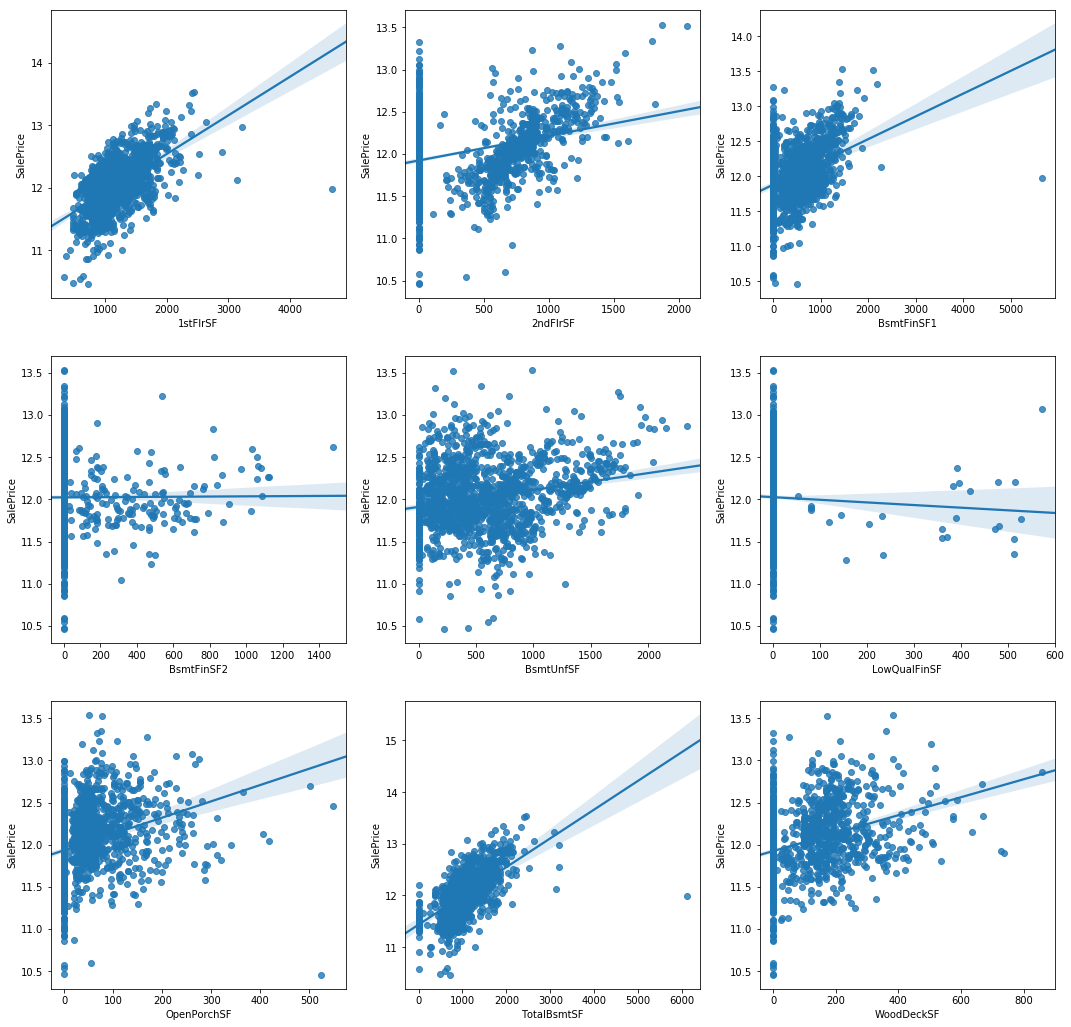

In [63]:
variable_imputation_check('SF',all_data,df_train,response_value='SalePrice',subplots='Y', ncols=3, add_rows=0, fig_size=(18, 18))

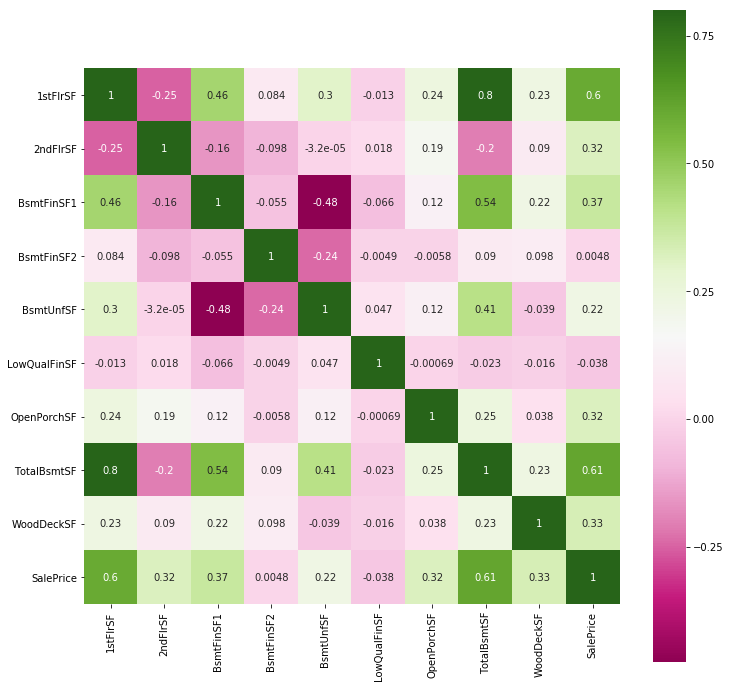

In [64]:
variable_correlation_check(string='SF',df=all_data,train_df=df_train,response_variable='SalePrice')

In [65]:
# feature enginner a TotalSF measure to see if it correlates better with SalePrice
all_data['TotalSF'] = all_data['1stFlrSF'] + all_data['2ndFlrSF'] +  all_data['TotalBsmtSF']

- Feature Set = Quality

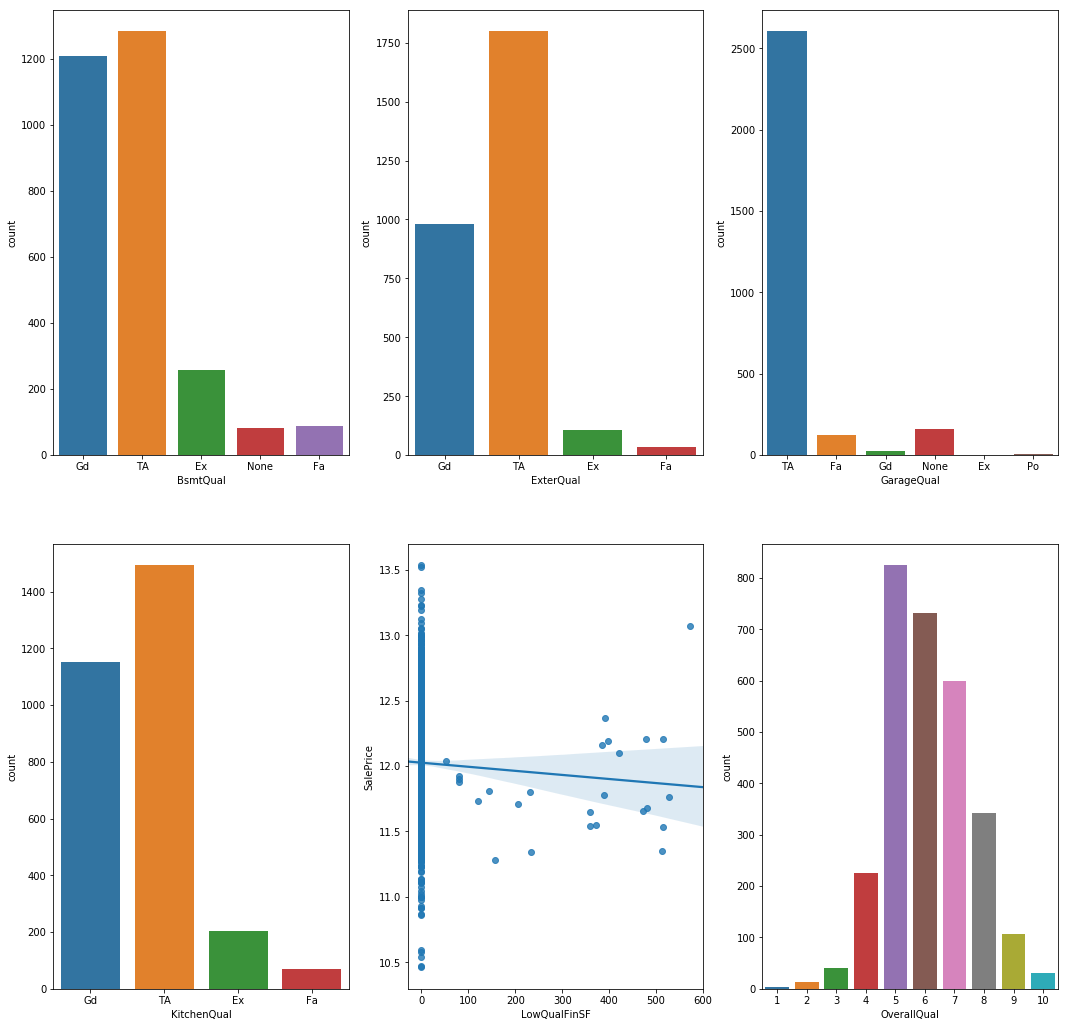

In [66]:
variable_imputation_check('Qual',all_data,df_train,response_value='SalePrice',subplots='Y', ncols=3, add_rows=0, fig_size=(18, 18))

- The measurement scale used for all Qual: **None Po Fa TA Gd Ex**
- The value scale to be used for all Qual: **0 1 2 3 4 5**

Input the measurement scale to be used for BsmtQual: None Po Fa TA Gd Ex
Input the value scale to be used for BsmtQual: 0 1 2 3 4 5
Input the measurement scale to be used for GarageQual: None Po Fa TA Gd Ex
Input the value scale to be used for GarageQual: 0 1 2 3 4 5
Input the measurement scale to be used for ExterQual: None Po Fa TA Gd Ex
Input the value scale to be used for ExterQual: 0 1 2 3 4 5
Input the measurement scale to be used for KitchenQual: None Po Fa TA Gd Ex
Input the value scale to be used for KitchenQual: 0 1 2 3 4 5


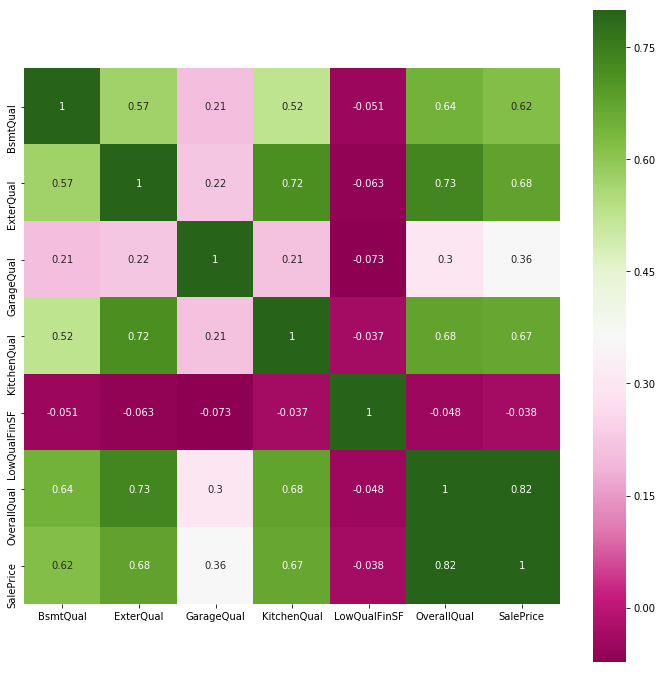

In [68]:
variable_correlation_check(string='Qual',df=all_data,train_df=df_train,response_variable='SalePrice',ordinal_variables=['BsmtQual','GarageQual','ExterQual','KitchenQual'])

- Feature Set = Condition

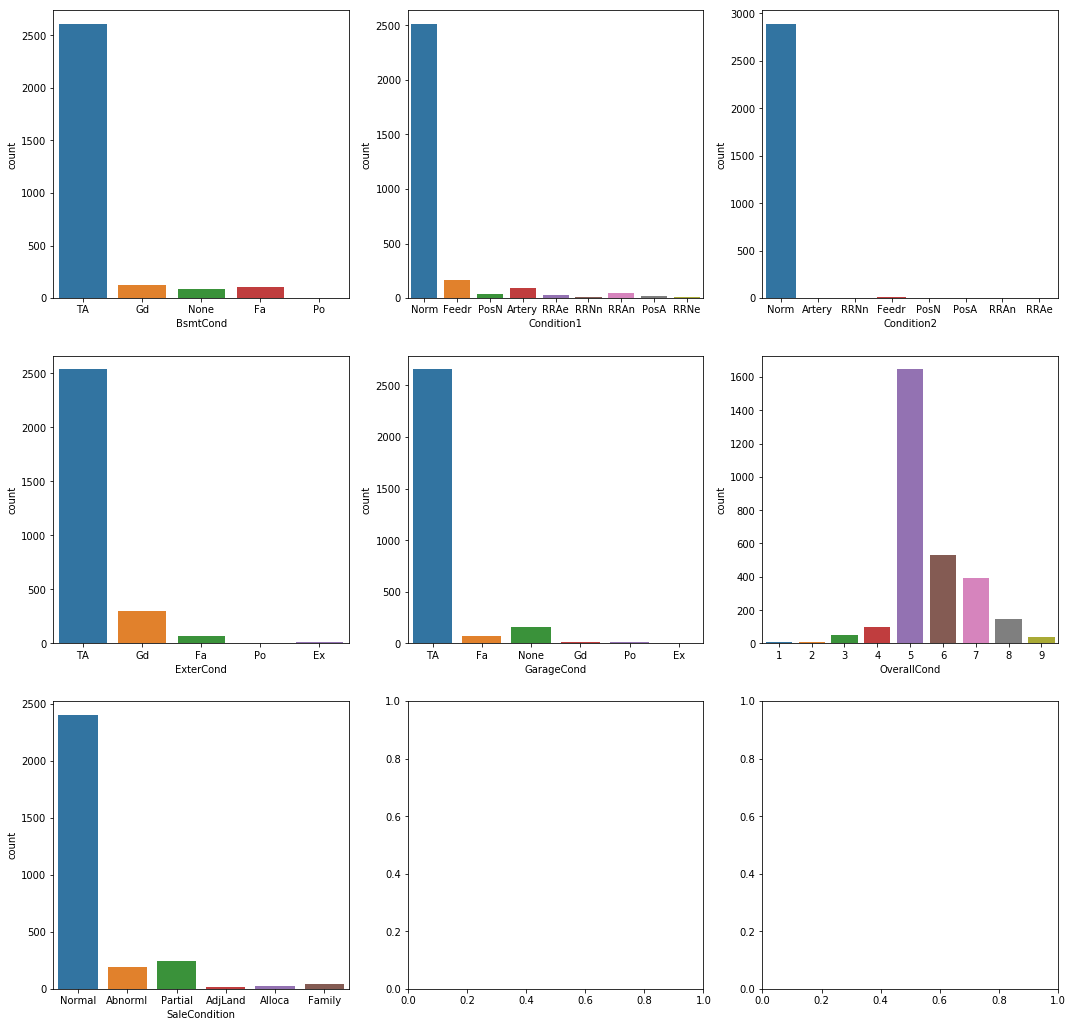

In [69]:
variable_imputation_check('Cond',all_data,df_train,response_value='SalePrice',subplots='Y', ncols=3, add_rows=1, fig_size=(18, 18))

- The measurement scale used for all Cond: **None Po Fa TA Gd Ex**
- The value scale to be used for all Cond: **0 1 2 3 4 5**

Input the measurement scale to be used for BsmtCond: None Po Fa TA Gd Ex
Input the value scale to be used for BsmtCond: 0 1 2 3 4 5
Input the measurement scale to be used for GarageCond: None Po Fa TA Gd Ex
Input the value scale to be used for GarageCond: 0 1 2 3 4 5
Input the measurement scale to be used for ExterCond: None Po Fa TA Gd Ex
Input the value scale to be used for ExterCond: 0 1 2 3 4 5


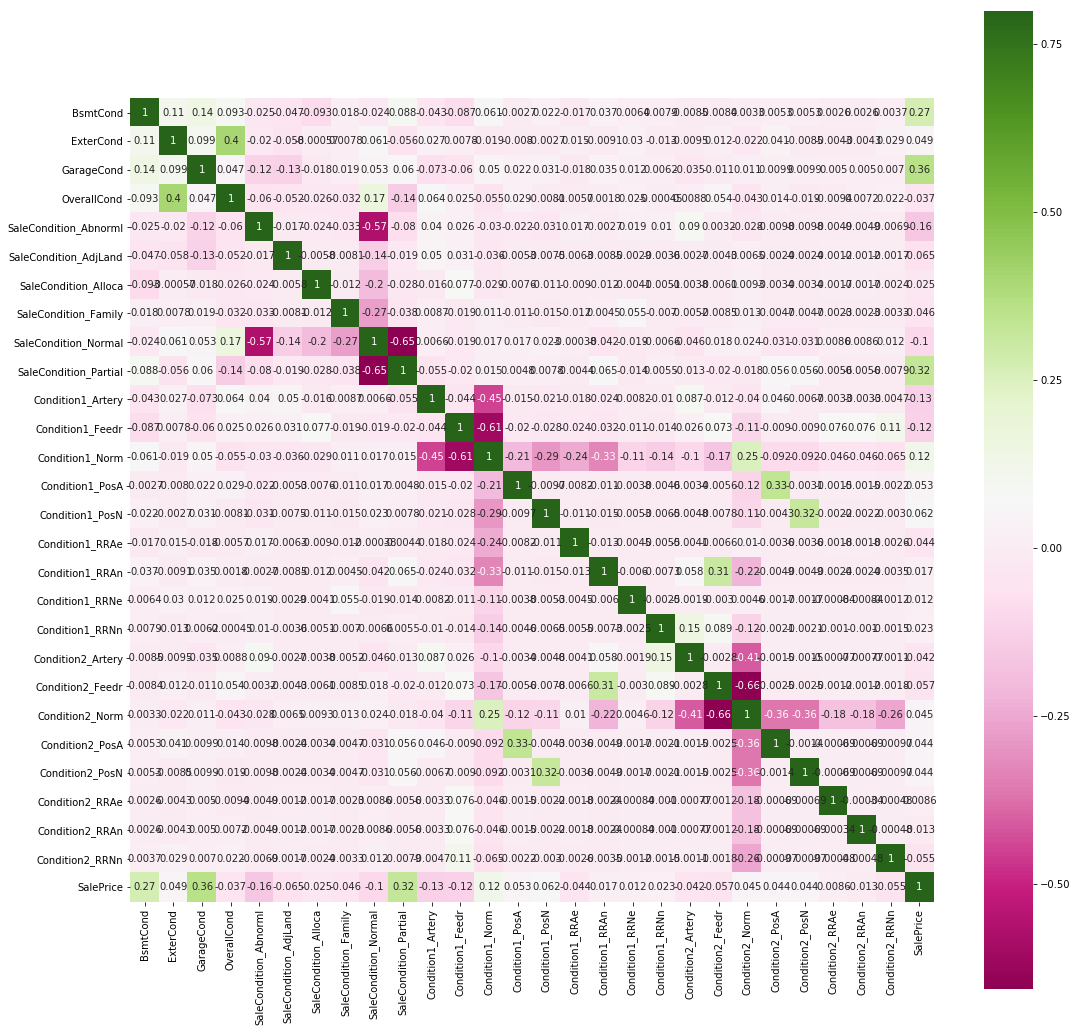

In [70]:
variable_correlation_check(string='Cond',df=all_data,train_df=df_train,response_variable='SalePrice',ordinal_variables=['BsmtCond','GarageCond','ExterCond',],categorical_variables=['SaleCondition','Condition1','Condition2'],fig_size=(18,18))

- Feature = Street

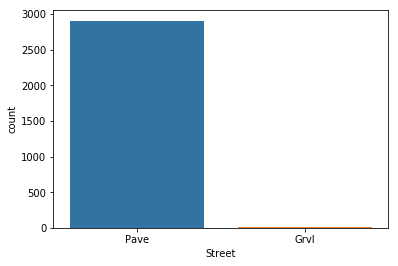

In [71]:
variable_imputation_check('Street',all_data,df_train,response_value='SalePrice')

- Feature Set = Land

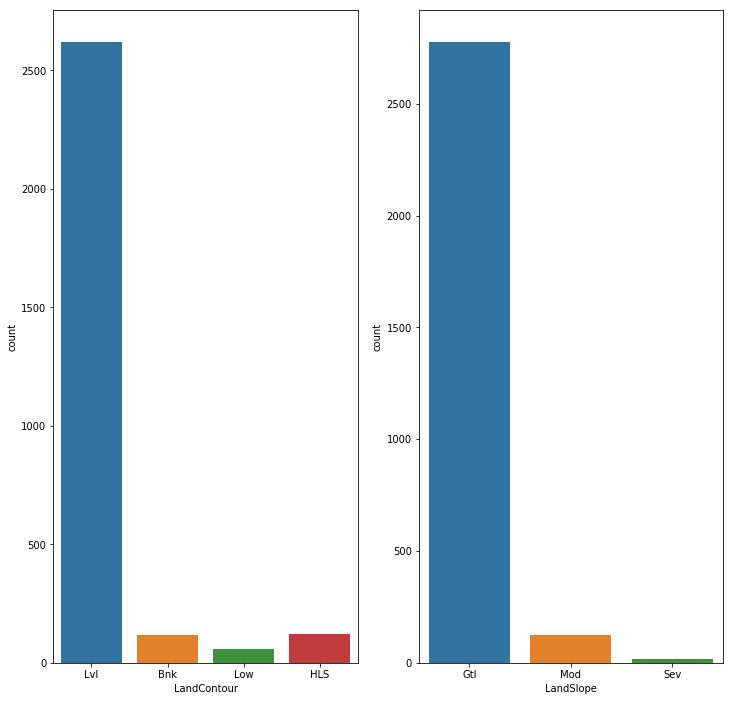

In [72]:
variable_imputation_check('Land',all_data,df_train,response_value='SalePrice',subplots='Y', ncols=2, add_rows=0)

- The measurement scale used for all Land: **Sev Mod Gtl**
- The value scale to be used for all Land: **0 1 2**

Input the measurement scale to be used for LandSlope: Sev Mod Gtl
Input the value scale to be used for LandSlope: 0 1 2


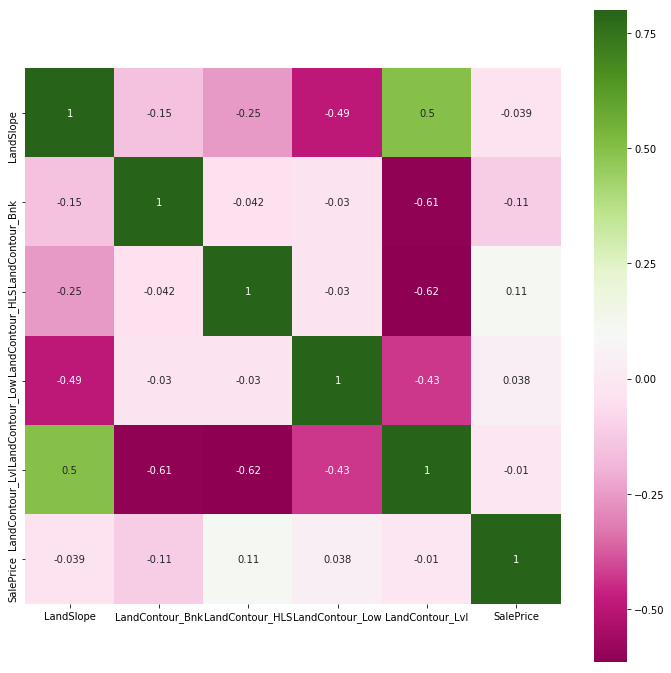

In [73]:
variable_correlation_check(string='Land',df=all_data,train_df=df_train,response_variable='SalePrice',ordinal_variables=['LandSlope'],categorical_variables=['LandContour'])

- Feature = Neighborhood

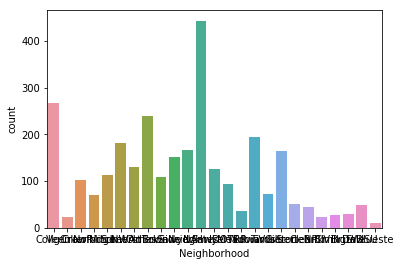

In [74]:
variable_imputation_check('Neighborhood',all_data,df_train,response_value='SalePrice',fig_size=(18, 18))

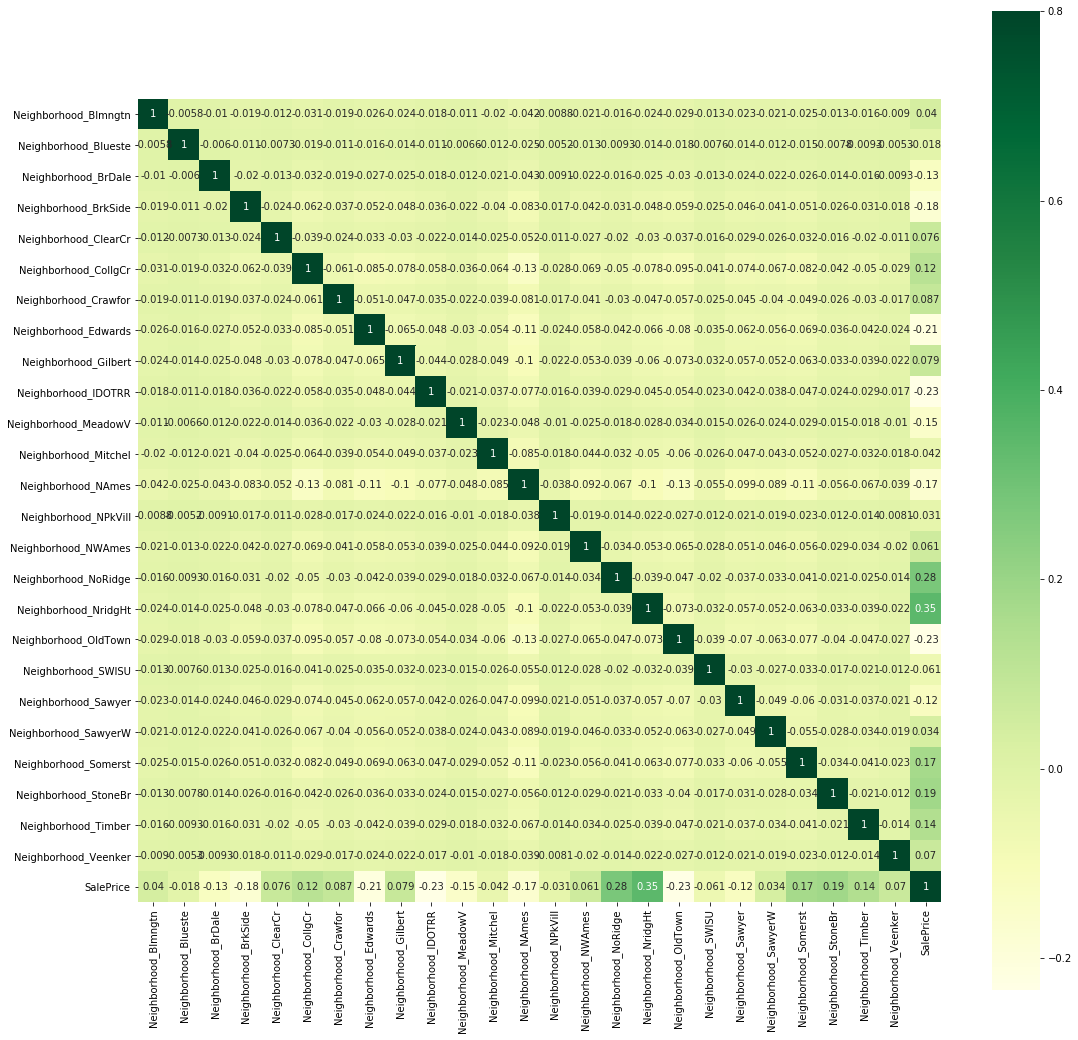

In [75]:
variable_correlation_check(string='Neighborhood',df=all_data,train_df=df_train,response_variable='SalePrice',categorical_variables=['Neighborhood'],fig_size=(18,18),color='YlGn')

- Feature = Building Type

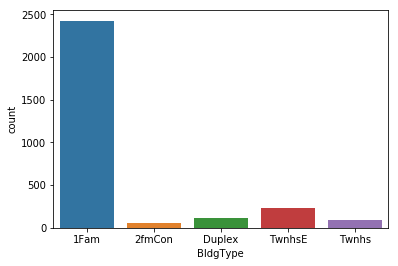

In [76]:
variable_imputation_check('BldgType',all_data,df_train,response_value='SalePrice')

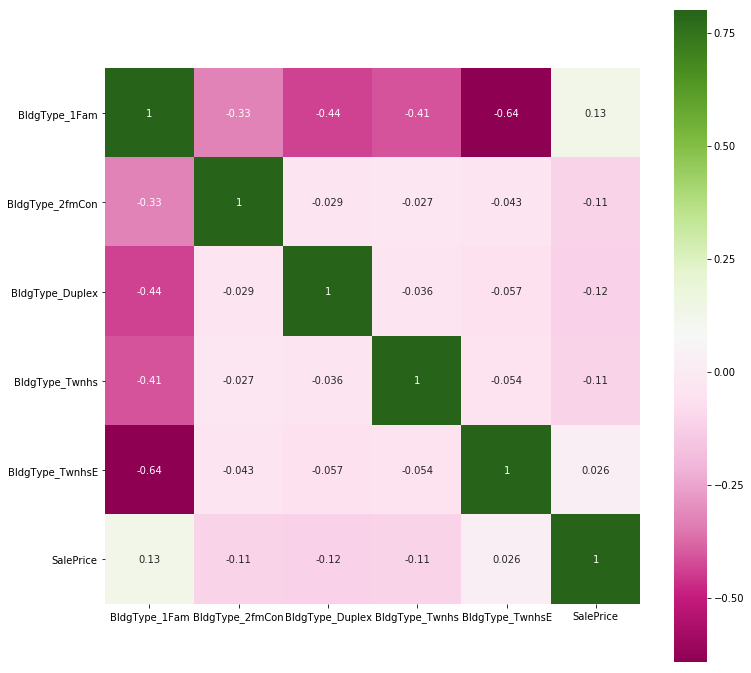

In [77]:
variable_correlation_check(string='BldgType',df=all_data,train_df=df_train,response_variable='SalePrice',categorical_variables=['BldgType'])

- Feature = House Style

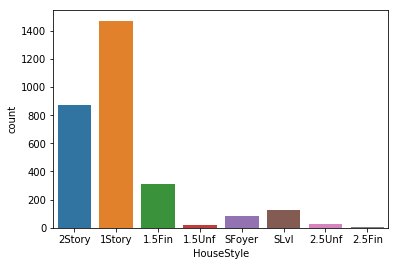

In [78]:
variable_imputation_check('HouseStyle',all_data,df_train,response_value='SalePrice')

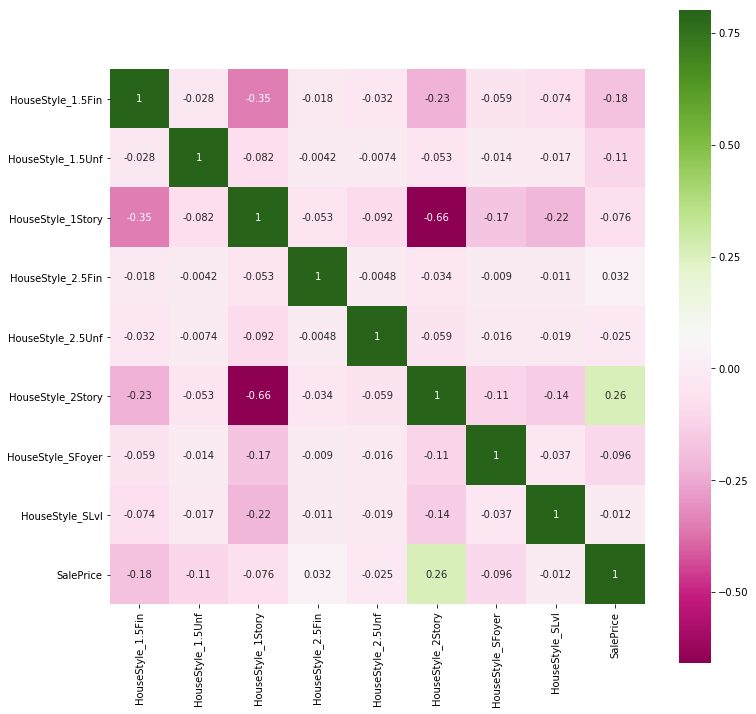

In [79]:
variable_correlation_check(string='HouseStyle',df=all_data,train_df=df_train,response_variable='SalePrice',categorical_variables=['HouseStyle'])

- Feature Set = Roof

Text(0.5, 1.0, 'RoofStyle Countplot')

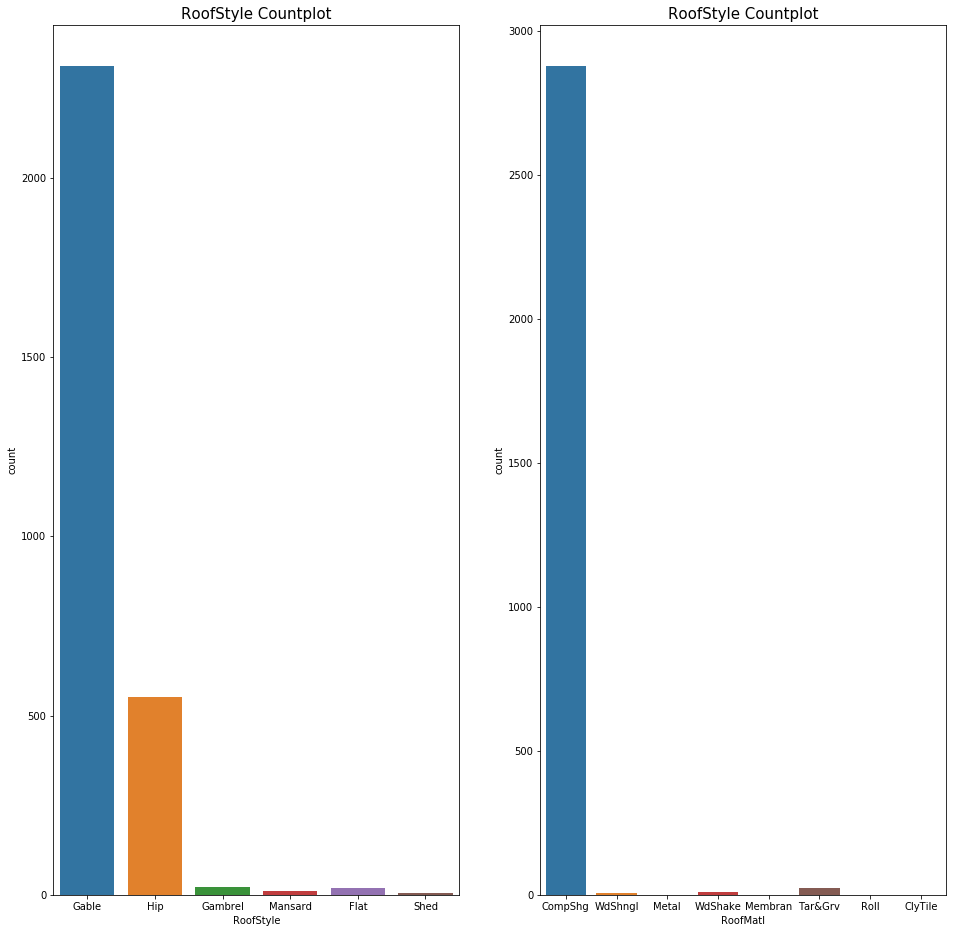

In [80]:
fig, ax = plt.subplots(nrows=1,ncols=2)
fig.set_size_inches(16, 16)

plt.subplot(1,2,1)
sns.countplot(all_data['RoofStyle'])
plt.title('RoofStyle Countplot', fontsize=15)

plt.subplot(1,2,2)
sns.countplot(all_data['RoofMatl'])
plt.title('RoofStyle Countplot', fontsize=15)

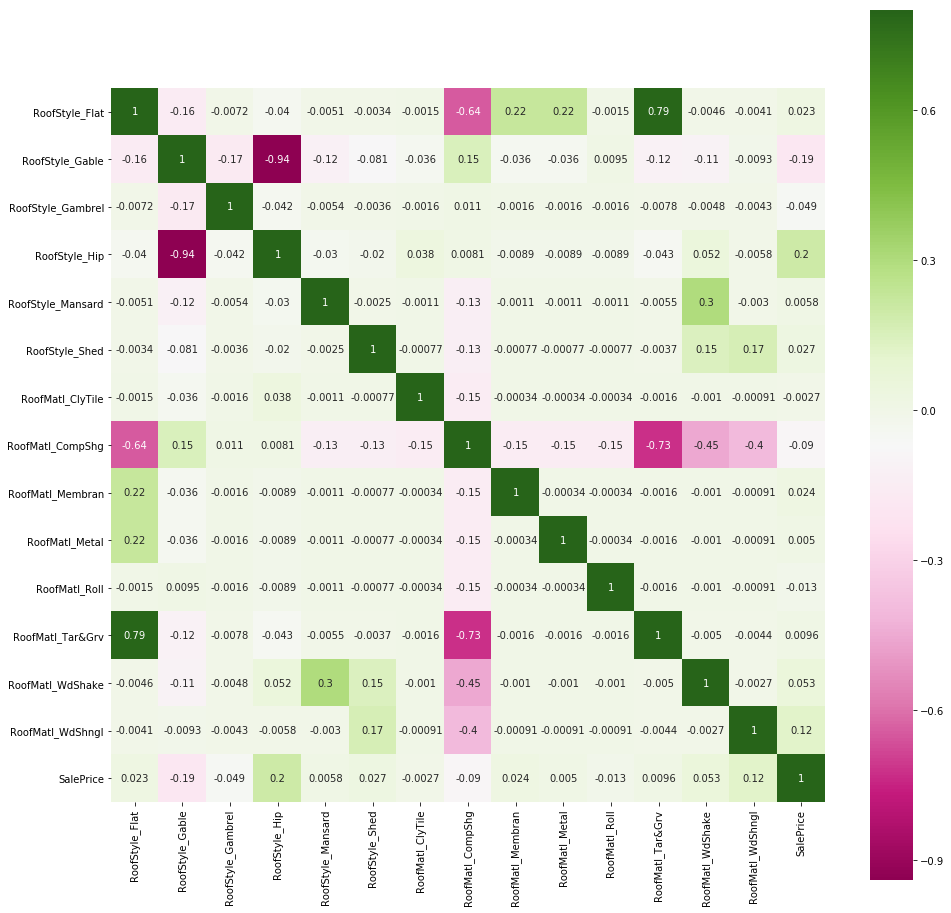

In [81]:
variable_correlation_check(string='Roof',df=all_data,train_df=df_train,response_variable='SalePrice',categorical_variables=['RoofStyle','RoofMatl'],fig_size=(16,16))

- Feature Set = Heating

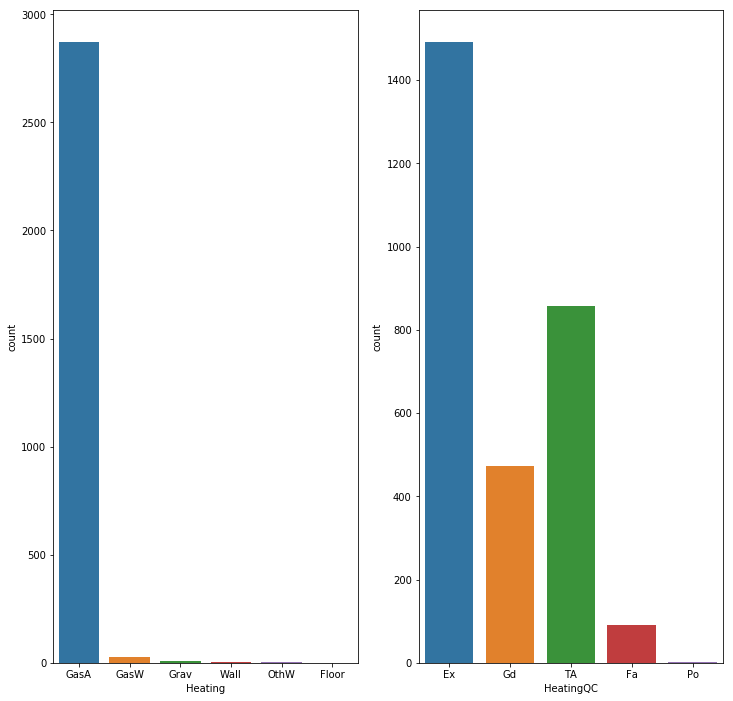

In [82]:
variable_imputation_check(string='Heating',df=all_data,train_df=df_train,response_value='SalePrice',subplots='Y',ncols=2,add_rows=0,fig_size=(12,12))

- The measurement scale used for all Heating: **None Po Fa TA Gd Ex**
- The value scale to be used for all Heating: **0 1 2 3 4 5**

Input the measurement scale to be used for HeatingQC: None Po Fa TA Gd Ex
Input the value scale to be used for HeatingQC: 0 1 2 3 4 5


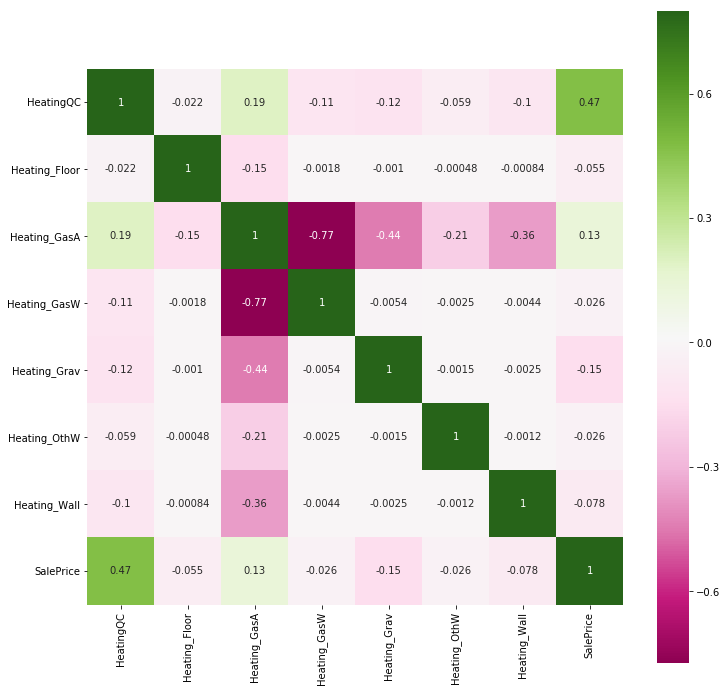

In [83]:
variable_correlation_check(string='Heating',df=all_data,train_df=df_train,response_variable='SalePrice',ordinal_variables=['HeatingQC'],categorical_variables=['Heating'])

- Feature = Air Conditioning

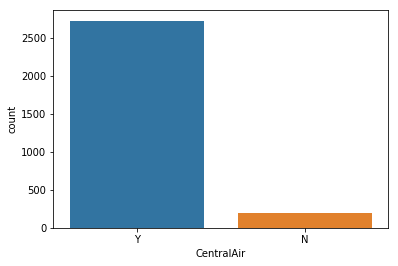

In [84]:
variable_imputation_check(string='CentralAir',df=all_data,train_df=df_train,response_value='SalePrice')

- The measurement scale used for CentralAir: **N Y**
- The value scale to be used for CentralAir: **0 1**

Input the measurement scale to be used for CentralAir: N Y
Input the value scale to be used for CentralAir: 0 1


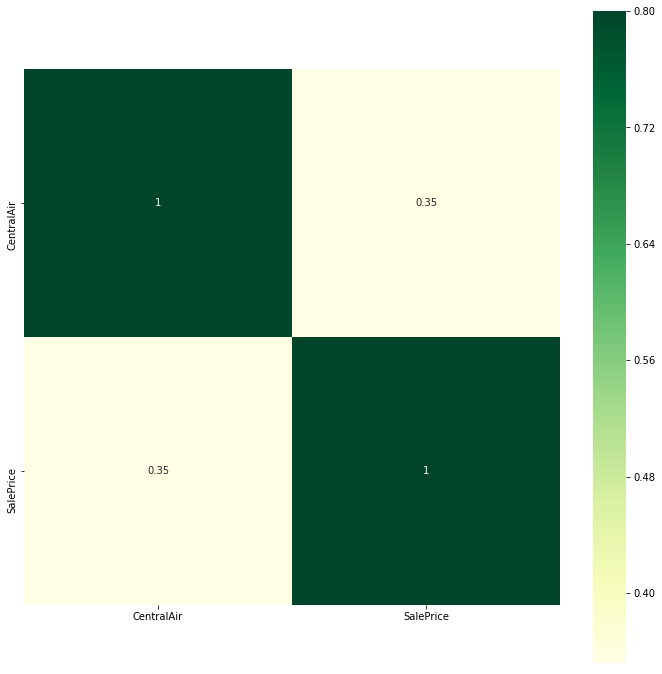

In [85]:
variable_correlation_check(string='CentralAir',df=all_data,train_df=df_train,response_variable='SalePrice',ordinal_variables=['CentralAir'],color='YlGn')

## 4. Data Preprocessing and Final preparation for modeling

We transformed some numerical variables into categorical so that they are encoded correctly in further procedures

In [ ]:
#Year and month sold are transformed into categorical features.
all_data['YrSold'] = all_data['YrSold'].astype(str)
all_data['MoSold'] = all_data['MoSold'].astype(str)

#### Label encode relevant features based on measurement and value scales shown prevoiusly

Ordinal feature encoding was performed here as the previous analyses were performed on subsetted dataframes and did not make any changes to the original dataframe

In [87]:
ordered_label_encoder(all_data,['FireplaceQu','BsmtQual','GarageFinish','GarageQual','ExterQual','KitchenQual','HeatingQC','ExterCond','BsmtCond','GarageCond','PoolQC'],['None','Po','Fa','TA','Gd','Ex'],[0,1,2,3,4,5])
ordered_label_encoder(all_data,['LotShape'],['IR3','IR2','IR1','Reg'],[0,1,2,3])
ordered_label_encoder(all_data,['GarageFinish'],['None','Unf','RFn','Fin'],[0,1,2,3])
ordered_label_encoder(all_data,['CentralAir','PavedDrive'],['N','Y'],[0,1])
ordered_label_encoder(all_data,['Street'],['Grvl','Pave'],[0,1])
ordered_label_encoder(all_data,['Alley'],['None','Grvl','Pave'],[0,1,2])
ordered_label_encoder(all_data,['LandSlope'],['Sev','Mod','Gtl'],[0,1,2])
ordered_label_encoder(all_data,['BsmtExposure'],['None','No','Mn','Av','Gd'],[0,1,2,3,4])
ordered_label_encoder(all_data,['Functional'],['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],[0,1,2,3,4,5,6,7])

#### Create heatmap of all variables correlations to SalePrice (includes all ordinal variables that have been encoded)

A heatmap of all numerical variables was drawn here to check the collinearity of the various features present in the dataframe

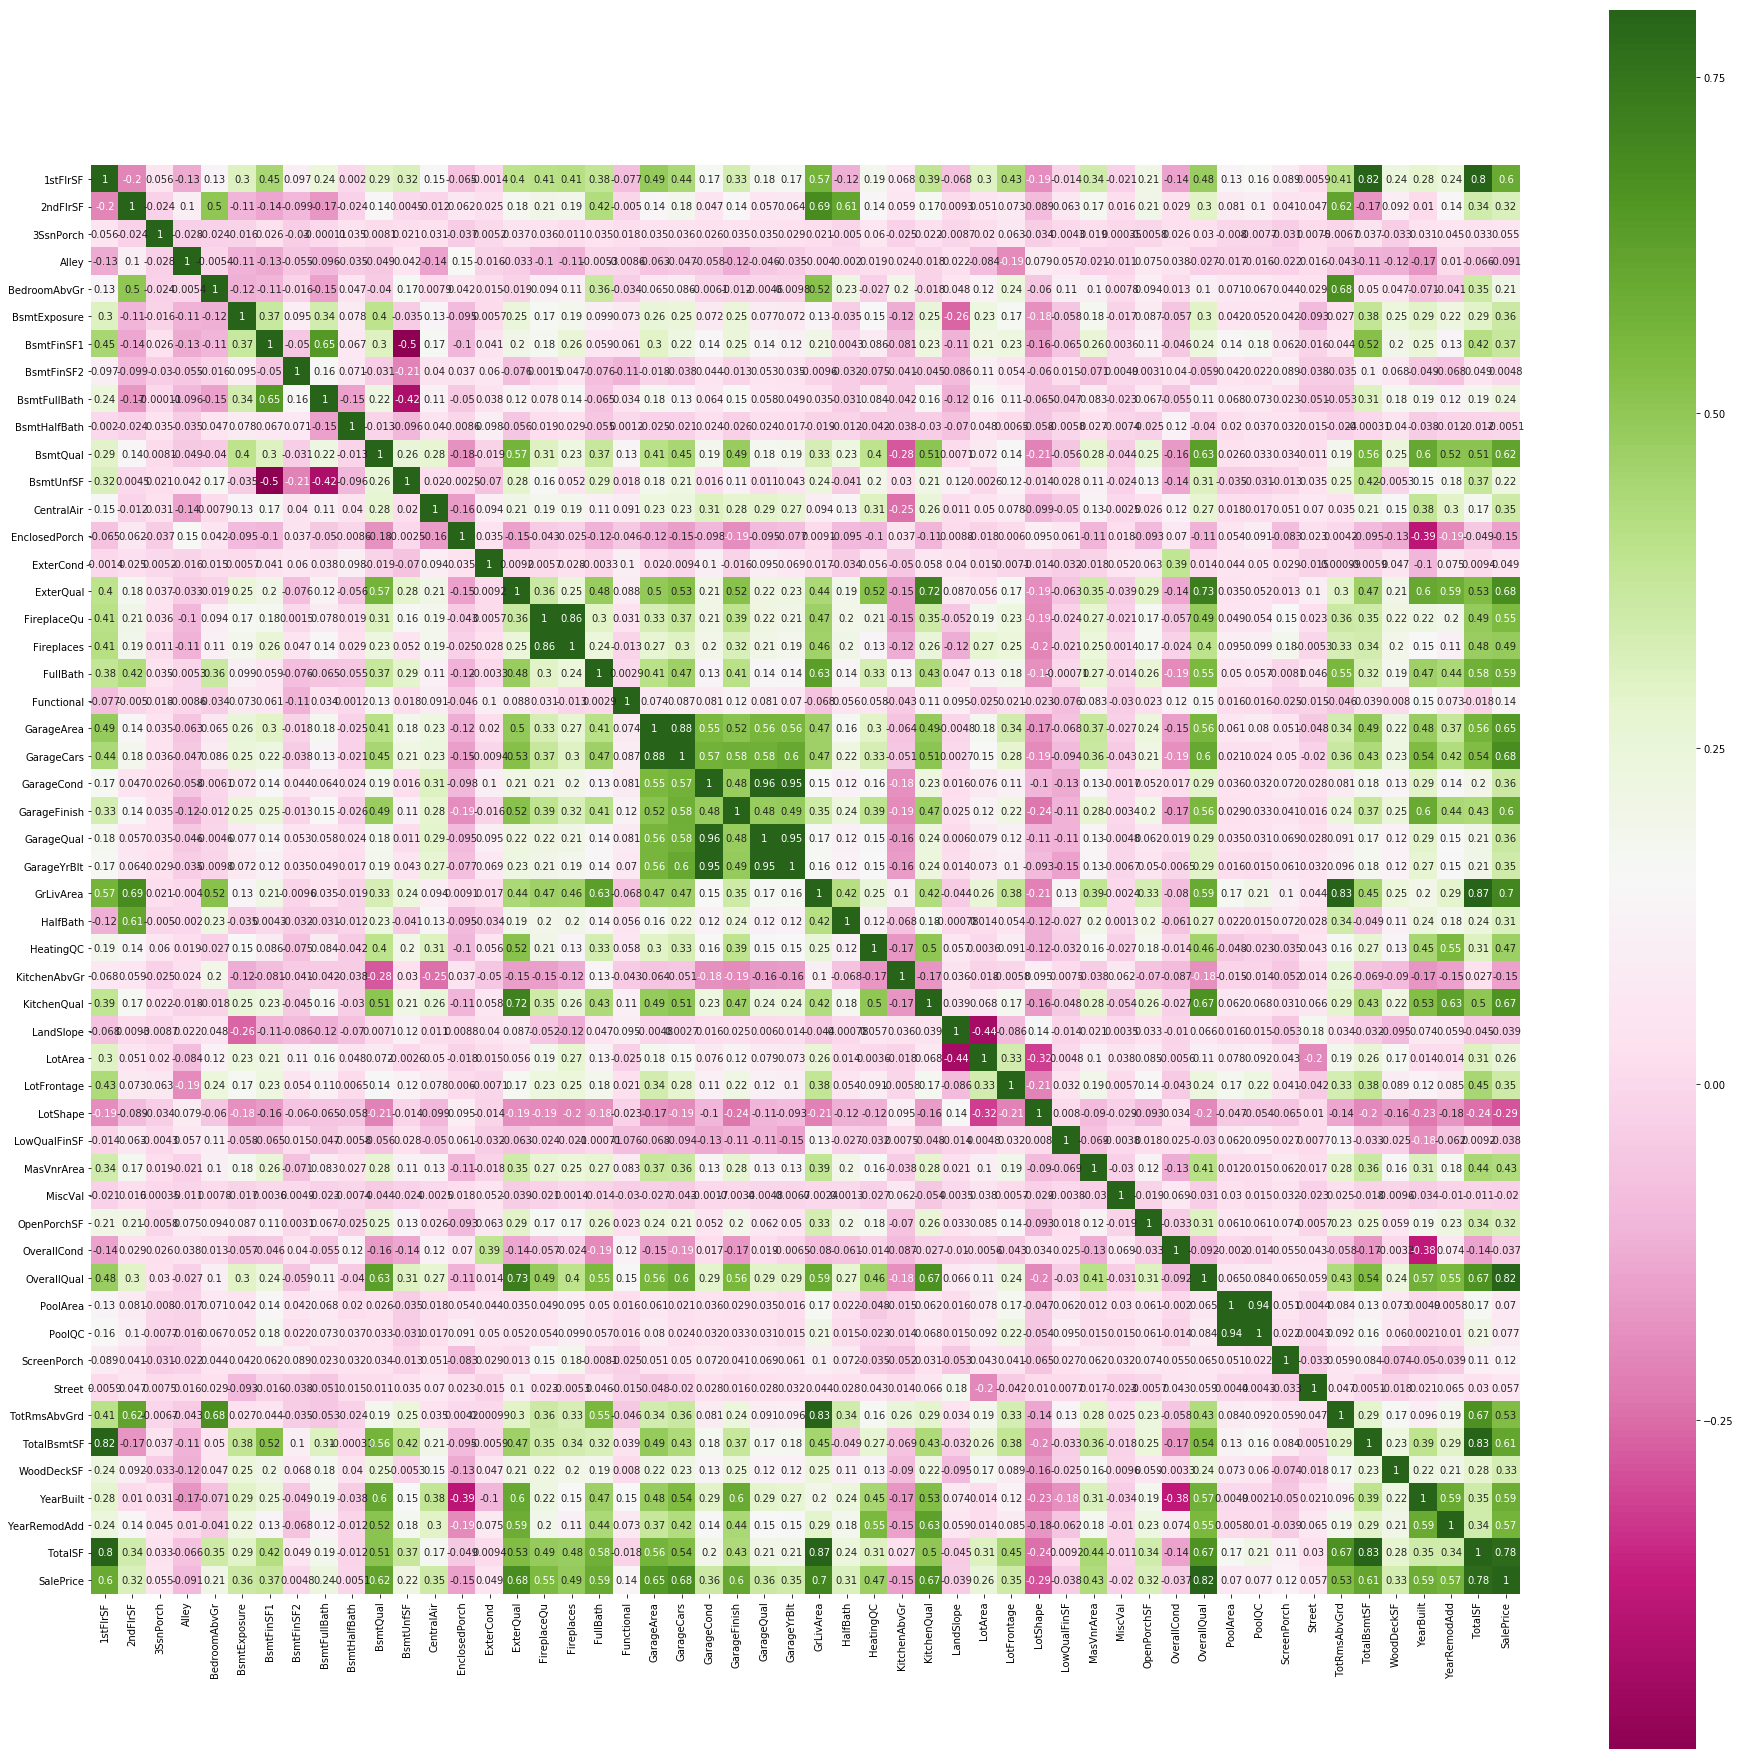

In [88]:
# subset the original dataframe by the train mask created earlier and add SalePrice
numerical_heatmap = all_data[:ntrain]
numerical_heatmap['SalePrice'] = df_train['SalePrice']

# plot heatmap of correlation values
corrmat = numerical_heatmap.corr()
f, ax = plt.subplots(figsize=(32, 32))
sns.heatmap(corrmat, vmax=.8, square=True, cmap="PiYG", annot=True);

#### Detect the presence of outliers and prepare the dataframe for modeling

Regplots were used to identify potential outliers for all features that were correlated more than 0.30 with SalePrice. This was done in order to ensure that outliers present in the top correlated variables would not skew the models that will be run on the dataframe. Dummy variables were generated for all remaining categorical features in the dataframe and it was split into train and test subsets using the train and test masks created previously. Finally all outliers were dropped and the shape of train and test was checked to ensure that it matches (important for the running of models)

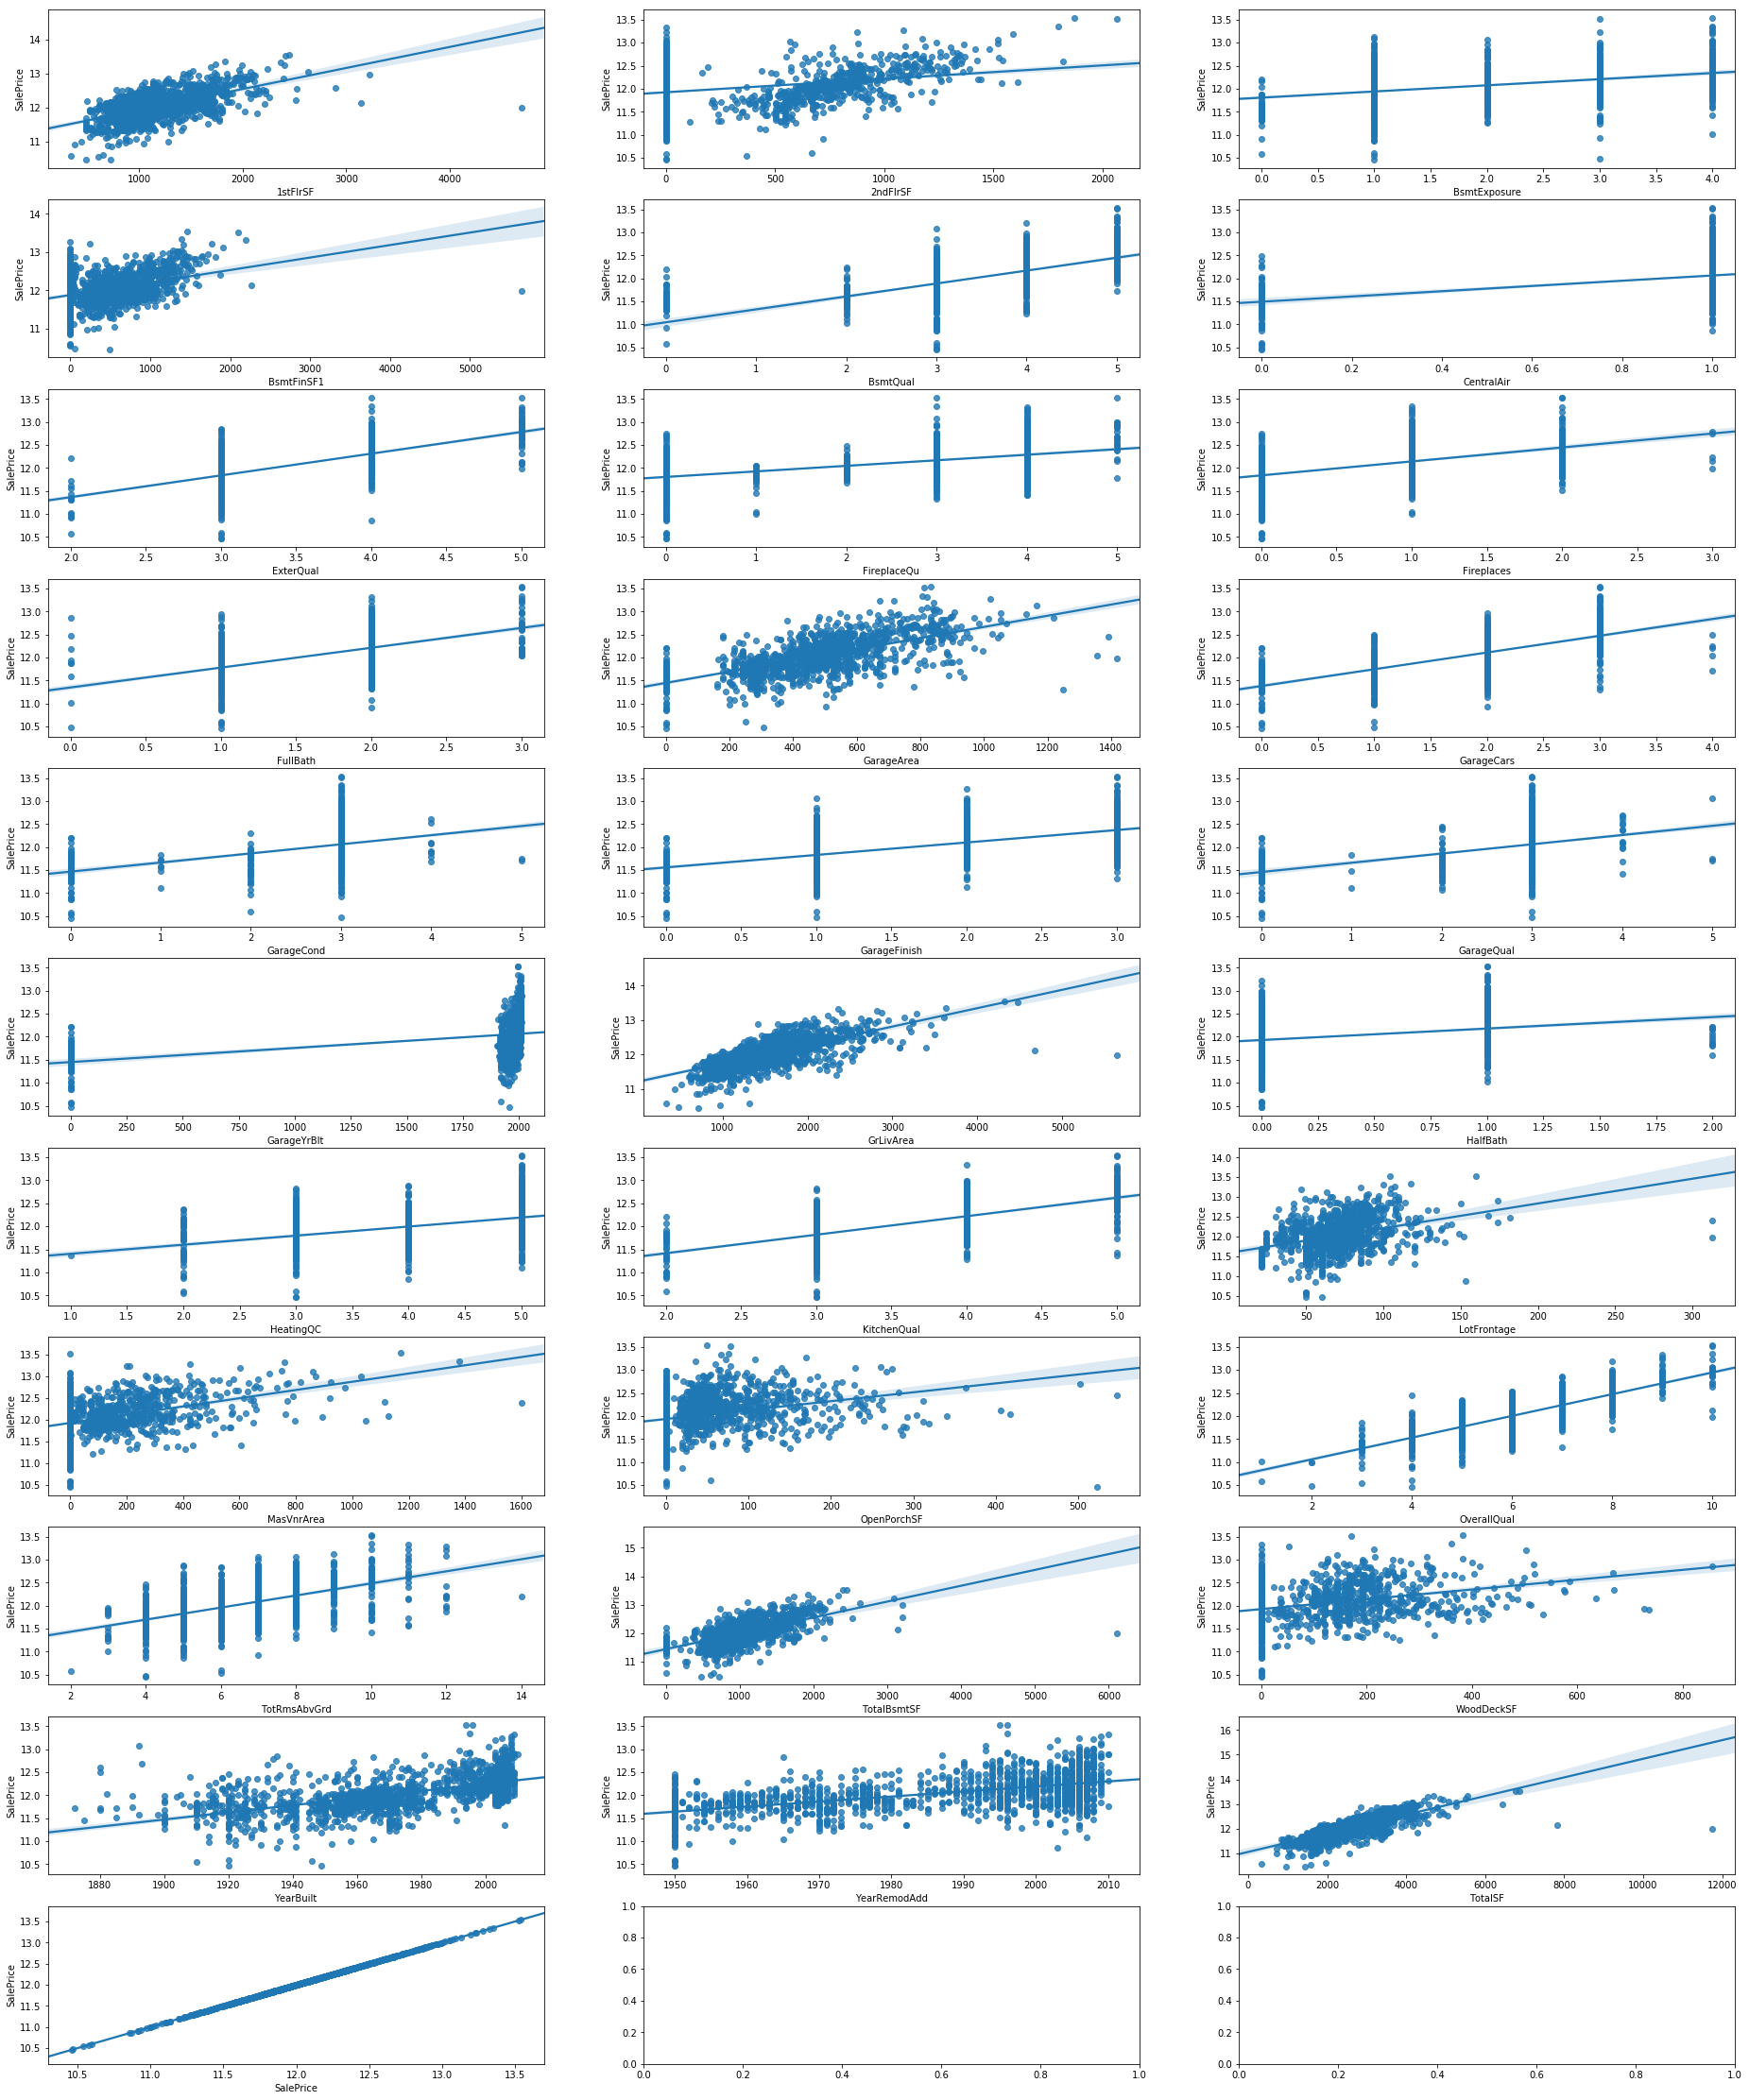

In [89]:
outlier_detection(corrmat=corrmat, correlator='SalePrice', corr_score=0.30, df=all_data, train_df=df_train, ncols=3)

In [90]:
all_data = pd.get_dummies(all_data)
print(all_data.shape)

(2919, 276)


In [91]:
train = all_data[:ntrain]
print(train.shape)
test = all_data[ntrain:]
print(train.shape)

(1460, 276)
(1460, 276)


In [92]:
train = all_data[:ntrain]
train['SalePrice'] = df_train['SalePrice']

# outliers were dropped using the previous graphs as visual aids for value criteria
train = train.drop(train[(train['1stFlrSF']>4000) & (df_train['SalePrice']<13)].index)
train = train.drop(train[(train['BsmtFinSF1']>4000) & (df_train['SalePrice']<13)].index)
train = train.drop(train[(train['GarageArea']>1220) & (df_train['SalePrice']<13)].index)
train = train.drop(train[(train['GrLivArea']>4000) & (df_train['SalePrice']<13)].index)
train = train.drop(train[(train['LotFrontage']>300) & (df_train['SalePrice']<13)].index)
train = train.drop(train[(train['OpenPorchSF']>500) & (df_train['SalePrice']<11)].index)
train = train.drop(train[(train['TotalBsmtSF']>6000) & (df_train['SalePrice']<13)].index)
y_train = train.SalePrice.values

# SalePrice was dropped from the train data as it is the response variable
train = train.drop(['SalePrice'], axis=1)
print(train.shape)
print(y_train.shape)

(1453, 276)
(1453,)


## 5. Modeling

#### Importing the necessary librairies for modeling and scoring

In [93]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge, BayesianRidge
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import optuna

#### Creating a cross-validation RMSLE scoring function

1. The *rmsle_cv* function gets the RMSLE score for a given pipeline object created for the purpose of modeling. It provides an cross validated estimate of the accuracy of the model based on the training dataset

In [94]:
#Cross-Validation function for specified number of folds
n_folds = 5 
def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(train.values)
    rmse= np.sqrt(-cross_val_score(model, train.values, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

2. The *objective* function acts as a hyperparameter tuner using the optuna package. This function needs to be re-defined everytime that it is used for a differnt model as the hyperparameters vary from model to model

#### Initial Lasso Modeling (Feature removal)

We initially used a Lasso Regression model on our data as it provides feature selection as a part of the model. We found it more accurate to use a lasso model to perform feature selection than manually removing features ourselves

This is the aformentioned objective hyperparameter tuning function

In [120]:
# Define an objective function to be minimized.
def objective(trial):

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    alpha = trial.suggest_loguniform('alpha', 1e-10, 1)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True,False])
    normalize=trial.suggest_categorical('normalize', [True,False])
    precompute=trial.suggest_categorical('precompute', [True,False])
    max_iter=trial.suggest_int('max_iter', 1000, 10000)
    tol=trial.suggest_loguniform('tol', 1e-10, 1)
    warm_start=trial.suggest_categorical('warm_start', [True,False])
    positive=trial.suggest_categorical('positive', [True,False])
    random_state=trial.suggest_int('random_state', 1, 10)
    selection=trial.suggest_categorical('selection', ['cyclic','random'])
    
    # create a variable containing the model and a set of selected hyperparameter values
    classifier_obj = Lasso(alpha=alpha,
                           fit_intercept=fit_intercept,
                           normalize=normalize,
                           precompute=precompute,
                           max_iter=max_iter,
                           tol=tol,
                           warm_start=warm_start,
                           positive=positive,
                           random_state=random_state,
                           selection=selection)

    # define x and y variables
    x, y = train,y_train
    
    # check cross validation score of the model based on x and y values
    score = cross_val_score(classifier_obj, x, y)
    accuracy = score.mean()
    
    # A objective value linked with the Trial object.
    return 1.0 - accuracy  

# Create a new study and invoke optimization of the objective function
study = optuna.create_study() 
study.optimize(objective, n_trials=1000)

[I 2019-05-30 19:15:42,100] Finished trial#0 resulted in value: 4.977373688018314. Current best value is 4.977373688018314 with parameters: {'alpha': 0.022436904714516124, 'fit_intercept': False, 'normalize': False, 'precompute': True, 'max_iter': 2811, 'tol': 0.049720364297449776, 'warm_start': False, 'positive': False, 'random_state': 2, 'selection': 'cyclic'}.
[I 2019-05-30 19:15:42,282] Finished trial#1 resulted in value: 0.3777888661856942. Current best value is 0.3777888661856942 with parameters: {'alpha': 1.9254708593337028e-09, 'fit_intercept': False, 'normalize': True, 'precompute': True, 'max_iter': 9296, 'tol': 0.0001381603924571197, 'warm_start': False, 'positive': True, 'random_state': 8, 'selection': 'random'}.
[I 2019-05-30 19:15:42,400] Finished trial#2 resulted in value: 0.13132568983041581. Current best value is 0.13132568983041581 with parameters: {'alpha': 3.929754553467184e-08, 'fit_intercept': True, 'normalize': False, 'precompute': True, 'max_iter': 3174, 'tol': 

In [121]:
# used to print the optimal hyperparameters found by the objective function
study.best_params

{'alpha': 0.00015658232856827567,
 'fit_intercept': True,
 'normalize': True,
 'precompute': False,
 'max_iter': 7980,
 'tol': 1.3875503185470412e-08,
 'warm_start': True,
 'positive': False,
 'random_state': 4,
 'selection': 'cyclic'}

In [95]:
# run the model using the the optimised hyperparameters
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.00015658232856827567,
                                            fit_intercept=True,
                                            normalize=True,
                                            precompute=False,
                                            max_iter=7980,
                                            tol=1.3875503185470412e-08,
                                            warm_start=True,
                                            positive=False,
                                            random_state=4,
                                            selection='cyclic'))

In [96]:
# check the cross-validation score of the model from the train data
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1104 (0.0053)



We then created a second, separate, lasso model (using the optimised hyperparameters) to subset the original dataframe with

In [97]:
# scale the data using RobustScaler then fit the model to our dataframe
scaler = RobustScaler()
train2 = scaler.fit_transform(train)
lasso2 = Lasso(alpha=0.00015858982133047102,
               fit_intercept=True,
               normalize=True,
               precompute=False,
               max_iter=6210,
               tol=2.0817972909900167e-10,
               warm_start=False,
               positive=False,
               random_state=2,
               selection='cyclic')
lasso2.fit(train, y_train)

# get coeffecients from the lasso model and use them to remove all columns that have a coeffecient of 0
coeff = pd.DataFrame(lasso2.coef_, all_data.columns, columns=['Coefficient']).reset_index()
Cols_to_remove = coeff['Coefficient'] == 0 
Cols_to_remove = coeff[Cols_to_remove]
Cols_to_remove = list(Cols_to_remove['index'])
all_data = all_data.drop(Cols_to_remove, axis=1)

Check train and test size

In [98]:
train = all_data[:ntrain]
print(train.shape)
test = all_data[ntrain:]
print(train.shape)

(1460, 65)
(1460, 65)


Drop outliers as a new dataframe has been created

In [99]:
train = all_data[:ntrain]
train['SalePrice'] = df_train['SalePrice']
#train = train.drop(train[(train['1stFlrSF']>4000) & (df_train['SalePrice']<13)].index)
train = train.drop(train[(train['BsmtFinSF1']>4000) & (df_train['SalePrice']<13)].index)
train = train.drop(train[(train['GarageArea']>1220) & (df_train['SalePrice']<13)].index)
train = train.drop(train[(train['GrLivArea']>4000) & (df_train['SalePrice']<13)].index)
train = train.drop(train[(train['LotFrontage']>300) & (df_train['SalePrice']<13)].index)
train = train.drop(train[(train['OpenPorchSF']>500) & (df_train['SalePrice']<11)].index)
#train = train.drop(train[(train['TotalBsmtSF']>6000) & (df_train['SalePrice']<13)].index)
y_train = train.SalePrice.values
train = train.drop(['SalePrice'], axis=1)
print(train.shape)
print(y_train.shape)

(1453, 65)
(1453,)


#### Second Lasso Modeling (Prediction)

We performed a second lasso modeling process on the dataframe that has had feature selection performed on it 

In [127]:
# Define an objective function to be minimized.
def objective(trial):

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    alpha = trial.suggest_loguniform('alpha', 1e-10, 1)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True,False])
    normalize=trial.suggest_categorical('normalize', [True,False])
    precompute=trial.suggest_categorical('precompute', [True,False])
    max_iter=trial.suggest_int('max_iter', 1000, 10000)
    tol=trial.suggest_loguniform('tol', 1e-10, 1)
    warm_start=trial.suggest_categorical('warm_start', [True,False])
    positive=trial.suggest_categorical('positive', [True,False])
    random_state=trial.suggest_int('random_state', 1, 10)
    selection=trial.suggest_categorical('selection', ['cyclic','random'])
    
    # create a variable containing the model and a set of selected hyperparameter values
    classifier_obj = Lasso(alpha=alpha,
                           fit_intercept=fit_intercept,
                           normalize=normalize,
                           precompute=precompute,
                           max_iter=max_iter,
                           tol=tol,
                           warm_start=warm_start,
                           positive=positive,
                           random_state=random_state,
                           selection=selection)

    # define x and y variables
    x, y = train,y_train
    
     # check cross validation score of the model based on x and y values
    score = cross_val_score(classifier_obj, x, y)
    accuracy = score.mean()
    
    # A objective value linked with the Trial object.
    return 1.0 - accuracy

# Create a new study and invoke optimization of the objective function
study = optuna.create_study() 
study.optimize(objective, n_trials=1000)

[I 2019-05-30 19:45:46,618] Finished trial#0 resulted in value: 1.0011289613986278. Current best value is 1.0011289613986278 with parameters: {'alpha': 0.9150265966060637, 'fit_intercept': True, 'normalize': True, 'precompute': True, 'max_iter': 9474, 'tol': 0.0035782113872199926, 'warm_start': False, 'positive': False, 'random_state': 7, 'selection': 'random'}.
[I 2019-05-30 19:45:46,736] Finished trial#1 resulted in value: 0.08618332139734586. Current best value is 0.08618332139734586 with parameters: {'alpha': 0.0017376377432025225, 'fit_intercept': True, 'normalize': False, 'precompute': False, 'max_iter': 7801, 'tol': 0.0011870681760635087, 'warm_start': True, 'positive': True, 'random_state': 3, 'selection': 'cyclic'}.
[I 2019-05-30 19:45:46,838] Finished trial#2 resulted in value: 0.08429986327694794. Current best value is 0.08429986327694794 with parameters: {'alpha': 0.00031792522397071946, 'fit_intercept': True, 'normalize': True, 'precompute': False, 'max_iter': 6375, 'tol':

In [128]:
# used to print the optimal hyperparameters found by the objective function
study.best_params

{'alpha': 0.00016237068913803153,
 'fit_intercept': True,
 'normalize': False,
 'precompute': False,
 'max_iter': 6971,
 'tol': 0.030090797817720078,
 'warm_start': True,
 'positive': False,
 'random_state': 6,
 'selection': 'cyclic'}

In [100]:
# run the model using the the optimised hyperparameters
lasso = make_pipeline(RobustScaler(), Lasso(alpha=0.00016237068913803153,
                                            fit_intercept=True,
                                            normalize=False,
                                            precompute=False,
                                            max_iter=6971,
                                            tol=0.030090797817720078,
                                            warm_start=True,
                                            positive=False,
                                            random_state=6,
                                            selection='cyclic'))

In [101]:
# check the cross-validation score of the model from the train data
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1058 (0.0051)



In [102]:
# scale the data using RobustScaler then fit the model to our dataframe
scaler = RobustScaler()
train2 = scaler.fit_transform(train)
lasso2 = Lasso(alpha=0.00016237068913803153,
               fit_intercept=True,
               normalize=False,
               precompute=False,
               max_iter=6971,
               tol=0.030090797817720078,
               warm_start=True,
               positive=False,
               random_state=2,
               selection='cyclic')
lasso2.fit(train, y_train)

# get coeffecients from the lasso model and use them to remove all columns that have a coeffecient of 0
coeff = pd.DataFrame(lasso2.coef_, all_data.columns, columns=['Coefficient']).reset_index()
#Cols_to_remove = coeff['Coefficient'] == 0 
#Cols_to_remove = coeff[Cols_to_remove]
#Cols_to_remove = list(Cols_to_remove['index'])
#all_data = all_data.drop(Cols_to_remove, axis=1)

'\n# Plot the crashes where alcohol was involved\nsns.set_color_codes("muted")\nsns.barplot(x="alcohol", y="abbrev", data=crashes,\n            label="Alcohol-involved", color="b")\n\n# Add a legend and informative axis label\nax.legend(ncol=2, loc="lower right", frameon=True)\nax.set(xlim=(0, 24), ylabel="",\n       xlabel="Automobile collisions per billion miles")\nsns.despine(left=True, bottom=True)\n'

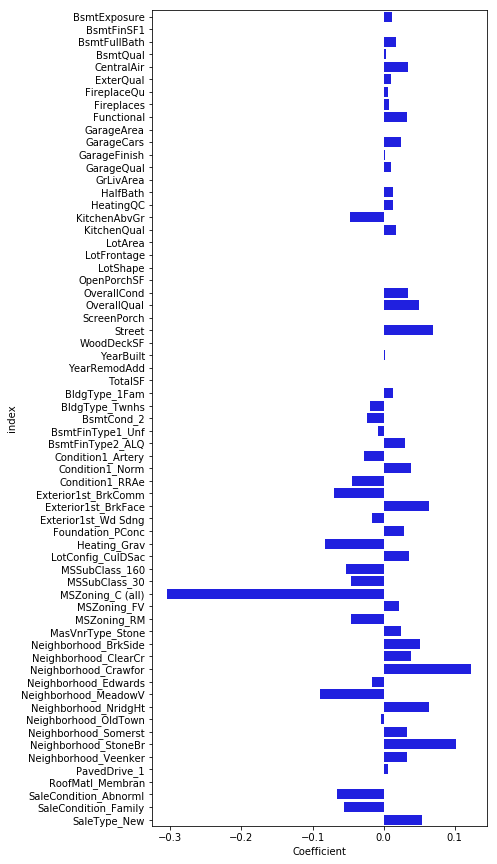

In [104]:
# Initialize the matplotlib figure
f, ax = plt.subplots(figsize=(6, 15))

# Plot the total crashes
sns.barplot(x='Coefficient', y='index', data=coeff,
            label="Total", color="b")

'''
# Plot the crashes where alcohol was involved
sns.set_color_codes("muted")
sns.barplot(x="alcohol", y="abbrev", data=crashes,
            label="Alcohol-involved", color="b")

# Add a legend and informative axis label
ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 24), ylabel="",
       xlabel="Automobile collisions per billion miles")
sns.despine(left=True, bottom=True)
'''

#### Elastic Net Modeling

In [131]:
# Define an objective function to be minimized.
def objective(trial):

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    alpha = trial.suggest_loguniform('alpha', 1e-10, 1)
    l1_ratio = trial.suggest_uniform('l1_ratio', 0.0, 1.0)
    fit_intercept = trial.suggest_categorical('fit_intercept', [True,False])
    normalize=trial.suggest_categorical('normalize', [True,False])
    precompute=trial.suggest_categorical('precompute', [True,False])
    max_iter=trial.suggest_int('max_iter', 1000, 10000)
    tol=trial.suggest_loguniform('tol', 1e-10, 1)
    warm_start=trial.suggest_categorical('warm_start', [True,False])
    positive=trial.suggest_categorical('positive', [True,False])
    random_state=trial.suggest_int('random_state', 1, 10)
    selection=trial.suggest_categorical('selection', ['cyclic','random'])
    
    # create a variable containing the model and a set of selected hyperparameter values
    classifier_obj = ElasticNet(alpha=alpha,
                                l1_ratio=l1_ratio,
                                fit_intercept=fit_intercept,
                                normalize=normalize,
                                precompute=precompute,
                                max_iter=max_iter,
                                tol=tol,
                                warm_start=warm_start,
                                positive=positive,
                                random_state=random_state,
                                selection=selection)

    # define x and y variables
    x, y = train,y_train
    
     # check cross validation score of the model based on x and y values
    score = cross_val_score(classifier_obj, x, y)
    accuracy = score.mean()
    
    # A objective value linked with the Trial object.
    return 1.0 - accuracy

# Create a new study and invoke optimization of the objective function
study = optuna.create_study() 
study.optimize(objective, n_trials=1000)

[I 2019-05-30 20:03:57,965] Finished trial#0 resulted in value: 0.08700576473736465. Current best value is 0.08700576473736465 with parameters: {'alpha': 3.2846152476690413e-08, 'l1_ratio': 0.9353403460945926, 'fit_intercept': False, 'normalize': False, 'precompute': False, 'max_iter': 5175, 'tol': 1.2426501945587117e-09, 'warm_start': True, 'positive': True, 'random_state': 8, 'selection': 'cyclic'}.
[I 2019-05-30 20:03:58,085] Finished trial#1 resulted in value: 0.07231289835904409. Current best value is 0.07231289835904409 with parameters: {'alpha': 5.708008195349784e-09, 'l1_ratio': 0.8632392187338381, 'fit_intercept': True, 'normalize': False, 'precompute': True, 'max_iter': 1485, 'tol': 3.104122646102798e-05, 'warm_start': False, 'positive': False, 'random_state': 5, 'selection': 'random'}.
[I 2019-05-30 20:03:58,340] Finished trial#2 resulted in value: 0.08826952976088709. Current best value is 0.07231289835904409 with parameters: {'alpha': 5.708008195349784e-09, 'l1_ratio': 0.8

In [132]:
# used to print the optimal hyperparameters found by the objective function
study.best_params

{'alpha': 0.002191387975976419,
 'l1_ratio': 1.3881334697356945e-05,
 'fit_intercept': True,
 'normalize': False,
 'precompute': False,
 'max_iter': 2590,
 'tol': 0.0014159696901962274,
 'warm_start': False,
 'positive': False,
 'random_state': 9,
 'selection': 'cyclic'}

In [134]:
# run the model using the the optimised hyperparameters
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.002191387975976419,
                                                l1_ratio=1.3881334697356945e-05,
                                                fit_intercept=True,
                                                normalize=False,
                                                precompute=False,
                                                max_iter=2590,
                                                tol=0.0014159696901962274,
                                                warm_start=False,
                                                positive=False,
                                                random_state=9,
                                                selection='cyclic'))

In [135]:
# check the cross-validation score of the model from the train data
score = rmsle_cv(ENet)
print("\nENet score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


ENet score: 0.1055 (0.0049)



#### Bayesian Ridge Modeling

In [136]:
# Define an objective function to be minimized.
def objective(trial):

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    n_iter=trial.suggest_int('n_iter', 1, 1000)
    tol=trial.suggest_loguniform('tol', 1e-10, 1)
    alpha_1=trial.suggest_loguniform('alpha1', 1e-10, 10)
    alpha_2=trial.suggest_loguniform('alpha2', 1e-10, 10)
    lambda_1=trial.suggest_loguniform('lambda_1', 1e-10, 10)
    lambda_2=trial.suggest_loguniform('lambda_2', 1e-10, 10)
    compute_score=trial.suggest_categorical('compute_score', [True,False])
    fit_intercept=trial.suggest_categorical('fit_intercept', [True,False])
    normalize=trial.suggest_categorical('normalize', [True,False])
    verbose=trial.suggest_categorical('verbose', [True,False])
    
    # create a variable containing the model and a set of selected hyperparameter values
    classifier_obj = BayesianRidge(n_iter=n_iter,
                                   tol=tol,
                                   alpha_1=alpha_1,
                                   alpha_2=alpha_2,
                                   lambda_1=lambda_1,
                                   lambda_2=lambda_2,
                                   compute_score=compute_score,
                                   fit_intercept=fit_intercept,
                                   normalize=normalize,
                                   verbose=verbose)

    # define x and y variables
    x, y = train,y_train
    
     # check cross validation score of the model based on x and y values
    score = cross_val_score(classifier_obj, x, y)
    accuracy = score.mean()
    
    # A objective value linked with the Trial object.
    return 1.0 - accuracy

# Create a new study and invoke optimization of the objective function
study = optuna.create_study() 
study.optimize(objective, n_trials=1000)

[I 2019-05-30 20:26:43,870] Finished trial#0 resulted in value: 0.07179798789410186. Current best value is 0.07179798789410186 with parameters: {'n_iter': 128, 'tol': 4.587294080971573e-09, 'alpha1': 8.9629615737292e-07, 'alpha2': 1.0433070664131758, 'lambda_1': 3.816303464633984e-05, 'lambda_2': 2.7109613186514235e-08, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.
[I 2019-05-30 20:26:43,986] Finished trial#1 resulted in value: 0.07199581236087871. Current best value is 0.07179798789410186 with parameters: {'n_iter': 128, 'tol': 4.587294080971573e-09, 'alpha1': 8.9629615737292e-07, 'alpha2': 1.0433070664131758, 'lambda_1': 3.816303464633984e-05, 'lambda_2': 2.7109613186514235e-08, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  4  iterations


[I 2019-05-30 20:26:44,137] Finished trial#2 resulted in value: 0.07200332882076266. Current best value is 0.07179798789410186 with parameters: {'n_iter': 128, 'tol': 4.587294080971573e-09, 'alpha1': 8.9629615737292e-07, 'alpha2': 1.0433070664131758, 'lambda_1': 3.816303464633984e-05, 'lambda_2': 2.7109613186514235e-08, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.
[I 2019-05-30 20:26:44,260] Finished trial#3 resulted in value: 0.07134535659487806. Current best value is 0.07134535659487806 with parameters: {'n_iter': 139, 'tol': 0.00011153051972995582, 'alpha1': 6.291428858123981e-08, 'alpha2': 0.0010387626168401264, 'lambda_1': 1.615073326752167e-08, 'lambda_2': 8.355365057918994e-06, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:26:44,406] Finished trial#4 resulted in value: 0.07203759160440193. Current best value is 0.07134535659487806 with parameters: {'n_iter': 139, 'tol': 0.00011153051972995582, 'alpha1': 6.291428858123981e-08, 'alpha2': 0.0010387626168401264, 'lambda_1': 1.615073326752167e-08, 'lambda_2': 8.355365057918994e-06, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.
[I 2019-05-30 20:26:44,537] Finished trial#5 resulted in value: 0.07685134336366284. Current best value is 0.07134535659487806 with parameters: {'n_iter': 139, 'tol': 0.00011153051972995582, 'alpha1': 6.291428858123981e-08, 'alpha2': 0.0010387626168401264, 'lambda_1': 1.615073326752167e-08, 'lambda_2': 8.355365057918994e-06, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:26:44,694] Finished trial#6 resulted in value: 0.07086189739271465. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:26:44,823] Finished trial#7 resulted in value: 0.07134550331795853. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:26:44,959] Finished trial#8 resulted in value: 0.07746254087824112. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.01717585326030677

Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:26:45,258] Finished trial#10 resulted in value: 0.07091924812106731. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:26:45,438] Finished trial#11 resulted in value: 0.071318689007137. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:26:45,605] Finished trial#12 resulted in value: 0.07619068100583293. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations


[I 2019-05-30 20:26:45,782] Finished trial#13 resulted in value: 0.0710591358143432. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  20  iterations
Convergence after  18  iterations
Convergence after  27  iterations


[I 2019-05-30 20:26:45,961] Finished trial#14 resulted in value: 0.07678245561818497. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  18  iterations
Convergence after  17  iterations
Convergence after  23  iterations


[I 2019-05-30 20:26:46,145] Finished trial#15 resulted in value: 0.07134543637911805. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  6  iterations


[I 2019-05-30 20:26:46,320] Finished trial#16 resulted in value: 0.07133504093123377. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations


[I 2019-05-30 20:26:46,502] Finished trial#17 resulted in value: 0.07102867136400015. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  1  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:26:46,688] Finished trial#18 resulted in value: 0.07217776236967577. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  10  iterations
Convergence after  9  iterations
Convergence after  13  iterations


[I 2019-05-30 20:26:46,867] Finished trial#19 resulted in value: 0.07177477674759747. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:26:47,038] Finished trial#20 resulted in value: 0.0713595351273949. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  11  iterations


[I 2019-05-30 20:26:47,228] Finished trial#21 resulted in value: 0.07133789491370368. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:26:47,399] Finished trial#22 resulted in value: 0.07111327828299452. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  6  iterations


[I 2019-05-30 20:26:47,606] Finished trial#23 resulted in value: 0.07114055113191575. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  14  iterations
Convergence after  14  iterations
Convergence after  19  iterations


[I 2019-05-30 20:26:47,803] Finished trial#24 resulted in value: 0.07627599677490637. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:26:48,006] Finished trial#25 resulted in value: 0.07207175263712895. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  7  iterations
Convergence after  7  iterations
Convergence after  9  iterations


[I 2019-05-30 20:26:48,218] Finished trial#26 resulted in value: 0.0713378221375871. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations


[I 2019-05-30 20:26:48,441] Finished trial#27 resulted in value: 0.07180580293135475. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  3  iterations


[I 2019-05-30 20:26:48,689] Finished trial#28 resulted in value: 0.07107322988116316. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  8  iterations
Convergence after  9  iterations
Convergence after  12  iterations


[I 2019-05-30 20:26:48,902] Finished trial#29 resulted in value: 0.07614662491554636. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:26:49,100] Finished trial#30 resulted in value: 0.07378741958424195. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  7  iterations
Convergence after  7  iterations
Convergence after  6  iterations


[I 2019-05-30 20:26:49,305] Finished trial#31 resulted in value: 0.07200332964935141. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:26:49,494] Finished trial#32 resulted in value: 0.0712939549107724. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  4  iterations


[I 2019-05-30 20:26:49,713] Finished trial#33 resulted in value: 0.07200329759960022. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:26:49,915] Finished trial#34 resulted in value: 0.07134181744148338. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  12  iterations
Convergence after  11  iterations
Convergence after  16  iterations


[I 2019-05-30 20:26:50,138] Finished trial#35 resulted in value: 0.07684967427904077. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:26:50,330] Finished trial#36 resulted in value: 0.07199646857313413. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:26:50,557] Finished trial#37 resulted in value: 0.07182856537285176. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:26:50,768] Finished trial#38 resulted in value: 0.07686810657350451. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:26:50,988] Finished trial#39 resulted in value: 0.07107175596057136. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  10  iterations
Convergence after  9  iterations
Convergence after  12  iterations


[I 2019-05-30 20:26:51,211] Finished trial#40 resulted in value: 0.07132651640956722. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:26:51,427] Finished trial#41 resulted in value: 0.07685105297135097. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  4  iterations


[I 2019-05-30 20:26:51,673] Finished trial#42 resulted in value: 0.07200787983266499. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  3  iterations


[I 2019-05-30 20:26:51,906] Finished trial#43 resulted in value: 0.07104806752466308. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:26:52,139] Finished trial#44 resulted in value: 0.07709847740098885. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:26:52,363] Finished trial#45 resulted in value: 0.07134529844987225. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:26:52,600] Finished trial#46 resulted in value: 0.07200332874037674. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  1  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:26:52,840] Finished trial#47 resulted in value: 0.07621358272605583. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:26:53,068] Finished trial#48 resulted in value: 0.07218281581926433. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:26:53,288] Finished trial#49 resulted in value: 0.07147768005590416. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:26:53,543] Finished trial#50 resulted in value: 0.07086517624155653. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  19  iterations
Convergence after  18  iterations
Convergence after  25  iterations


[I 2019-05-30 20:26:53,790] Finished trial#51 resulted in value: 0.07140086012650959. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:26:54,049] Finished trial#52 resulted in value: 0.07623216297042046. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:26:54,294] Finished trial#53 resulted in value: 0.07088097014102435. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  11  iterations
Convergence after  10  iterations
Convergence after  14  iterations


[I 2019-05-30 20:26:54,549] Finished trial#54 resulted in value: 0.07135415480078044. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:26:54,778] Finished trial#55 resulted in value: 0.07136678803684482. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  17  iterations
Convergence after  16  iterations
Convergence after  22  iterations


[I 2019-05-30 20:26:55,049] Finished trial#56 resulted in value: 0.07153943463344914. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  3  iterations


[I 2019-05-30 20:26:55,292] Finished trial#57 resulted in value: 0.07716583167210989. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  8  iterations
Convergence after  7  iterations
Convergence after  10  iterations


[I 2019-05-30 20:26:55,548] Finished trial#58 resulted in value: 0.07129890207643674. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  16  iterations
Convergence after  15  iterations
Convergence after  22  iterations


[I 2019-05-30 20:26:55,800] Finished trial#59 resulted in value: 0.0729402903984967. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:26:56,046] Finished trial#60 resulted in value: 0.07123200730566992. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:26:56,300] Finished trial#61 resulted in value: 0.07613193462517243. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  4  iterations


[I 2019-05-30 20:26:56,562] Finished trial#62 resulted in value: 0.0720032706800896. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:26:56,818] Finished trial#63 resulted in value: 0.07126363917602774. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  7  iterations
Convergence after  7  iterations
Convergence after  9  iterations


[I 2019-05-30 20:26:57,100] Finished trial#64 resulted in value: 0.07135416847685949. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  7  iterations
Convergence after  7  iterations
Convergence after  10  iterations


[I 2019-05-30 20:26:57,364] Finished trial#65 resulted in value: 0.07089632958842385. Current best value is 0.07086189739271465 with parameters: {'n_iter': 666, 'tol': 0.017175853260306777, 'alpha1': 3.729649198033571e-05, 'alpha2': 1.080306855856619e-08, 'lambda_1': 6.127756717006955e-09, 'lambda_2': 0.07130935360068244, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:26:57,627] Finished trial#66 resulted in value: 0.07086107250023144. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  7  iterations


[I 2019-05-30 20:26:57,892] Finished trial#67 resulted in value: 0.07103042821255856. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations


[I 2019-05-30 20:26:58,173] Finished trial#68 resulted in value: 0.07153844343097315. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:26:58,443] Finished trial#69 resulted in value: 0.07107816592846039. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:26:58,712] Finished trial#70 resulted in value: 0.07209866096095707. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  15  iterations
Convergence after  14  iterations
Convergence after  20  iterations


[I 2019-05-30 20:26:59,004] Finished trial#71 resulted in value: 0.0713393335954261. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  9  iterations
Convergence after  8  iterations
Convergence after  11  iterations


[I 2019-05-30 20:26:59,279] Finished trial#72 resulted in value: 0.07192104688715217. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:26:59,557] Finished trial#73 resulted in value: 0.07090798531854892. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  3  iterations


[I 2019-05-30 20:26:59,826] Finished trial#74 resulted in value: 0.07087290647607103. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations


[I 2019-05-30 20:27:00,107] Finished trial#75 resulted in value: 0.07177967883931136. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:27:00,374] Finished trial#76 resulted in value: 0.0711521572373407. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  13  iterations
Convergence after  12  iterations
Convergence after  18  iterations


[I 2019-05-30 20:27:00,662] Finished trial#77 resulted in value: 0.07683952182907172. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  2  iterations
Convergence after  4  iterations


[I 2019-05-30 20:27:00,942] Finished trial#78 resulted in value: 0.07144044399867011. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  25  iterations
Convergence after  23  iterations
Convergence after  32  iterations


[I 2019-05-30 20:27:01,232] Finished trial#79 resulted in value: 0.07124863146312166. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:27:01,496] Finished trial#80 resulted in value: 0.07086437941316348. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:27:01,757] Finished trial#81 resulted in value: 0.0763274651661714. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866

Convergence after  17  iterations
Convergence after  16  iterations
Convergence after  22  iterations


[I 2019-05-30 20:27:06,629] Finished trial#98 resulted in value: 0.07132623320072196. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  24  iterations
Convergence after  22  iterations
Convergence after  32  iterations


[I 2019-05-30 20:27:06,940] Finished trial#99 resulted in value: 0.0717128824666654. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:27:07,241] Finished trial#100 resulted in value: 0.07613144811343064. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:27:07,559] Finished trial#101 resulted in value: 0.07114862452480564. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  9  iterations
Convergence after  8  iterations
Convergence after  11  iterations


[I 2019-05-30 20:27:07,888] Finished trial#102 resulted in value: 0.07134398887098137. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  12  iterations
Convergence after  12  iterations
Convergence after  16  iterations


[I 2019-05-30 20:27:08,218] Finished trial#103 resulted in value: 0.07129313683387162. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:27:08,532] Finished trial#104 resulted in value: 0.07134316851256994. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  8  iterations
Convergence after  7  iterations
Convergence after  10  iterations


[I 2019-05-30 20:27:08,893] Finished trial#105 resulted in value: 0.07684380819854386. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  11  iterations


[I 2019-05-30 20:27:09,253] Finished trial#106 resulted in value: 0.07101499759198149. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:27:09,578] Finished trial#107 resulted in value: 0.07132557320550481. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:27:09,954] Finished trial#108 resulted in value: 0.07206974679746259. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:27:10,319] Finished trial#109 resulted in value: 0.07124233738877861. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  4  iterations


[I 2019-05-30 20:27:10,690] Finished trial#110 resulted in value: 0.071969021316027. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:27:11,043] Finished trial#111 resulted in value: 0.07616232456972094. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  7  iterations
Convergence after  9  iterations


[I 2019-05-30 20:27:11,415] Finished trial#112 resulted in value: 0.07103198943730993. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:27:11,772] Finished trial#113 resulted in value: 0.07140931866405775. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:27:12,179] Finished trial#114 resulted in value: 0.07134014597985916. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  10  iterations
Convergence after  10  iterations
Convergence after  13  iterations


[I 2019-05-30 20:27:12,598] Finished trial#115 resulted in value: 0.07111968008661851. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:27:12,995] Finished trial#116 resulted in value: 0.07624545392114468. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:27:13,371] Finished trial#117 resulted in value: 0.07149204944630361. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:27:13,744] Finished trial#118 resulted in value: 0.07128609052153934. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:27:14,088] Finished trial#119 resulted in value: 0.07086489303399468. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  13  iterations
Convergence after  12  iterations
Convergence after  17  iterations


[I 2019-05-30 20:27:14,476] Finished trial#120 resulted in value: 0.07130121679971879. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations


[I 2019-05-30 20:27:14,852] Finished trial#121 resulted in value: 0.07631543747472369. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:27:15,214] Finished trial#122 resulted in value: 0.07106793514857035. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  7  iterations
Convergence after  7  iterations
Convergence after  9  iterations


[I 2019-05-30 20:27:15,575] Finished trial#123 resulted in value: 0.07172425627297585. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:27:15,939] Finished trial#124 resulted in value: 0.0712991666995958. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  21  iterations
Convergence after  19  iterations
Convergence after  27  iterations


[I 2019-05-30 20:27:16,296] Finished trial#125 resulted in value: 0.07134550685341112. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:27:16,672] Finished trial#126 resulted in value: 0.0773331897906192. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  5  iterations
Convergence after  6  iterations


[I 2019-05-30 20:27:17,032] Finished trial#127 resulted in value: 0.07089701506754775. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  23  iterations
Convergence after  21  iterations
Convergence after  29  iterations


[I 2019-05-30 20:27:17,403] Finished trial#128 resulted in value: 0.0713459206705932. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:27:17,749] Finished trial#129 resulted in value: 0.07116714481497333. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:27:18,130] Finished trial#130 resulted in value: 0.07127749002645878. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:27:18,460] Finished trial#131 resulted in value: 0.07644721094457096. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  3  iterations


[I 2019-05-30 20:27:18,831] Finished trial#132 resulted in value: 0.0717746985027472. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  10  iterations
Convergence after  10  iterations
Convergence after  14  iterations


[I 2019-05-30 20:27:19,207] Finished trial#133 resulted in value: 0.07093953211357162. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:27:19,557] Finished trial#134 resulted in value: 0.07133239181179574. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:27:19,947] Finished trial#135 resulted in value: 0.07192106814579613. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:27:20,308] Finished trial#136 resulted in value: 0.0771833990122417. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  5  iterations
Convergence after  6  iterations


[I 2019-05-30 20:27:20,680] Finished trial#137 resulted in value: 0.0708882406430632. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:27:21,057] Finished trial#138 resulted in value: 0.07115899994321351. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:27:21,412] Finished trial#139 resulted in value: 0.07106195344977939. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:27:21,792] Finished trial#140 resulted in value: 0.0716268100908124. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:27:22,150] Finished trial#141 resulted in value: 0.07669142883076685. Current best value is 0.07086107250023144 with parameters: {'n_iter': 762, 'tol': 0.0001019491866157558, 'alpha1': 1.375878569062972e-05, 'alpha2': 0.007996831713847683, 'lambda_1': 2.9041948052748814e-06, 'lambda_2': 0.07723381072482553, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  7  iterations
Convergence after  7  iterations
Convergence after  9  iterations


[I 2019-05-30 20:27:22,520] Finished trial#142 resulted in value: 0.07085514007255223. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  4  iterations


[I 2019-05-30 20:27:22,897] Finished trial#143 resulted in value: 0.07214110357612402. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  23  iterations
Convergence after  21  iterations
Convergence after  30  iterations


[I 2019-05-30 20:27:23,285] Finished trial#144 resulted in value: 0.0713453908874726. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:27:23,698] Finished trial#145 resulted in value: 0.07087103338806067. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  13  iterations
Convergence after  13  iterations
Convergence after  18  iterations


[I 2019-05-30 20:27:24,086] Finished trial#146 resulted in value: 0.07109150268147724. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  14  iterations
Convergence after  13  iterations
Convergence after  18  iterations


[I 2019-05-30 20:27:24,486] Finished trial#147 resulted in value: 0.0711812495345101. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  11  iterations


[I 2019-05-30 20:27:24,875] Finished trial#148 resulted in value: 0.07092573713119021. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:27:25,277] Finished trial#149 resulted in value: 0.0713812905057215. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  6  iterations


[I 2019-05-30 20:27:25,666] Finished trial#150 resulted in value: 0.07109839138336138. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  11  iterations


[I 2019-05-30 20:27:26,059] Finished trial#151 resulted in value: 0.07096484320971486. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:27:26,456] Finished trial#152 resulted in value: 0.07087980436741137. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  18  iterations
Convergence after  16  iterations
Convergence after  23  iterations


[I 2019-05-30 20:27:26,868] Finished trial#153 resulted in value: 0.0713107944703637. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  11  iterations


[I 2019-05-30 20:27:27,273] Finished trial#154 resulted in value: 0.07127805570678347. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:27:27,689] Finished trial#155 resulted in value: 0.07086675639318418. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:27:28,084] Finished trial#156 resulted in value: 0.07099609045819333. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:27:28,490] Finished trial#157 resulted in value: 0.07110843179797399. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  12  iterations
Convergence after  11  iterations
Convergence after  15  iterations


[I 2019-05-30 20:27:28,908] Finished trial#158 resulted in value: 0.07120274294177131. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  3  iterations


[I 2019-05-30 20:27:29,317] Finished trial#159 resulted in value: 0.07158930024040078. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:27:29,721] Finished trial#160 resulted in value: 0.07087844701135049. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:27:30,127] Finished trial#161 resulted in value: 0.07206410155077914. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  11  iterations
Convergence after  11  iterations
Convergence after  15  iterations


[I 2019-05-30 20:27:30,544] Finished trial#162 resulted in value: 0.07134411041479272. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:27:30,943] Finished trial#163 resulted in value: 0.07704044812389943. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  13  iterations
Convergence after  13  iterations
Convergence after  18  iterations


[I 2019-05-30 20:27:31,365] Finished trial#164 resulted in value: 0.0710253331541345. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  4  iterations
Convergence after  6  iterations


[I 2019-05-30 20:27:31,784] Finished trial#165 resulted in value: 0.0713626803804156. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:27:32,173] Finished trial#166 resulted in value: 0.07092813916406993. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  16  iterations
Convergence after  15  iterations
Convergence after  21  iterations


[I 2019-05-30 20:27:32,606] Finished trial#167 resulted in value: 0.07134734667556286. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:27:33,026] Finished trial#168 resulted in value: 0.07686765513619553. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:27:33,468] Finished trial#169 resulted in value: 0.07219760594670233. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  21  iterations
Convergence after  19  iterations
Convergence after  27  iterations


[I 2019-05-30 20:27:33,922] Finished trial#170 resulted in value: 0.07132083656918609. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:27:34,339] Finished trial#171 resulted in value: 0.07131168799064691. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  12  iterations
Convergence after  12  iterations
Convergence after  16  iterations


[I 2019-05-30 20:27:34,793] Finished trial#172 resulted in value: 0.07117189539163027. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:27:35,252] Finished trial#173 resulted in value: 0.07115469922871542. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:27:35,659] Finished trial#174 resulted in value: 0.07669818091763769. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:27:36,113] Finished trial#175 resulted in value: 0.07086308342690828. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:27:36,538] Finished trial#176 resulted in value: 0.07129648859120907. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  4  iterations
Convergence after  6  iterations


[I 2019-05-30 20:27:36,999] Finished trial#177 resulted in value: 0.07175810171480679. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  15  iterations
Convergence after  14  iterations
Convergence after  20  iterations


[I 2019-05-30 20:27:37,436] Finished trial#178 resulted in value: 0.07107274305011202. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  12  iterations
Convergence after  13  iterations
Convergence after  18  iterations


[I 2019-05-30 20:27:37,877] Finished trial#179 resulted in value: 0.07086053289560379. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  29  iterations
Convergence after  25  iterations
Convergence after  39  iterations


[I 2019-05-30 20:27:38,325] Finished trial#180 resulted in value: 0.07684817283000622. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  7  iterations
Convergence after  8  iterations
Convergence after  11  iterations


[I 2019-05-30 20:27:38,755] Finished trial#181 resulted in value: 0.0709632062299449. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  4  iterations
Convergence after  3  iterations


[I 2019-05-30 20:27:39,192] Finished trial#182 resulted in value: 0.071993248625148. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:27:39,612] Finished trial#183 resulted in value: 0.07215447606899017. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:27:40,032] Finished trial#184 resulted in value: 0.07095171967212555. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  26  iterations
Convergence after  23  iterations
Convergence after  34  iterations


[I 2019-05-30 20:27:40,460] Finished trial#185 resulted in value: 0.07157380270366864. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  15  iterations
Convergence after  16  iterations
Convergence after  21  iterations


[I 2019-05-30 20:27:40,890] Finished trial#186 resulted in value: 0.07621417067692382. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:27:41,330] Finished trial#187 resulted in value: 0.07124930680147845. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  17  iterations
Convergence after  17  iterations
Convergence after  22  iterations


[I 2019-05-30 20:27:41,778] Finished trial#188 resulted in value: 0.07099565969242294. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  22  iterations
Convergence after  20  iterations
Convergence after  28  iterations


[I 2019-05-30 20:27:42,213] Finished trial#189 resulted in value: 0.07133849463189945. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  30  iterations
Convergence after  27  iterations
Convergence after  38  iterations


[I 2019-05-30 20:27:42,649] Finished trial#190 resulted in value: 0.07134539958065267. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  15  iterations
Convergence after  14  iterations
Convergence after  19  iterations


[I 2019-05-30 20:27:43,113] Finished trial#191 resulted in value: 0.07126043601281473. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  16  iterations
Convergence after  14  iterations
Convergence after  21  iterations


[I 2019-05-30 20:27:43,603] Finished trial#192 resulted in value: 0.07682130542808363. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  7  iterations
Convergence after  8  iterations
Convergence after  11  iterations


[I 2019-05-30 20:27:44,063] Finished trial#193 resulted in value: 0.07105445766950602. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations


[I 2019-05-30 20:27:44,510] Finished trial#194 resulted in value: 0.0710179457080119. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  32  iterations
Convergence after  29  iterations
Convergence after  42  iterations


[I 2019-05-30 20:27:44,965] Finished trial#195 resulted in value: 0.07190098390249389. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  22  iterations
Convergence after  21  iterations
Convergence after  29  iterations


[I 2019-05-30 20:27:45,434] Finished trial#196 resulted in value: 0.07296526661061087. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  3  iterations


[I 2019-05-30 20:27:45,897] Finished trial#197 resulted in value: 0.07100452633087839. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  2  iterations


[I 2019-05-30 20:27:46,348] Finished trial#198 resulted in value: 0.07615658841372819. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:27:46,799] Finished trial#199 resulted in value: 0.07168016949786793. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  4  iterations


[I 2019-05-30 20:27:47,258] Finished trial#200 resulted in value: 0.07185116984141715. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  21  iterations
Convergence after  19  iterations
Convergence after  27  iterations


[I 2019-05-30 20:27:47,729] Finished trial#201 resulted in value: 0.0714381794402037. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:27:48,194] Finished trial#202 resulted in value: 0.07096276758795461. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  15  iterations
Convergence after  14  iterations
Convergence after  19  iterations


[I 2019-05-30 20:27:48,650] Finished trial#203 resulted in value: 0.07120079171103166. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  7  iterations
Convergence after  8  iterations
Convergence after  11  iterations


[I 2019-05-30 20:27:49,130] Finished trial#204 resulted in value: 0.07613313034132574. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  23  iterations
Convergence after  21  iterations
Convergence after  30  iterations


[I 2019-05-30 20:27:49,607] Finished trial#205 resulted in value: 0.0713453433805834. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  13  iterations
Convergence after  12  iterations
Convergence after  17  iterations


[I 2019-05-30 20:27:50,080] Finished trial#206 resulted in value: 0.07134533558186973. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  18  iterations
Convergence after  17  iterations
Convergence after  23  iterations


[I 2019-05-30 20:27:50,546] Finished trial#207 resulted in value: 0.07133220609375002. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  4  iterations
Convergence after  6  iterations


[I 2019-05-30 20:27:51,020] Finished trial#208 resulted in value: 0.07137773070603404. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  10  iterations


[I 2019-05-30 20:27:51,481] Finished trial#209 resulted in value: 0.07134299893480289. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations


[I 2019-05-30 20:27:51,961] Finished trial#210 resulted in value: 0.07726917512634157. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  15  iterations
Convergence after  14  iterations
Convergence after  19  iterations


[I 2019-05-30 20:27:52,423] Finished trial#211 resulted in value: 0.07134539030455622. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  13  iterations
Convergence after  12  iterations
Convergence after  17  iterations


[I 2019-05-30 20:27:52,928] Finished trial#212 resulted in value: 0.07134486806586915. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  10  iterations


[I 2019-05-30 20:27:53,387] Finished trial#213 resulted in value: 0.07111506363063935. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:27:53,881] Finished trial#214 resulted in value: 0.07091146330295384. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  6  iterations


[I 2019-05-30 20:27:54,371] Finished trial#215 resulted in value: 0.0712724628030249. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:27:54,848] Finished trial#216 resulted in value: 0.07203946586626542. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  17  iterations
Convergence after  15  iterations
Convergence after  23  iterations


[I 2019-05-30 20:27:55,332] Finished trial#217 resulted in value: 0.07684644438624577. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:27:55,826] Finished trial#218 resulted in value: 0.07107307308744615. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  11  iterations


[I 2019-05-30 20:27:56,326] Finished trial#219 resulted in value: 0.0713346895960062. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  11  iterations


[I 2019-05-30 20:27:56,809] Finished trial#220 resulted in value: 0.07103632285887373. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  7  iterations
Convergence after  9  iterations


[I 2019-05-30 20:27:57,312] Finished trial#221 resulted in value: 0.0708606744285708. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  16  iterations
Convergence after  15  iterations
Convergence after  20  iterations


[I 2019-05-30 20:27:57,804] Finished trial#222 resulted in value: 0.07134536994436713. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  11  iterations
Convergence after  11  iterations
Convergence after  14  iterations


[I 2019-05-30 20:27:58,299] Finished trial#223 resulted in value: 0.07123714775318313. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  7  iterations
Convergence after  9  iterations


[I 2019-05-30 20:27:58,811] Finished trial#224 resulted in value: 0.07613487814610898. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:27:59,307] Finished trial#225 resulted in value: 0.07147048747880147. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:27:59,805] Finished trial#226 resulted in value: 0.07181346908179043. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:28:00,310] Finished trial#227 resulted in value: 0.07218308835670884. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  13  iterations
Convergence after  13  iterations
Convergence after  17  iterations


[I 2019-05-30 20:28:00,830] Finished trial#228 resulted in value: 0.07133711167379264. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:28:01,343] Finished trial#229 resulted in value: 0.07117468101593527. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  11  iterations


[I 2019-05-30 20:28:01,842] Finished trial#230 resulted in value: 0.07618047481286039. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  7  iterations
Convergence after  9  iterations


[I 2019-05-30 20:28:02,350] Finished trial#231 resulted in value: 0.07093441309940396. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  22  iterations
Convergence after  20  iterations
Convergence after  28  iterations


[I 2019-05-30 20:28:02,845] Finished trial#232 resulted in value: 0.07134538283401459. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  11  iterations
Convergence after  11  iterations
Convergence after  15  iterations


[I 2019-05-30 20:28:03,368] Finished trial#233 resulted in value: 0.07095558777372046. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  12  iterations
Convergence after  11  iterations
Convergence after  15  iterations


[I 2019-05-30 20:28:03,876] Finished trial#234 resulted in value: 0.07127208247962591. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  9  iterations
Convergence after  9  iterations
Convergence after  12  iterations


[I 2019-05-30 20:28:04,397] Finished trial#235 resulted in value: 0.07121693477889046. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  9  iterations
Convergence after  9  iterations
Convergence after  12  iterations


[I 2019-05-30 20:28:04,910] Finished trial#236 resulted in value: 0.07657614435937932. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:28:05,427] Finished trial#237 resulted in value: 0.07197874046200703. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  3  iterations
Convergence after  5  iterations


[I 2019-05-30 20:28:05,954] Finished trial#238 resulted in value: 0.07168604709935911. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  5  iterations
Convergence after  6  iterations


[I 2019-05-30 20:28:06,484] Finished trial#239 resulted in value: 0.0708716705348863. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  16  iterations
Convergence after  15  iterations
Convergence after  21  iterations


[I 2019-05-30 20:28:07,000] Finished trial#240 resulted in value: 0.07130341555599096. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:28:07,626] Finished trial#241 resulted in value: 0.07101677738646106. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  13  iterations
Convergence after  12  iterations
Convergence after  17  iterations


[I 2019-05-30 20:28:08,166] Finished trial#242 resulted in value: 0.07666749618784474. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  9  iterations
Convergence after  8  iterations
Convergence after  11  iterations


[I 2019-05-30 20:28:08,700] Finished trial#243 resulted in value: 0.0713439495243432. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  4  iterations
Convergence after  6  iterations


[I 2019-05-30 20:28:09,242] Finished trial#244 resulted in value: 0.07128328961640129. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  7  iterations
Convergence after  8  iterations
Convergence after  10  iterations


[I 2019-05-30 20:28:09,771] Finished trial#245 resulted in value: 0.07089679466085574. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:28:10,296] Finished trial#246 resulted in value: 0.07207339301040772. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:28:10,826] Finished trial#247 resulted in value: 0.0720887925119168. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  12  iterations
Convergence after  11  iterations
Convergence after  16  iterations


[I 2019-05-30 20:28:11,368] Finished trial#248 resulted in value: 0.07677454044000853. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  8  iterations
Convergence after  9  iterations
Convergence after  12  iterations


[I 2019-05-30 20:28:11,913] Finished trial#249 resulted in value: 0.07086051861146136. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  8  iterations


[I 2019-05-30 20:28:12,455] Finished trial#250 resulted in value: 0.07149201900269153. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  29  iterations
Convergence after  26  iterations
Convergence after  37  iterations


[I 2019-05-30 20:28:13,003] Finished trial#251 resulted in value: 0.07134117858688038. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  16  iterations
Convergence after  16  iterations
Convergence after  22  iterations


[I 2019-05-30 20:28:13,544] Finished trial#252 resulted in value: 0.07098299779653672. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  26  iterations
Convergence after  24  iterations
Convergence after  33  iterations


[I 2019-05-30 20:28:14,097] Finished trial#253 resulted in value: 0.07133430620643144. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  6  iterations


[I 2019-05-30 20:28:14,627] Finished trial#254 resulted in value: 0.07200383247844178. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  21  iterations
Convergence after  20  iterations
Convergence after  28  iterations


[I 2019-05-30 20:28:15,189] Finished trial#255 resulted in value: 0.07649001865554006. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  29  iterations
Convergence after  27  iterations
Convergence after  38  iterations


[I 2019-05-30 20:28:15,764] Finished trial#256 resulted in value: 0.07134413962696995. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  7  iterations
Convergence after  9  iterations


[I 2019-05-30 20:28:16,374] Finished trial#257 resulted in value: 0.07094558362653636. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  6  iterations
Convergence after  9  iterations


[I 2019-05-30 20:28:16,926] Finished trial#258 resulted in value: 0.07117687369186487. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  7  iterations
Convergence after  7  iterations
Convergence after  10  iterations


[I 2019-05-30 20:28:17,478] Finished trial#259 resulted in value: 0.0708791386963824. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  11  iterations
Convergence after  11  iterations
Convergence after  15  iterations


[I 2019-05-30 20:28:18,117] Finished trial#260 resulted in value: 0.07091058791064064. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  4  iterations


[I 2019-05-30 20:28:18,696] Finished trial#261 resulted in value: 0.07189081748411075. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  11  iterations


[I 2019-05-30 20:28:19,302] Finished trial#262 resulted in value: 0.07086962008367215. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:28:19,914] Finished trial#263 resulted in value: 0.0716250477676007. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  12  iterations
Convergence after  12  iterations
Convergence after  16  iterations


[I 2019-05-30 20:28:20,513] Finished trial#264 resulted in value: 0.07118366764849438. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  12  iterations
Convergence after  12  iterations
Convergence after  16  iterations


[I 2019-05-30 20:28:21,072] Finished trial#265 resulted in value: 0.07100148124827033. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:28:21,679] Finished trial#266 resulted in value: 0.07106889706460107. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  10  iterations
Convergence after  9  iterations
Convergence after  13  iterations


[I 2019-05-30 20:28:22,286] Finished trial#267 resulted in value: 0.07124149409039637. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  21  iterations
Convergence after  19  iterations
Convergence after  27  iterations


[I 2019-05-30 20:28:22,891] Finished trial#268 resulted in value: 0.07130927327336767. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  7  iterations
Convergence after  8  iterations
Convergence after  10  iterations


[I 2019-05-30 20:28:23,470] Finished trial#269 resulted in value: 0.07086284101447315. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  11  iterations
Convergence after  11  iterations
Convergence after  15  iterations


[I 2019-05-30 20:28:24,041] Finished trial#270 resulted in value: 0.07114700310913857. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:28:24,629] Finished trial#271 resulted in value: 0.07124860365184416. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  9  iterations


[I 2019-05-30 20:28:25,193] Finished trial#272 resulted in value: 0.07085713752107559. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  3  iterations


[I 2019-05-30 20:28:25,750] Finished trial#273 resulted in value: 0.07207298356190195. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  7  iterations
Convergence after  9  iterations


[I 2019-05-30 20:28:26,330] Finished trial#274 resulted in value: 0.07097067410584434. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  14  iterations
Convergence after  14  iterations
Convergence after  19  iterations


[I 2019-05-30 20:28:26,914] Finished trial#275 resulted in value: 0.07104994000248943. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  3  iterations
Convergence after  5  iterations


[I 2019-05-30 20:28:27,507] Finished trial#276 resulted in value: 0.07155615849459984. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  9  iterations
Convergence after  9  iterations
Convergence after  12  iterations


[I 2019-05-30 20:28:28,092] Finished trial#277 resulted in value: 0.07091672709194496. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:28:28,673] Finished trial#278 resulted in value: 0.07177351131862952. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:28:29,242] Finished trial#279 resulted in value: 0.07136775313249988. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  7  iterations
Convergence after  9  iterations


[I 2019-05-30 20:28:29,841] Finished trial#280 resulted in value: 0.07088965991073459. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  18  iterations
Convergence after  17  iterations
Convergence after  23  iterations


[I 2019-05-30 20:28:30,445] Finished trial#281 resulted in value: 0.07127127534323119. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  7  iterations
Convergence after  8  iterations
Convergence after  10  iterations


[I 2019-05-30 20:28:31,023] Finished trial#282 resulted in value: 0.07086224980320421. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  7  iterations
Convergence after  8  iterations
Convergence after  11  iterations


[I 2019-05-30 20:28:31,615] Finished trial#283 resulted in value: 0.07110991208603856. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  19  iterations
Convergence after  17  iterations
Convergence after  25  iterations


[I 2019-05-30 20:28:32,218] Finished trial#284 resulted in value: 0.07682742450594382. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:28:32,804] Finished trial#285 resulted in value: 0.07197261260773435. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:28:33,400] Finished trial#286 resulted in value: 0.07171072131117251. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  10  iterations
Convergence after  10  iterations
Convergence after  14  iterations


[I 2019-05-30 20:28:34,009] Finished trial#287 resulted in value: 0.07097344413644124. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  26  iterations
Convergence after  23  iterations
Convergence after  33  iterations


[I 2019-05-30 20:28:34,613] Finished trial#288 resulted in value: 0.07134539910958726. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  16  iterations
Convergence after  16  iterations
Convergence after  22  iterations


[I 2019-05-30 20:28:35,216] Finished trial#289 resulted in value: 0.07109440765621511. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  15  iterations
Convergence after  14  iterations
Convergence after  20  iterations


[I 2019-05-30 20:28:35,820] Finished trial#290 resulted in value: 0.07663904325482862. Current best value is 0.07085514007255223 with parameters: {'n_iter': 496, 'tol': 1.1467468026792837e-05, 'alpha1': 4.904903194443084e-07, 'alpha2': 8.262594228759492e-07, 'lambda_1': 1.6183928665663665, 'lambda_2': 0.07773796007286195, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:28:36,426] Finished trial#291 resulted in value: 0.07084734179949892. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:28:37,029] Finished trial#292 resulted in value: 0.07200264812296897. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  5  iterations
Convergence after  6  iterations


[I 2019-05-30 20:28:37,628] Finished trial#293 resulted in value: 0.07085399992035601. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:28:38,251] Finished trial#294 resulted in value: 0.07214969869878762. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:28:38,864] Finished trial#295 resulted in value: 0.07099607471870828. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:28:39,486] Finished trial#296 resulted in value: 0.07086344117219767. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  4  iterations


[I 2019-05-30 20:28:40,115] Finished trial#297 resulted in value: 0.07201689440065229. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:28:40,729] Finished trial#298 resulted in value: 0.07641855290296817. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:28:41,355] Finished trial#299 resulted in value: 0.07176937935171657. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:28:41,976] Finished trial#300 resulted in value: 0.07112510907858083. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  11  iterations


[I 2019-05-30 20:28:42,596] Finished trial#301 resulted in value: 0.07090995189350535. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  9  iterations
Convergence after  8  iterations
Convergence after  11  iterations


[I 2019-05-30 20:28:43,227] Finished trial#302 resulted in value: 0.07225275410541565. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:28:43,857] Finished trial#303 resulted in value: 0.07085257673150724. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  2  iterations


[I 2019-05-30 20:28:44,502] Finished trial#304 resulted in value: 0.07196109957314756. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:28:45,127] Finished trial#305 resulted in value: 0.07668737432563111. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:28:45,775] Finished trial#306 resulted in value: 0.07137713801477574. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:28:46,414] Finished trial#307 resulted in value: 0.07133866801966227. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:28:47,056] Finished trial#308 resulted in value: 0.07094631958179665. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:28:47,695] Finished trial#309 resulted in value: 0.07210423194151117. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:28:48,314] Finished trial#310 resulted in value: 0.07186548882147958. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:28:48,962] Finished trial#311 resulted in value: 0.07113100601761602. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:28:49,623] Finished trial#312 resulted in value: 0.07646533796800448. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:28:50,247] Finished trial#313 resulted in value: 0.07130224232615501. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:28:50,935] Finished trial#314 resulted in value: 0.07156004094613555. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  6  iterations


[I 2019-05-30 20:28:51,659] Finished trial#315 resulted in value: 0.07089908545196089. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:28:52,326] Finished trial#316 resulted in value: 0.07118062791696955. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  9  iterations


[I 2019-05-30 20:28:53,013] Finished trial#317 resulted in value: 0.07086890148696379. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  5  iterations


[I 2019-05-30 20:28:53,703] Finished trial#318 resulted in value: 0.07129697876926555. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  11  iterations
Convergence after  11  iterations
Convergence after  15  iterations


[I 2019-05-30 20:28:54,354] Finished trial#319 resulted in value: 0.0782688210152811. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:28:55,002] Finished trial#320 resulted in value: 0.07166318560034668. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:28:55,642] Finished trial#321 resulted in value: 0.0721763641554728. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  7  iterations
Convergence after  7  iterations
Convergence after  9  iterations


[I 2019-05-30 20:28:56,315] Finished trial#322 resulted in value: 0.07165572407422838. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  15  iterations
Convergence after  14  iterations
Convergence after  19  iterations


[I 2019-05-30 20:28:56,986] Finished trial#323 resulted in value: 0.07142577141342554. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  17  iterations
Convergence after  16  iterations
Convergence after  23  iterations


[I 2019-05-30 20:28:57,662] Finished trial#324 resulted in value: 0.07251433296507859. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  3  iterations


[I 2019-05-30 20:28:58,320] Finished trial#325 resulted in value: 0.07172970643135024. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  7  iterations
Convergence after  7  iterations
Convergence after  9  iterations


[I 2019-05-30 20:28:58,979] Finished trial#326 resulted in value: 0.07637456525824826. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:28:59,632] Finished trial#327 resulted in value: 0.07147328611069381. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  17  iterations
Convergence after  16  iterations
Convergence after  23  iterations


[I 2019-05-30 20:29:00,327] Finished trial#328 resulted in value: 0.07135895305061757. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:29:01,002] Finished trial#329 resulted in value: 0.07112296045062927. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  11  iterations


[I 2019-05-30 20:29:01,680] Finished trial#330 resulted in value: 0.0714488383850248. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  7  iterations
Convergence after  7  iterations
Convergence after  9  iterations


[I 2019-05-30 20:29:02,350] Finished trial#331 resulted in value: 0.07666030572460636. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  7  iterations
Convergence after  7  iterations
Convergence after  10  iterations


[I 2019-05-30 20:29:03,050] Finished trial#332 resulted in value: 0.07093478217143545. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  16  iterations
Convergence after  15  iterations
Convergence after  21  iterations


[I 2019-05-30 20:29:03,727] Finished trial#333 resulted in value: 0.0784053472939844. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:29:04,397] Finished trial#334 resulted in value: 0.07129419133090964. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:29:05,074] Finished trial#335 resulted in value: 0.0708503581529677. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:29:05,752] Finished trial#336 resulted in value: 0.07201148259087764. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  15  iterations
Convergence after  15  iterations
Convergence after  20  iterations


[I 2019-05-30 20:29:06,467] Finished trial#337 resulted in value: 0.07416800139149549. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:29:07,145] Finished trial#338 resulted in value: 0.07195632052333067. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  5  iterations
Convergence after  6  iterations


[I 2019-05-30 20:29:07,824] Finished trial#339 resulted in value: 0.07098966983456911. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  21  iterations
Convergence after  18  iterations
Convergence after  30  iterations


[I 2019-05-30 20:29:08,521] Finished trial#340 resulted in value: 0.07802423437783157. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  4  iterations


[I 2019-05-30 20:29:09,242] Finished trial#341 resulted in value: 0.07200072331992391. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:29:09,985] Finished trial#342 resulted in value: 0.07229473174247969. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  10  iterations


[I 2019-05-30 20:29:10,758] Finished trial#343 resulted in value: 0.07383352131416798. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:29:11,507] Finished trial#344 resulted in value: 0.0721870268974737. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:29:12,264] Finished trial#345 resulted in value: 0.07159221263214544. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  14  iterations
Convergence after  12  iterations
Convergence after  18  iterations


[I 2019-05-30 20:29:12,990] Finished trial#346 resulted in value: 0.07186585343712737. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  19  iterations
Convergence after  17  iterations
Convergence after  25  iterations


[I 2019-05-30 20:29:13,698] Finished trial#347 resulted in value: 0.07683855470176637. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  15  iterations
Convergence after  14  iterations
Convergence after  19  iterations


[I 2019-05-30 20:29:14,407] Finished trial#348 resulted in value: 0.07135061012150512. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:29:15,096] Finished trial#349 resulted in value: 0.07336143610360224. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:29:15,798] Finished trial#350 resulted in value: 0.07096247924898547. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  17  iterations
Convergence after  15  iterations
Convergence after  21  iterations


[I 2019-05-30 20:29:16,499] Finished trial#351 resulted in value: 0.07134710356951901. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:29:17,202] Finished trial#352 resulted in value: 0.07135202144332242. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:29:17,915] Finished trial#353 resulted in value: 0.07179576694261502. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  7  iterations
Convergence after  7  iterations
Convergence after  9  iterations


[I 2019-05-30 20:29:18,616] Finished trial#354 resulted in value: 0.0762186753659666. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  19  iterations
Convergence after  17  iterations
Convergence after  25  iterations


[I 2019-05-30 20:29:19,344] Finished trial#355 resulted in value: 0.07180150305187016. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:29:20,053] Finished trial#356 resulted in value: 0.07104490870116542. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:29:20,748] Finished trial#357 resulted in value: 0.0709335455731761. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  6  iterations


[I 2019-05-30 20:29:21,480] Finished trial#358 resulted in value: 0.07090510178371157. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:29:22,197] Finished trial#359 resulted in value: 0.07101876802720286. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:29:22,902] Finished trial#360 resulted in value: 0.07213013629573994. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:29:23,693] Finished trial#361 resulted in value: 0.07707881338210887. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  14  iterations
Convergence after  13  iterations
Convergence after  18  iterations


[I 2019-05-30 20:29:24,470] Finished trial#362 resulted in value: 0.07134615152570156. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:29:25,276] Finished trial#363 resulted in value: 0.07135392221220194. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  8  iterations
Convergence after  7  iterations
Convergence after  10  iterations


[I 2019-05-30 20:29:26,032] Finished trial#364 resulted in value: 0.07435466563693394. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:29:26,770] Finished trial#365 resulted in value: 0.07150652905426014. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  13  iterations
Convergence after  13  iterations
Convergence after  15  iterations


[I 2019-05-30 20:29:27,583] Finished trial#366 resulted in value: 0.07781061469944461. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:29:28,373] Finished trial#367 resulted in value: 0.07102071816967859. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  14  iterations
Convergence after  13  iterations
Convergence after  18  iterations


[I 2019-05-30 20:29:29,103] Finished trial#368 resulted in value: 0.07656450902660017. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:29:29,836] Finished trial#369 resulted in value: 0.0709728571300593. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:29:30,573] Finished trial#370 resulted in value: 0.07093269966967597. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  8  iterations
Convergence after  7  iterations
Convergence after  10  iterations


[I 2019-05-30 20:29:31,320] Finished trial#371 resulted in value: 0.07154194705562789. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:29:32,057] Finished trial#372 resulted in value: 0.07165928128260823. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  3  iterations


[I 2019-05-30 20:29:32,810] Finished trial#373 resulted in value: 0.07135474208474157. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  9  iterations


[I 2019-05-30 20:29:33,545] Finished trial#374 resulted in value: 0.07087898160154005. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:29:34,290] Finished trial#375 resulted in value: 0.07631029919651133. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  12  iterations
Convergence after  11  iterations
Convergence after  16  iterations


[I 2019-05-30 20:29:35,057] Finished trial#376 resulted in value: 0.07285094285957461. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  1  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:29:35,814] Finished trial#377 resulted in value: 0.07199739388873949. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:29:36,559] Finished trial#378 resulted in value: 0.07192894319707854. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  6  iterations
Convergence after  7  iterations


[I 2019-05-30 20:29:37,315] Finished trial#379 resulted in value: 0.07086801112058028. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:29:38,072] Finished trial#380 resulted in value: 0.07204618693305942. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  18  iterations
Convergence after  17  iterations
Convergence after  23  iterations


[I 2019-05-30 20:29:38,855] Finished trial#381 resulted in value: 0.07309901160394361. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  4  iterations


[I 2019-05-30 20:29:39,670] Finished trial#382 resulted in value: 0.07200361941530409. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:29:40,477] Finished trial#383 resulted in value: 0.07675811102121166. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:29:41,268] Finished trial#384 resulted in value: 0.07107665802888652. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  6  iterations


[I 2019-05-30 20:29:42,054] Finished trial#385 resulted in value: 0.07142927983661063. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  15  iterations
Convergence after  14  iterations
Convergence after  20  iterations


[I 2019-05-30 20:29:42,847] Finished trial#386 resulted in value: 0.07134202255656519. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  10  iterations


[I 2019-05-30 20:29:43,627] Finished trial#387 resulted in value: 0.07135031728758534. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  17  iterations
Convergence after  15  iterations
Convergence after  21  iterations


[I 2019-05-30 20:29:44,432] Finished trial#388 resulted in value: 0.07130232333895814. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  4  iterations


[I 2019-05-30 20:29:45,235] Finished trial#389 resulted in value: 0.07199390333453204. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  14  iterations
Convergence after  13  iterations
Convergence after  19  iterations


[I 2019-05-30 20:29:46,026] Finished trial#390 resulted in value: 0.07684118970022824. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:29:46,768] Finished trial#391 resulted in value: 0.07175949203104903. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:29:47,560] Finished trial#392 resulted in value: 0.07096815313747518. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  3  iterations


[I 2019-05-30 20:29:48,383] Finished trial#393 resulted in value: 0.07206305378514699. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  7  iterations
Convergence after  6  iterations
Convergence after  9  iterations


[I 2019-05-30 20:29:49,187] Finished trial#394 resulted in value: 0.07124044848081512. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  10  iterations
Convergence after  9  iterations
Convergence after  13  iterations


[I 2019-05-30 20:29:50,007] Finished trial#395 resulted in value: 0.07134572280037865. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  4  iterations


[I 2019-05-30 20:29:50,800] Finished trial#396 resulted in value: 0.07201122626992718. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  12  iterations
Convergence after  11  iterations
Convergence after  16  iterations


[I 2019-05-30 20:29:51,593] Finished trial#397 resulted in value: 0.07652894654994613. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:29:52,382] Finished trial#398 resulted in value: 0.071221146812805. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  9  iterations
Convergence after  8  iterations
Convergence after  12  iterations


[I 2019-05-30 20:29:53,153] Finished trial#399 resulted in value: 0.07149564541230535. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:29:53,948] Finished trial#400 resulted in value: 0.07116410264415496. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:29:54,737] Finished trial#401 resulted in value: 0.07086861201117245. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:29:55,523] Finished trial#402 resulted in value: 0.07090052522426005. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  9  iterations
Convergence after  9  iterations
Convergence after  12  iterations


[I 2019-05-30 20:29:56,317] Finished trial#403 resulted in value: 0.07108676174144735. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:29:57,192] Finished trial#404 resulted in value: 0.07092953746459241. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:29:58,044] Finished trial#405 resulted in value: 0.07097434721305851. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  6  iterations


[I 2019-05-30 20:29:58,987] Finished trial#406 resulted in value: 0.07097818652908183. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:29:59,864] Finished trial#407 resulted in value: 0.0716626301165656. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  9  iterations
Convergence after  9  iterations
Convergence after  12  iterations


[I 2019-05-30 20:30:00,722] Finished trial#408 resulted in value: 0.07099976991101908. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  9  iterations
Convergence after  9  iterations
Convergence after  12  iterations


[I 2019-05-30 20:30:01,513] Finished trial#409 resulted in value: 0.07157683004049298. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:30:02,311] Finished trial#410 resulted in value: 0.07118422806010061. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  9  iterations
Convergence after  9  iterations
Convergence after  12  iterations


[I 2019-05-30 20:30:03,144] Finished trial#411 resulted in value: 0.07087104363361918. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  9  iterations
Convergence after  9  iterations
Convergence after  12  iterations


[I 2019-05-30 20:30:03,939] Finished trial#412 resulted in value: 0.0712463204969781. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:30:04,744] Finished trial#413 resulted in value: 0.07187160006084037. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:30:05,569] Finished trial#414 resulted in value: 0.07086039865966487. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  4  iterations
Convergence after  6  iterations


[I 2019-05-30 20:30:06,390] Finished trial#415 resulted in value: 0.07120256958142057. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  9  iterations
Convergence after  9  iterations
Convergence after  12  iterations


[I 2019-05-30 20:30:07,213] Finished trial#416 resulted in value: 0.07092003766753618. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:30:08,047] Finished trial#417 resulted in value: 0.0711116060562218. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  10  iterations


[I 2019-05-30 20:30:08,973] Finished trial#418 resulted in value: 0.07104006925971651. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:30:09,839] Finished trial#419 resulted in value: 0.07084741055389354. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  10  iterations
Convergence after  10  iterations


[I 2019-05-30 20:30:10,667] Finished trial#420 resulted in value: 0.0742024188315642. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:30:11,492] Finished trial#421 resulted in value: 0.07184055558785296. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:30:12,307] Finished trial#422 resulted in value: 0.07114577616425954. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:30:13,134] Finished trial#423 resulted in value: 0.07085457455915645. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:30:13,949] Finished trial#424 resulted in value: 0.07201371936905099. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:30:14,779] Finished trial#425 resulted in value: 0.07117684262472423. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:30:15,599] Finished trial#426 resulted in value: 0.07087195362627685. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:30:16,429] Finished trial#427 resulted in value: 0.07213380847487538. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:30:17,259] Finished trial#428 resulted in value: 0.0713202372731615. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:30:18,088] Finished trial#429 resulted in value: 0.07207703947636579. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:30:18,920] Finished trial#430 resulted in value: 0.07108478055623069. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:30:19,751] Finished trial#431 resulted in value: 0.0714183674462977. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:30:20,592] Finished trial#432 resulted in value: 0.07182252236576991. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  6  iterations


[I 2019-05-30 20:30:21,430] Finished trial#433 resulted in value: 0.0708843350666174. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:30:22,281] Finished trial#434 resulted in value: 0.07623853827759053. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:30:23,168] Finished trial#435 resulted in value: 0.07091666573610433. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:30:24,012] Finished trial#436 resulted in value: 0.07154399989229876. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:30:24,859] Finished trial#437 resulted in value: 0.07202686418432036. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  7  iterations
Convergence after  7  iterations
Convergence after  9  iterations


[I 2019-05-30 20:30:25,694] Finished trial#438 resulted in value: 0.07109752843922301. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:30:26,554] Finished trial#439 resulted in value: 0.07102622468368258. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  9  iterations
Convergence after  9  iterations


[I 2019-05-30 20:30:27,394] Finished trial#440 resulted in value: 0.07112311481228206. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  10  iterations
Convergence after  10  iterations
Convergence after  13  iterations


[I 2019-05-30 20:30:28,291] Finished trial#441 resulted in value: 0.07142110682260283. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  11  iterations
Convergence after  10  iterations
Convergence after  15  iterations


[I 2019-05-30 20:30:29,188] Finished trial#442 resulted in value: 0.07695872566795436. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:30:30,110] Finished trial#443 resulted in value: 0.07097666751534659. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:30:31,054] Finished trial#444 resulted in value: 0.07099438624157395. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:30:31,945] Finished trial#445 resulted in value: 0.07088482868565615. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  6  iterations


[I 2019-05-30 20:30:32,924] Finished trial#446 resulted in value: 0.07093576581499228. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:30:33,842] Finished trial#447 resulted in value: 0.07160799264493523. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  9  iterations
Convergence after  8  iterations
Convergence after  11  iterations


[I 2019-05-30 20:30:34,728] Finished trial#448 resulted in value: 0.07129574040355136. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  4  iterations


[I 2019-05-30 20:30:35,597] Finished trial#449 resulted in value: 0.07199169134980565. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  1  iterations


[I 2019-05-30 20:30:36,428] Finished trial#450 resulted in value: 0.07729656861943279. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:30:37,290] Finished trial#451 resulted in value: 0.07142960351318406. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  2  iterations
Convergence after  3  iterations


[I 2019-05-30 20:30:38,163] Finished trial#452 resulted in value: 0.07166088631295453. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:30:39,043] Finished trial#453 resulted in value: 0.07129645390965056. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  5  iterations


[I 2019-05-30 20:30:39,905] Finished trial#454 resulted in value: 0.07104627248799866. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  5  iterations


[I 2019-05-30 20:30:40,790] Finished trial#455 resulted in value: 0.07127895763671643. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:30:41,664] Finished trial#456 resulted in value: 0.0719427197848409. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  11  iterations
Convergence after  10  iterations
Convergence after  14  iterations


[I 2019-05-30 20:30:42,547] Finished trial#457 resulted in value: 0.07107530764107661. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:30:43,431] Finished trial#458 resulted in value: 0.07731421642101644. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:30:44,324] Finished trial#459 resulted in value: 0.07086006762601438. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  7  iterations
Convergence after  7  iterations
Convergence after  8  iterations


[I 2019-05-30 20:30:45,226] Finished trial#460 resulted in value: 0.07259507424208211. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  14  iterations
Convergence after  12  iterations
Convergence after  18  iterations


[I 2019-05-30 20:30:46,117] Finished trial#461 resulted in value: 0.0722156246259299. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  15  iterations
Convergence after  14  iterations
Convergence after  19  iterations


[I 2019-05-30 20:30:46,986] Finished trial#462 resulted in value: 0.07134769895773296. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:30:47,871] Finished trial#463 resulted in value: 0.07085815889615565. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  11  iterations
Convergence after  10  iterations
Convergence after  14  iterations


[I 2019-05-30 20:30:48,763] Finished trial#464 resulted in value: 0.07328445682381401. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  4  iterations


[I 2019-05-30 20:30:49,677] Finished trial#465 resulted in value: 0.07200196586971097. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:30:50,562] Finished trial#466 resulted in value: 0.07727325353876369. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:30:51,429] Finished trial#467 resulted in value: 0.07096446809159396. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:30:52,331] Finished trial#468 resulted in value: 0.07212027596620663. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  7  iterations
Convergence after  7  iterations
Convergence after  9  iterations


[I 2019-05-30 20:30:53,211] Finished trial#469 resulted in value: 0.07135425501307024. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  2  iterations


[I 2019-05-30 20:30:54,111] Finished trial#470 resulted in value: 0.07157089194206723. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:30:55,014] Finished trial#471 resulted in value: 0.071460553531427. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  15  iterations
Convergence after  14  iterations
Convergence after  19  iterations


[I 2019-05-30 20:30:55,917] Finished trial#472 resulted in value: 0.0713585941555116. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  6  iterations


[I 2019-05-30 20:30:56,828] Finished trial#473 resulted in value: 0.07133134907122873. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:30:57,733] Finished trial#474 resulted in value: 0.07617305920059358. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:30:58,625] Finished trial#475 resulted in value: 0.07087238759255354. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:30:59,515] Finished trial#476 resulted in value: 0.0717827033464683. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  7  iterations


[I 2019-05-30 20:31:00,425] Finished trial#477 resulted in value: 0.07150413291281144. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  17  iterations
Convergence after  17  iterations
Convergence after  21  iterations


[I 2019-05-30 20:31:01,364] Finished trial#478 resulted in value: 0.0770707909928815. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  6  iterations


[I 2019-05-30 20:31:02,292] Finished trial#479 resulted in value: 0.07097096579967677. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  14  iterations
Convergence after  14  iterations
Convergence after  19  iterations


[I 2019-05-30 20:31:03,196] Finished trial#480 resulted in value: 0.07122419850454753. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:31:04,112] Finished trial#481 resulted in value: 0.0720584894967291. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  6  iterations


[I 2019-05-30 20:31:05,034] Finished trial#482 resulted in value: 0.07618702252961418. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:31:05,938] Finished trial#483 resulted in value: 0.07112885964604132. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:31:06,865] Finished trial#484 resulted in value: 0.07089646559563845. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:31:07,795] Finished trial#485 resulted in value: 0.07140218731024606. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:31:08,793] Finished trial#486 resulted in value: 0.07097197560141055. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  6  iterations


[I 2019-05-30 20:31:09,845] Finished trial#487 resulted in value: 0.07091425467888435. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  4  iterations


[I 2019-05-30 20:31:10,831] Finished trial#488 resulted in value: 0.07160902339974717. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:31:11,792] Finished trial#489 resulted in value: 0.07086122277257756. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  17  iterations
Convergence after  15  iterations
Convergence after  23  iterations


[I 2019-05-30 20:31:12,724] Finished trial#490 resulted in value: 0.07703009382385517. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:31:13,643] Finished trial#491 resulted in value: 0.07085722630955882. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:31:14,580] Finished trial#492 resulted in value: 0.07110265434370422. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  12  iterations
Convergence after  12  iterations
Convergence after  16  iterations


[I 2019-05-30 20:31:15,512] Finished trial#493 resulted in value: 0.0715184996534064. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  13  iterations
Convergence after  12  iterations
Convergence after  17  iterations


[I 2019-05-30 20:31:16,447] Finished trial#494 resulted in value: 0.07227326282421653. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:31:17,369] Finished trial#495 resulted in value: 0.07171437485767251. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:31:18,295] Finished trial#496 resulted in value: 0.07205441401363621. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:31:19,224] Finished trial#497 resulted in value: 0.07122810412538583. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  4  iterations


[I 2019-05-30 20:31:20,175] Finished trial#498 resulted in value: 0.07197337018095296. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:31:21,083] Finished trial#499 resulted in value: 0.07661364134219262. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  10  iterations


[I 2019-05-30 20:31:22,017] Finished trial#500 resulted in value: 0.07190158613635356. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  10  iterations
Convergence after  10  iterations
Convergence after  13  iterations


[I 2019-05-30 20:31:22,974] Finished trial#501 resulted in value: 0.07165461311986465. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:31:23,947] Finished trial#502 resulted in value: 0.07206291274721766. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  7  iterations


[I 2019-05-30 20:31:24,892] Finished trial#503 resulted in value: 0.07331524903025344. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:31:25,842] Finished trial#504 resulted in value: 0.070854469982363. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  7  iterations
Convergence after  10  iterations


[I 2019-05-30 20:31:26,791] Finished trial#505 resulted in value: 0.07091658176199145. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  16  iterations
Convergence after  15  iterations
Convergence after  21  iterations


[I 2019-05-30 20:31:27,748] Finished trial#506 resulted in value: 0.07692309009292009. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:31:28,690] Finished trial#507 resulted in value: 0.07104879868172775. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  9  iterations
Convergence after  9  iterations
Convergence after  12  iterations


[I 2019-05-30 20:31:29,656] Finished trial#508 resulted in value: 0.07094203460904913. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  10  iterations
Convergence after  10  iterations
Convergence after  14  iterations


[I 2019-05-30 20:31:30,629] Finished trial#509 resulted in value: 0.07100028460897512. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  17  iterations
Convergence after  17  iterations
Convergence after  21  iterations


[I 2019-05-30 20:31:31,589] Finished trial#510 resulted in value: 0.0772514380827416. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:31:32,558] Finished trial#511 resulted in value: 0.07089082370373312. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:31:33,522] Finished trial#512 resulted in value: 0.07218715833764577. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  20  iterations
Convergence after  18  iterations
Convergence after  27  iterations


[I 2019-05-30 20:31:34,490] Finished trial#513 resulted in value: 0.07202905038084895. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  14  iterations
Convergence after  13  iterations
Convergence after  19  iterations


[I 2019-05-30 20:31:35,605] Finished trial#514 resulted in value: 0.0766962084029269. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  4  iterations


[I 2019-05-30 20:31:36,699] Finished trial#515 resulted in value: 0.0716979200511686. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:31:37,820] Finished trial#516 resulted in value: 0.07137338603830046. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  8  iterations
Convergence after  9  iterations
Convergence after  12  iterations


[I 2019-05-30 20:31:38,887] Finished trial#517 resulted in value: 0.07088589376009546. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  14  iterations
Convergence after  13  iterations
Convergence after  18  iterations


[I 2019-05-30 20:31:39,911] Finished trial#518 resulted in value: 0.07134682544456483. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  15  iterations
Convergence after  15  iterations
Convergence after  20  iterations


[I 2019-05-30 20:31:40,898] Finished trial#519 resulted in value: 0.0748022189329659. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:31:41,867] Finished trial#520 resulted in value: 0.07102801636785327. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:31:42,845] Finished trial#521 resulted in value: 0.0716960148093716. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  16  iterations
Convergence after  16  iterations
Convergence after  22  iterations


[I 2019-05-30 20:31:43,840] Finished trial#522 resulted in value: 0.07657284276024623. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  11  iterations
Convergence after  11  iterations
Convergence after  15  iterations


[I 2019-05-30 20:31:44,829] Finished trial#523 resulted in value: 0.07109554379730809. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:31:45,807] Finished trial#524 resulted in value: 0.07713002776987077. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  2  iterations


[I 2019-05-30 20:31:46,782] Finished trial#525 resulted in value: 0.07178825984032755. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  7  iterations
Convergence after  9  iterations


[I 2019-05-30 20:31:47,771] Finished trial#526 resulted in value: 0.07089036620687705. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:31:48,757] Finished trial#527 resulted in value: 0.07214729808522069. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  13  iterations
Convergence after  12  iterations
Convergence after  17  iterations


[I 2019-05-30 20:31:49,757] Finished trial#528 resulted in value: 0.07136240029107499. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  10  iterations


[I 2019-05-30 20:31:50,755] Finished trial#529 resulted in value: 0.07102151072513474. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:31:51,761] Finished trial#530 resulted in value: 0.07631163743637559. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  16  iterations
Convergence after  15  iterations
Convergence after  22  iterations


[I 2019-05-30 20:31:52,742] Finished trial#531 resulted in value: 0.07205023244067021. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:31:53,743] Finished trial#532 resulted in value: 0.07093632555520457. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:31:54,761] Finished trial#533 resulted in value: 0.07106140052137988. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  16  iterations
Convergence after  14  iterations
Convergence after  20  iterations


[I 2019-05-30 20:31:55,793] Finished trial#534 resulted in value: 0.0713830459188397. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  13  iterations
Convergence after  12  iterations
Convergence after  17  iterations


[I 2019-05-30 20:31:56,823] Finished trial#535 resulted in value: 0.07206260450662472. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  2  iterations
Convergence after  3  iterations


[I 2019-05-30 20:31:57,821] Finished trial#536 resulted in value: 0.0718101973543086. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:31:58,839] Finished trial#537 resulted in value: 0.07100094040531524. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:31:59,842] Finished trial#538 resulted in value: 0.07208358535862969. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:32:00,850] Finished trial#539 resulted in value: 0.07612884939136944. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:32:01,840] Finished trial#540 resulted in value: 0.07141672194323101. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  7  iterations
Convergence after  8  iterations
Convergence after  10  iterations


[I 2019-05-30 20:32:02,838] Finished trial#541 resulted in value: 0.07098226006711028. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  17  iterations
Convergence after  16  iterations
Convergence after  23  iterations


[I 2019-05-30 20:32:03,870] Finished trial#542 resulted in value: 0.07118912114830245. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  12  iterations
Convergence after  12  iterations
Convergence after  16  iterations


[I 2019-05-30 20:32:04,887] Finished trial#543 resulted in value: 0.07111984047281628. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  11  iterations
Convergence after  11  iterations
Convergence after  15  iterations


[I 2019-05-30 20:32:05,918] Finished trial#544 resulted in value: 0.07144430203868557. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  11  iterations
Convergence after  11  iterations
Convergence after  15  iterations


[I 2019-05-30 20:32:06,943] Finished trial#545 resulted in value: 0.07214439617700508. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  3  iterations


[I 2019-05-30 20:32:07,971] Finished trial#546 resulted in value: 0.07688017083590848. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:32:09,091] Finished trial#547 resulted in value: 0.07128632741130747. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:32:10,188] Finished trial#548 resulted in value: 0.07104879897303906. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  8  iterations
Convergence after  9  iterations
Convergence after  11  iterations


[I 2019-05-30 20:32:11,199] Finished trial#549 resulted in value: 0.07095212145156837. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  4  iterations
Convergence after  3  iterations


[I 2019-05-30 20:32:12,223] Finished trial#550 resulted in value: 0.07210504483705471. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:32:13,267] Finished trial#551 resulted in value: 0.07110028253656953. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:32:14,297] Finished trial#552 resulted in value: 0.07087474504193281. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  7  iterations
Convergence after  8  iterations
Convergence after  10  iterations


[I 2019-05-30 20:32:15,326] Finished trial#553 resulted in value: 0.07087629310095922. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:32:16,368] Finished trial#554 resulted in value: 0.07196287881420005. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  25  iterations
Convergence after  22  iterations
Convergence after  34  iterations


[I 2019-05-30 20:32:17,449] Finished trial#555 resulted in value: 0.0769379161051914. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  7  iterations
Convergence after  7  iterations
Convergence after  10  iterations


[I 2019-05-30 20:32:18,532] Finished trial#556 resulted in value: 0.0708626701906575. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:32:19,545] Finished trial#557 resulted in value: 0.07155000386739807. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  9  iterations
Convergence after  9  iterations
Convergence after  12  iterations


[I 2019-05-30 20:32:20,598] Finished trial#558 resulted in value: 0.07101785238228009. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  6  iterations


[I 2019-05-30 20:32:21,654] Finished trial#559 resulted in value: 0.07106360517635169. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:32:22,697] Finished trial#560 resulted in value: 0.07184312543404536. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  5  iterations


[I 2019-05-30 20:32:23,741] Finished trial#561 resulted in value: 0.07145708984662724. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:32:24,794] Finished trial#562 resulted in value: 0.07732664516648102. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.


Convergence after  11  iterations
Convergence after  11  iterations
Convergence after  15  iterations


[I 2019-05-30 20:32:25,866] Finished trial#563 resulted in value: 0.07166454959747337. Current best value is 0.07084734179949892 with parameters: {'n_iter': 392, 'tol': 2.683453142065262e-05, 'alpha1': 1.380738513729457e-06, 'alpha2': 2.5653892979571253, 'lambda_1': 5.021921722442752e-07, 'lambda_2': 0.15131870914112583, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': True}.
[I 2019-05-30 20:32:26,899] Finished trial#564 resulted in value: 0.07084603384823929. Current best value is 0.07084603384823929 with parameters: {'n_iter': 460, 'tol': 0.00014093116070105683, 'alpha1': 3.31184847357582e-08, 'alpha2': 2.993382069306019, 'lambda_1': 6.051078275308061e-06, 'lambda_2': 0.1732140491071037, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.
[I 2019-05-30 20:32:27,924] Finished trial#565 resulted in value: 0.07152009676036775. Current best value is 0.07084603384823929 with parameters: {'n_iter': 460, 'tol': 0.0001409311607010

Convergence after  4  iterations
Convergence after  5  iterations
Convergence after  6  iterations


[I 2019-05-30 20:37:01,671] Finished trial#785 resulted in value: 0.07084586127832326. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:37:03,113] Finished trial#786 resulted in value: 0.07096516785300688. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:37:04,720] Finished trial#787 resulted in value: 0.07097331559662345. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:37:06,316] Finished trial#788 resulted in value: 0.07136232085478367. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  5  iterations
Convergence after  6  iterations
Convergence after  7  iterations


[I 2019-05-30 20:37:07,910] Finished trial#789 resulted in value: 0.0708467393035882. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:37:09,470] Finished trial#790 resulted in value: 0.07084502234380474. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  4  iterations


[I 2019-05-30 20:37:11,083] Finished trial#791 resulted in value: 0.07106429374281653. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:37:12,649] Finished trial#792 resulted in value: 0.07088562749031124. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  5  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:37:14,131] Finished trial#793 resulted in value: 0.07139662557380178. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:37:15,581] Finished trial#794 resulted in value: 0.07086039412599865. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  5  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:37:17,014] Finished trial#795 resulted in value: 0.07084803342383017. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:37:18,465] Finished trial#796 resulted in value: 0.07097648857662342. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  11  iterations


[I 2019-05-30 20:37:19,902] Finished trial#797 resulted in value: 0.07090551160687308. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  9  iterations
Convergence after  8  iterations
Convergence after  11  iterations


[I 2019-05-30 20:37:21,351] Finished trial#798 resulted in value: 0.0720392401690283. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  5  iterations
Convergence after  4  iterations
Convergence after  6  iterations


[I 2019-05-30 20:37:22,819] Finished trial#799 resulted in value: 0.07097943774602244. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:37:24,265] Finished trial#800 resulted in value: 0.07089817047750213. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  5  iterations
Convergence after  6  iterations


[I 2019-05-30 20:37:25,731] Finished trial#801 resulted in value: 0.07092255603996833. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  6  iterations


[I 2019-05-30 20:37:27,218] Finished trial#802 resulted in value: 0.0711590341857189. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:37:28,666] Finished trial#803 resulted in value: 0.07174679099553583. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  7  iterations
Convergence after  7  iterations
Convergence after  9  iterations


[I 2019-05-30 20:37:30,141] Finished trial#804 resulted in value: 0.07086682356303642. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:37:31,598] Finished trial#805 resulted in value: 0.07092047892172992. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  10  iterations
Convergence after  9  iterations
Convergence after  13  iterations


[I 2019-05-30 20:37:33,065] Finished trial#806 resulted in value: 0.07134033351550029. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  4  iterations


[I 2019-05-30 20:37:34,505] Finished trial#807 resulted in value: 0.07126092566805209. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  7  iterations
Convergence after  7  iterations
Convergence after  10  iterations


[I 2019-05-30 20:37:35,979] Finished trial#808 resulted in value: 0.07096460430553764. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  6  iterations


[I 2019-05-30 20:37:37,458] Finished trial#809 resulted in value: 0.0711744671932717. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:37:38,922] Finished trial#810 resulted in value: 0.0709317743056429. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:37:40,408] Finished trial#811 resulted in value: 0.07086277229635984. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  4  iterations
Convergence after  3  iterations


[I 2019-05-30 20:37:41,870] Finished trial#812 resulted in value: 0.07206270727292097. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:37:43,334] Finished trial#813 resulted in value: 0.07136187819367945. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  10  iterations
Convergence after  10  iterations
Convergence after  13  iterations


[I 2019-05-30 20:37:44,823] Finished trial#814 resulted in value: 0.07098870329245133. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:37:46,299] Finished trial#815 resulted in value: 0.07088097133304638. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:37:47,796] Finished trial#816 resulted in value: 0.07093753263912805. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  2  iterations
Convergence after  3  iterations
Convergence after  2  iterations


[I 2019-05-30 20:37:49,259] Finished trial#817 resulted in value: 0.07199301637754607. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  6  iterations


[I 2019-05-30 20:37:50,729] Finished trial#818 resulted in value: 0.07135205877876061. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  9  iterations
Convergence after  9  iterations
Convergence after  12  iterations


[I 2019-05-30 20:37:52,232] Finished trial#819 resulted in value: 0.07233405938076132. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  6  iterations


[I 2019-05-30 20:37:53,716] Finished trial#820 resulted in value: 0.07105617915794615. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:37:55,193] Finished trial#821 resulted in value: 0.07164280526775146. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  9  iterations


[I 2019-05-30 20:37:56,679] Finished trial#822 resulted in value: 0.0708866607966746. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:37:58,232] Finished trial#823 resulted in value: 0.07085869358011365. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  10  iterations


[I 2019-05-30 20:37:59,723] Finished trial#824 resulted in value: 0.0722060408863926. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:38:01,246] Finished trial#825 resulted in value: 0.07114660238781012. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:38:02,712] Finished trial#826 resulted in value: 0.07136278150874276. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:38:04,212] Finished trial#827 resulted in value: 0.07199080383525602. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  10  iterations
Convergence after  9  iterations
Convergence after  13  iterations


[I 2019-05-30 20:38:05,732] Finished trial#828 resulted in value: 0.07134084218430659. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:38:07,205] Finished trial#829 resulted in value: 0.07159365546496932. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  5  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:38:08,692] Finished trial#830 resulted in value: 0.07086799323636184. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:38:10,338] Finished trial#831 resulted in value: 0.07091496565559019. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  10  iterations
Convergence after  10  iterations
Convergence after  13  iterations


[I 2019-05-30 20:38:11,990] Finished trial#832 resulted in value: 0.07115950834817764. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:38:13,779] Finished trial#833 resulted in value: 0.07640190741603714. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  7  iterations
Convergence after  7  iterations
Convergence after  9  iterations


[I 2019-05-30 20:38:15,333] Finished trial#834 resulted in value: 0.07150862498805033. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:38:16,826] Finished trial#835 resulted in value: 0.07192240505221725. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  2  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:38:18,328] Finished trial#836 resulted in value: 0.07188387734688373. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  12  iterations
Convergence after  11  iterations
Convergence after  16  iterations


[I 2019-05-30 20:38:19,852] Finished trial#837 resulted in value: 0.0715456657627721. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  5  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:38:21,370] Finished trial#838 resulted in value: 0.07084523505572238. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  4  iterations
Convergence after  3  iterations


[I 2019-05-30 20:38:22,878] Finished trial#839 resulted in value: 0.07190544904043417. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:38:24,418] Finished trial#840 resulted in value: 0.07131443089160605. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:38:25,939] Finished trial#841 resulted in value: 0.07151059011803762. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  5  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:38:27,443] Finished trial#842 resulted in value: 0.07086244488999627. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  10  iterations


[I 2019-05-30 20:38:28,958] Finished trial#843 resulted in value: 0.07643558875854006. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  5  iterations


[I 2019-05-30 20:38:30,581] Finished trial#844 resulted in value: 0.07199839519618889. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:38:32,129] Finished trial#845 resulted in value: 0.07184047993997622. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  11  iterations
Convergence after  11  iterations
Convergence after  15  iterations


[I 2019-05-30 20:38:33,772] Finished trial#846 resulted in value: 0.07097098549620429. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  7  iterations
Convergence after  7  iterations
Convergence after  9  iterations


[I 2019-05-30 20:38:35,384] Finished trial#847 resulted in value: 0.07090821066655961. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  6  iterations


[I 2019-05-30 20:38:37,006] Finished trial#848 resulted in value: 0.0710307939992596. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  11  iterations


[I 2019-05-30 20:38:38,632] Finished trial#849 resulted in value: 0.07086730825492038. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:38:40,227] Finished trial#850 resulted in value: 0.07096017926484166. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  5  iterations
Convergence after  6  iterations
Convergence after  9  iterations


[I 2019-05-30 20:38:41,844] Finished trial#851 resulted in value: 0.07103706382135788. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  9  iterations
Convergence after  9  iterations
Convergence after  12  iterations


[I 2019-05-30 20:38:43,435] Finished trial#852 resulted in value: 0.07096433945127345. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  4  iterations


[I 2019-05-30 20:38:45,051] Finished trial#853 resulted in value: 0.07639847536818145. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  13  iterations
Convergence after  12  iterations
Convergence after  17  iterations


[I 2019-05-30 20:38:46,673] Finished trial#854 resulted in value: 0.07145552899540875. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:38:48,310] Finished trial#855 resulted in value: 0.07087778734111472. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  11  iterations
Convergence after  11  iterations
Convergence after  15  iterations


[I 2019-05-30 20:38:49,926] Finished trial#856 resulted in value: 0.0709446883545598. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:38:51,558] Finished trial#857 resulted in value: 0.07089955818374427. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  14  iterations
Convergence after  13  iterations
Convergence after  19  iterations


[I 2019-05-30 20:38:53,218] Finished trial#858 resulted in value: 0.07159671715572191. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  3  iterations


[I 2019-05-30 20:38:54,840] Finished trial#859 resulted in value: 0.07206168070718622. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  11  iterations


[I 2019-05-30 20:38:56,455] Finished trial#860 resulted in value: 0.07144195718262925. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  19  iterations
Convergence after  18  iterations
Convergence after  24  iterations


[I 2019-05-30 20:38:58,107] Finished trial#861 resulted in value: 0.07273605495279822. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  4  iterations


[I 2019-05-30 20:38:59,716] Finished trial#862 resulted in value: 0.07185675478933617. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:39:01,349] Finished trial#863 resulted in value: 0.07714022468389758. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:39:02,969] Finished trial#864 resulted in value: 0.07090364299846741. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  5  iterations
Convergence after  6  iterations


[I 2019-05-30 20:39:04,636] Finished trial#865 resulted in value: 0.07117001733897454. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:39:06,264] Finished trial#866 resulted in value: 0.07101652782172774. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  6  iterations
Convergence after  7  iterations
Convergence after  9  iterations


[I 2019-05-30 20:39:07,904] Finished trial#867 resulted in value: 0.07085928594968394. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  16  iterations
Convergence after  15  iterations
Convergence after  21  iterations


[I 2019-05-30 20:39:09,722] Finished trial#868 resulted in value: 0.0721250292177853. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  11  iterations
Convergence after  11  iterations
Convergence after  14  iterations


[I 2019-05-30 20:39:11,456] Finished trial#869 resulted in value: 0.07111624034122588. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  4  iterations


[I 2019-05-30 20:39:13,101] Finished trial#870 resulted in value: 0.07121403357651912. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:39:14,755] Finished trial#871 resulted in value: 0.07135039229875806. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  11  iterations


[I 2019-05-30 20:39:16,589] Finished trial#872 resulted in value: 0.07101849627697232. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  18  iterations
Convergence after  17  iterations
Convergence after  25  iterations


[I 2019-05-30 20:39:18,440] Finished trial#873 resulted in value: 0.0801153614785699. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  6  iterations


[I 2019-05-30 20:39:20,155] Finished trial#874 resulted in value: 0.07084271072389203. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:39:21,813] Finished trial#875 resulted in value: 0.0719377336939041. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:39:23,459] Finished trial#876 resulted in value: 0.07155676863775629. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:39:25,125] Finished trial#877 resulted in value: 0.07097300559899633. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  2  iterations
Convergence after  3  iterations


[I 2019-05-30 20:39:26,801] Finished trial#878 resulted in value: 0.07133927277460062. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:39:28,448] Finished trial#879 resulted in value: 0.07163735437755847. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:39:30,102] Finished trial#880 resulted in value: 0.07092136847539565. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  3  iterations


[I 2019-05-30 20:39:31,796] Finished trial#881 resulted in value: 0.07103640804199296. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:39:33,454] Finished trial#882 resulted in value: 0.07085182613447272. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:39:35,113] Finished trial#883 resulted in value: 0.07207506138168218. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:39:36,790] Finished trial#884 resulted in value: 0.07644078310811298. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:39:38,447] Finished trial#885 resulted in value: 0.07117140326161353. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  7  iterations
Convergence after  7  iterations
Convergence after  9  iterations


[I 2019-05-30 20:39:40,117] Finished trial#886 resulted in value: 0.07135944918562487. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:39:41,805] Finished trial#887 resulted in value: 0.07212588205190251. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  6  iterations


[I 2019-05-30 20:39:43,451] Finished trial#888 resulted in value: 0.07099338106767306. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:39:45,142] Finished trial#889 resulted in value: 0.07085992300892252. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:39:46,805] Finished trial#890 resulted in value: 0.07094181902842778. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  2  iterations


[I 2019-05-30 20:39:48,478] Finished trial#891 resulted in value: 0.07158034639229838. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:39:50,132] Finished trial#892 resulted in value: 0.07146799302020523. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:39:51,833] Finished trial#893 resulted in value: 0.07091098515329453. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:39:53,532] Finished trial#894 resulted in value: 0.0765504655492778. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  6  iterations


[I 2019-05-30 20:39:55,242] Finished trial#895 resulted in value: 0.07096457572287651. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:39:56,990] Finished trial#896 resulted in value: 0.07173510237542391. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:39:58,889] Finished trial#897 resulted in value: 0.07086519364876587. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  15  iterations
Convergence after  14  iterations
Convergence after  19  iterations


[I 2019-05-30 20:40:00,683] Finished trial#898 resulted in value: 0.07215411693909113. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  20  iterations
Convergence after  20  iterations
Convergence after  24  iterations


[I 2019-05-30 20:40:02,360] Finished trial#899 resulted in value: 0.07731843263816174. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:40:04,045] Finished trial#900 resulted in value: 0.07185492811942706. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:40:05,725] Finished trial#901 resulted in value: 0.07124370999279073. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:40:07,413] Finished trial#902 resulted in value: 0.07109271987128185. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  9  iterations
Convergence after  9  iterations
Convergence after  12  iterations


[I 2019-05-30 20:40:09,137] Finished trial#903 resulted in value: 0.07214939647567797. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations


[I 2019-05-30 20:40:10,836] Finished trial#904 resulted in value: 0.07689859413236899. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  7  iterations
Convergence after  7  iterations
Convergence after  10  iterations


[I 2019-05-30 20:40:12,534] Finished trial#905 resulted in value: 0.07084684158802756. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:40:14,271] Finished trial#906 resulted in value: 0.0708954404066301. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  13  iterations
Convergence after  12  iterations
Convergence after  16  iterations


[I 2019-05-30 20:40:16,056] Finished trial#907 resulted in value: 0.07141779179561769. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  15  iterations
Convergence after  15  iterations
Convergence after  19  iterations


[I 2019-05-30 20:40:17,764] Finished trial#908 resulted in value: 0.07373801791032275. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  3  iterations


[I 2019-05-30 20:40:19,454] Finished trial#909 resulted in value: 0.07166733201863718. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:40:21,292] Finished trial#910 resulted in value: 0.0714643533805196. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:40:23,199] Finished trial#911 resulted in value: 0.07095789101514782. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:40:25,024] Finished trial#912 resulted in value: 0.0721248047475811. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  10  iterations


[I 2019-05-30 20:40:26,738] Finished trial#913 resulted in value: 0.07434317272788238. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  5  iterations
Convergence after  6  iterations


[I 2019-05-30 20:40:28,457] Finished trial#914 resulted in value: 0.07631069239256327. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  9  iterations
Convergence after  9  iterations
Convergence after  12  iterations


[I 2019-05-30 20:40:30,199] Finished trial#915 resulted in value: 0.07137779979170411. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  6  iterations


[I 2019-05-30 20:40:31,971] Finished trial#916 resulted in value: 0.07131393542951159. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  4  iterations
Convergence after  4  iterations
Convergence after  6  iterations


[I 2019-05-30 20:40:33,704] Finished trial#917 resulted in value: 0.07139273727246909. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  10  iterations
Convergence after  10  iterations
Convergence after  14  iterations


[I 2019-05-30 20:40:35,424] Finished trial#918 resulted in value: 0.07105608012490328. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  2  iterations
Convergence after  3  iterations


[I 2019-05-30 20:40:37,146] Finished trial#919 resulted in value: 0.07184554197437043. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.
[I 2019-05-30 20:40:38,848] Finished trial#920 resulted in value: 0.07114104242364527. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  11  iterations


[I 2019-05-30 20:40:40,584] Finished trial#921 resulted in value: 0.07085517204629566. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.
[I 2019-05-30 20:40:42,298] Finished trial#922 resulted in value: 0.07492645483024651. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  2  iterations
Convergence after  3  iterations


[I 2019-05-30 20:40:44,034] Finished trial#923 resulted in value: 0.0715671281897009. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  10  iterations
Convergence after  10  iterations
Convergence after  13  iterations


[I 2019-05-30 20:40:45,757] Finished trial#924 resulted in value: 0.07685271194582155. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.
[I 2019-05-30 20:40:47,459] Finished trial#925 resulted in value: 0.0720971702602693. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  7  iterations


[I 2019-05-30 20:40:49,181] Finished trial#926 resulted in value: 0.07086003604432534. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.
[I 2019-05-30 20:40:50,899] Finished trial#927 resulted in value: 0.07200883486471865. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:40:52,668] Finished trial#928 resulted in value: 0.07084772367247849. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  4  iterations
Convergence after  5  iterations


[I 2019-05-30 20:40:54,416] Finished trial#929 resulted in value: 0.07139414235840846. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.
[I 2019-05-30 20:40:56,131] Finished trial#930 resulted in value: 0.07121266332604781. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  1  iterations
Convergence after  1  iterations
Convergence after  1  iterations


[I 2019-05-30 20:40:57,883] Finished trial#931 resulted in value: 0.07208186706438313. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.
[I 2019-05-30 20:40:59,617] Finished trial#932 resulted in value: 0.07136036692222403. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:41:01,386] Finished trial#933 resulted in value: 0.07099466074839011. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  2  iterations
Convergence after  3  iterations
Convergence after  4  iterations


[I 2019-05-30 20:41:03,138] Finished trial#934 resulted in value: 0.07618642583517199. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.
[I 2019-05-30 20:41:04,856] Finished trial#935 resulted in value: 0.07087877887831073. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  8  iterations
Convergence after  8  iterations
Convergence after  10  iterations


[I 2019-05-30 20:41:06,618] Finished trial#936 resulted in value: 0.07095948776294048. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.
[I 2019-05-30 20:41:08,352] Finished trial#937 resulted in value: 0.07281064756469213. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  3  iterations
Convergence after  2  iterations
Convergence after  4  iterations


[I 2019-05-30 20:41:10,254] Finished trial#938 resulted in value: 0.07139145015997805. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  2  iterations
Convergence after  3  iterations
Convergence after  3  iterations


[I 2019-05-30 20:41:12,072] Finished trial#939 resulted in value: 0.07190141828301055. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.
[I 2019-05-30 20:41:13,814] Finished trial#940 resulted in value: 0.07175516350429112. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  7  iterations
Convergence after  7  iterations
Convergence after  10  iterations


[I 2019-05-30 20:41:15,571] Finished trial#941 resulted in value: 0.07084627060939497. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.
[I 2019-05-30 20:41:17,292] Finished trial#942 resulted in value: 0.07209405586457962. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  5  iterations
Convergence after  5  iterations
Convergence after  8  iterations


[I 2019-05-30 20:41:19,047] Finished trial#943 resulted in value: 0.07093744642345812. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  6  iterations
Convergence after  6  iterations
Convergence after  8  iterations


[I 2019-05-30 20:41:20,859] Finished trial#944 resulted in value: 0.07620298160878625. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.
[I 2019-05-30 20:41:22,585] Finished trial#945 resulted in value: 0.07176710904052719. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.


Convergence after  11  iterations
Convergence after  11  iterations
Convergence after  15  iterations


[I 2019-05-30 20:41:24,370] Finished trial#946 resulted in value: 0.07085814453269013. Current best value is 0.07084165538868159 with parameters: {'n_iter': 223, 'tol': 0.001873992481172774, 'alpha1': 3.092314447658129e-07, 'alpha2': 9.775107099342412, 'lambda_1': 1.6037419593676132e-06, 'lambda_2': 0.3476437554332077, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.
[I 2019-05-30 20:41:26,147] Finished trial#947 resulted in value: 0.07083750363015484. Current best value is 0.07083750363015484 with parameters: {'n_iter': 581, 'tol': 9.985060320764918e-08, 'alpha1': 7.109649316151111e-08, 'alpha2': 9.694876018626877, 'lambda_1': 0.002428163770320493, 'lambda_2': 0.40451426416626646, 'compute_score': True, 'fit_intercept': True, 'normalize': False, 'verbose': False}.
[I 2019-05-30 20:41:28,143] Finished trial#948 resulted in value: 0.0717882777861355. Current best value is 0.07083750363015484 with parameters: {'n_iter': 581, 'tol': 9.985060320764918e-0

In [137]:
# used to print the optimal hyperparameters found by the objective function
study.best_params

{'n_iter': 581,
 'tol': 9.985060320764918e-08,
 'alpha1': 7.109649316151111e-08,
 'alpha2': 9.694876018626877,
 'lambda_1': 0.002428163770320493,
 'lambda_2': 0.40451426416626646,
 'compute_score': True,
 'fit_intercept': True,
 'normalize': False,
 'verbose': False}

In [138]:
# run the model using the the optimised hyperparameters
BayesianRidgeRegression = make_pipeline(RobustScaler(), BayesianRidge(n_iter=581,
                                                                      tol=9.985060320764918e-08,
                                                                      alpha_1=7.109649316151111e-08,
                                                                      alpha_2=9.694876018626877,
                                                                      lambda_1=0.002428163770320493,
                                                                      lambda_2=0.40451426416626646,
                                                                      compute_score=True,
                                                                      fit_intercept=True,
                                                                      normalize=False,
                                                                      verbose=False,))

In [150]:
# check the cross-validation score of the model from the train data
score = rmsle_cv(BayesianRidgeRegression)
print("\nBayesianRidgeRegression score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


BayesianRidgeRegression score: 0.1056 (0.0048)



In [159]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

#### Gradient Boosting Regressor Modeling

In [364]:
# Define an objective function to be minimized.
def objective(trial):

    # Invoke suggest methods of a Trial object to generate hyperparameters.
    loss=trial.suggest_categorical('loss', ['ls', 'lad', 'huber', 'quantile'])
    learning_rate=trial.suggest_loguniform('learning_rate', 1e-10, 1)
    n_estimators=trial.suggest_int('n_estimators', 1, 10000)
    subsample=trial.suggest_loguniform('subsample', 1e-10, 0.9)
    min_samples_split=trial.suggest_int('min_samples_split', 2, 1000)
    min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 100)
    min_weight_fraction_leaf=trial.suggest_uniform('min_weight_fraction_leaf', 0.0, 0.5)
    max_depth=trial.suggest_int('max_depth', 1, 100)
    min_impurity_decrease=trial.suggest_uniform('min_impurity_decrease', 0.0, 100.0)
    random_state=trial.suggest_int('random_state', 1, 10)
    max_features=trial.suggest_categorical('max_features', ['auto', 'sqrt', 'log2'])
    alpha=trial.suggest_loguniform('alpha', 1e-10, 1)
    max_leaf_nodes=trial.suggest_int('max_leaf_nodes', 2, 1000)
    warm_start=trial.suggest_categorical('warm_start', [True,False])
    validation_fraction=trial.suggest_uniform('validation_fraction', 0.0, 1.0)
    n_iter_no_change=trial.suggest_int('n_iter_no_change', 1, 1000)
    tol=trial.suggest_loguniform('tol', 1e-10, 1)
    
    classifier_obj = GradientBoostingRegressor(loss=loss,
                                               learning_rate=learning_rate,
                                               n_estimators=n_estimators,
                                               subsample=subsample,
                                               min_samples_split=min_samples_split,
                                               min_samples_leaf=min_samples_leaf,
                                               min_weight_fraction_leaf=min_weight_fraction_leaf,
                                               max_depth=max_depth,
                                               min_impurity_decrease=min_impurity_decrease,
                                               random_state=random_state,
                                               max_features=max_features,
                                               alpha=alpha,
                                               max_leaf_nodes=max_leaf_nodes,
                                               warm_start=warm_start,
                                               validation_fraction=validation_fraction,
                                               n_iter_no_change=n_iter_no_change,
                                               tol=tol)

    x, y = train,y_train
    score = cross_val_score(classifier_obj, x, y)
    accuracy = score.mean()
    
    return 1.0 - accuracy  # A objective value linked with the Trial object.

study = optuna.create_study()  # Create a new study.
study.optimize(objective, n_trials=300)  # Invoke optimization of the objective function.

[I 2019-05-29 16:34:30,866] Finished trial#0 resulted in value: 1.0037771893893577. Current best value is 1.0037771893893577 with parameters: {'loss': 'huber', 'learning_rate': 2.453674713809507e-07, 'n_estimators': 7118, 'subsample': 0.0007887066610697128, 'min_samples_split': 403, 'min_samples_leaf': 63, 'min_weight_fraction_leaf': 0.42180858654625153, 'max_depth': 2, 'min_impurity_decrease': 4.571671710864022, 'random_state': 7, 'max_features': 'log2', 'alpha': 0.002034564810287497, 'max_leaf_nodes': 369, 'warm_start': False, 'validation_fraction': 0.13975211535733045, 'n_iter_no_change': 248, 'tol': 0.09883207912363984}.
[I 2019-05-29 16:34:31,560] Finished trial#1 resulted in value: 1.1405018525537682. Current best value is 1.0037771893893577 with parameters: {'loss': 'huber', 'learning_rate': 2.453674713809507e-07, 'n_estimators': 7118, 'subsample': 0.0007887066610697128, 'min_samples_split': 403, 'min_samples_leaf': 63, 'min_weight_fraction_leaf': 0.42180858654625153, 'max_depth

In [357]:
study.best_params

{'loss': 'lad',
 'learning_rate': 0.01280207679119138,
 'n_estimators': 8035,
 'subsample': 0.948862920917873,
 'min_samples_split': 447,
 'min_samples_leaf': 39,
 'min_weight_fraction_leaf': 0.03397242129146234,
 'max_depth': 25,
 'min_impurity_decrease': 8.672811679064104,
 'random_state': 2,
 'max_features': 'auto',
 'alpha': 6.992562681249873e-10,
 'max_leaf_nodes': 117,
 'warm_start': False,
 'validation_fraction': 0.25255136829482605,
 'n_iter_no_change': 854,
 'tol': 1.0007403479458441e-06}

In [358]:
Gradientboostingregressor = make_pipeline(RobustScaler(), GradientBoostingRegressor(loss='lad',
                                                                                    learning_rate=0.01280207679119138,
                                                                                    n_estimators=8035,
                                                                                    subsample=0.948862920917873,
                                                                                    min_samples_split=447,
                                                                                    min_samples_leaf=39,
                                                                                    min_weight_fraction_leaf=0.03397242129146234,
                                                                                    max_depth=25,
                                                                                    min_impurity_decrease=8.672811679064104,
                                                                                    random_state=2,
                                                                                    max_features='auto',
                                                                                    alpha=6.992562681249873e-10,
                                                                                    max_leaf_nodes=117,
                                                                                    warm_start=False,
                                                                                    validation_fraction=0.25255136829482605,
                                                                                    n_iter_no_change=854,
                                                                                    tol=1.0007403479458441e-06))

In [359]:
score = rmsle_cv(Gradientboostingregressor)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1352 (0.0062)



In [341]:
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [342]:
score = rmsle_cv(GBoost)
print("Gradient Boosting score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Gradient Boosting score: 0.1136 (0.0055)



#### XGBoost Regressor Modeling

In [258]:
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, 
                             learning_rate=0.05, max_depth=3, 
                             min_child_weight=1.7817, n_estimators=2200,
                             reg_alpha=0.4640, reg_lambda=0.8571,
                             subsample=0.5213, silent=1,
                             random_state =7, nthread = -1)

In [259]:
score = rmsle_cv(model_xgb)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1143 (0.0059)



#### LGBoost Regressor Modeling

In [ ]:
model_lgb = lgb.LGBMRegressor(objective='regression',num_leaves=5,
                              learning_rate=0.05, n_estimators=720,
                              max_bin = 55, bagging_fraction = 0.8,
                              bagging_freq = 5, feature_fraction = 0.2319,
                              feature_fraction_seed=9, bagging_seed=9,
                              min_data_in_leaf =6, min_sum_hessian_in_leaf = 11)

In [275]:
score = rmsle_cv(model_lgb)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.1131 (0.0054)



#### Average score of all base models

In [350]:
class AveragingModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, models):
        self.models = models
        
    # we define clones of the original models to fit the data in
    def fit(self, X, y):
        self.models_ = [clone(x) for x in self.models]
        
        # Train cloned base models
        for model in self.models_:
            model.fit(X, y)

        return self
    
    #Now we do the predictions for cloned models and average them
    def predict(self, X):
        predictions = np.column_stack([
            model.predict(X) for model in self.models_
        ])
        return np.mean(predictions, axis=1)

In [165]:
# new rmsle for predicted values not the pipeline objects
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [166]:
averaged_models.fit(train.values, y_train)
averaged_train_pred = averaged_models.predict(train.values)
averaged_models_pred = np.expm1(averaged_models.predict(test.values))
print(rmsle(y_train, averaged_train_pred))

0.09923542923237645


In [351]:
averaged_models = AveragingModels(models = (lasso,ENet,BayesianRidgeRegression))
score = rmsle_cv(averaged_models)
print(" Averaged base models score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations
Convergence after  2  iterations
 Averaged base models score: 0.1070 (0.0044)



In [352]:
averaged_models.fit(train.values, y_train)
averaged_train_pred = averaged_models.predict(train.values)
averaged_models_pred = np.expm1(averaged_models.predict(test.values))
print(rmsle(y_train, averaged_train_pred))

Convergence after  2  iterations
0.09896322228705058


#### Stacking average of base models with results from XGB Regressor Modeling

In [250]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # We again fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [254]:
stacked_averaged_models = StackingAveragedModels(base_models = (EN_hyp,BR_hyp,GBoost),
                                                 meta_model = lasso_hyp2)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.1045 (0.0048)


In [335]:
def rmsle(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [286]:
stacked_averaged_models.fit(train.values, y_train)
stacked_train_pred = stacked_averaged_models.predict(train.values)
stacked_pred = np.expm1(stacked_averaged_models.predict(test.values))
print(rmsle(y_train, stacked_train_pred))

0.07681515971071197


In [276]:
model_lgb.fit(train, y_train)
lgb_train_pred = model_lgb.predict(train)
lgb_pred = np.expm1(model_lgb.predict(test))
print(rmsle(y_train, lgb_train_pred))

0.07352899204859462


In [277]:
model_xgb.fit(train, y_train)
xgb_train_pred = model_xgb.predict(train)
xgb_pred = np.expm1(model_xgb.predict(test))
print(rmsle(y_train, xgb_train_pred))

0.07991760235867479


In [280]:
'''RMSE on the entire Train data when averaging'''

print('RMSLE score on train data:')
print(rmsle(y_train,stacked_train_pred*0.70 +
               xgb_train_pred*0.15 + lgb_train_pred*0.15 ))

RMSLE score on train data:
0.0746433876502856


#### Create final ensemble model based on best scoring results

In [ ]:
ensemble = stacked_pred*0.70 + xgb_pred*0.15 + lgb_pred*0.15

## 7.Final Submission

In [167]:
sub = pd.DataFrame()
sub['Id'] = df_test_Id
sub['SalePrice'] = averaged_models_pred
sub.to_csv('submission.csv',index=False)

## 8.Conclusions and Final Thoughts